TODO:
Добавить:
- признак спальный/рабочий для рафона а не тоьлко для объекта
- выделить доставку еды на две части: популярные доставщики и просто общепит

In [3070]:
import pandas as pd
import numpy as np
import geopandas
from geopy.distance import geodesic, great_circle
from shapely.geometry import Point
import geopy
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
tqdm.pandas()


In [3071]:
PATH_DATASET = "datasets/"
PATH_DATASET_OBJECTS = PATH_DATASET + "objects/"
PATH_DATASET_NEXTGIS = PATH_DATASET + "nextgis/"
PATH_DATASET_GEODATA = PATH_DATASET + "geo_data/"
PATH_DATASET_PASS = PATH_DATASET + "metro/"
PATH_DATASET_DATA_MOSRU = PATH_DATASET + "data_mos_ru/"
PATH_DATASET_RESULT = PATH_DATASET + "result/"

houses_filename = "houses.csv" 
# postamat_filename = "Постаматы москва.csv"
postamat_filename = "Постаматы Москва 10к.csv"
pickpoint_postamat_filename = "postamats_pickpoint.csv"
pvz_filename = "ПВЗ Москва.csv"
dk_filename = "Дома культуры Москва.csv"
mfc_filename = "МФЦ Москва.csv"
kiosk_filename = "Киоски Москва.csv"

metro_pass_filename = PATH_DATASET_PASS + "join_metro_pass_geo.csv"
ngpt_filename = "NGPT_OP_data_mos_ru-398.csv"
metro_station_filename = "Metro_data_mos_ru-397.csv"
parking_filename = "парковка москва.csv"


pvz_yandex_filename = "ПВЗ_Yandex.csv"
food_delivery_filename = "Доставка еды Москва.csv"
library_filename = "Библиотеки Москва.csv"
sport_filename = "Спорт Москва.csv"

boundary_filename  = PATH_DATASET_GEODATA + "boundary-polygon-lvl8.shp"

# негативные данные
museums_filename = "Музеи Москва.csv"
leisure_filename = "Досуг москва.csv"
medic_filename = "Медицина Москва.csv"
auto_filename = "Автосервисы_Мск.csv"
constructing_filename = "Строительство Москва Яндекс.csv"
education_filename = "Образование Москва.csv"

In [3072]:
K_LAT = 111.1348
K_LON = 64.87434
# Подсчет расстояния между двумя точками, параметры - два массива, в каждом широта и долгота
def get_length(point1,point2):
#      return np.sqrt((((point1[0] - point2[0])**2)*(K_LON**2)) + (((point1[1] - point2[1])**2)*(K_LAT**2)))
    return geodesic(point1[::-1], point2[::-1]).km

def get_lon_min_max(point1, distance=1):
    min_lon = point1[0] - distance/K_LON
    max_lon = point1[0] + distance/K_LON
    return min_lon, max_lon

def get_lat_min_max(point1, distance=1):
    min_lat = point1[1] - distance/K_LAT
    max_lat = point1[1] + distance/K_LAT
    return min_lat, max_lat

def near_objects(df, current_object, lon_column="lon", lat_column="lat", max_distance=1):
    point1 = [current_object["lon"], current_object["lat"]]
    min_lon, max_lon = get_lon_min_max(point1, distance=max_distance)
    min_lat, max_lat = get_lat_min_max(point1, distance=max_distance)
    return df[(df.lat >= min_lat)&(df.lat <=max_lat)&(df.lon >= min_lon)&(df.lon<=max_lon)]



In [3073]:
# print(current_object)
# np.cos(55.6)*40075.696/360

### Загружаем данны по объектам

#### Загружаем ПВЗ и Постаматы

In [3074]:
select_columns = ["type", "name", "geometry_name", "lon", "lat"]

In [3075]:
# Загружаем постаматы и ПВЗ ПикПоинт
df_pickpoint_pastomats = pd.read_csv(PATH_DATASET_OBJECTS + pickpoint_postamat_filename, sep=",", encoding='utf-8')
df_pickpoint_pastomats["type"] = "Постамат"
df_pickpoint_pastomats = df_pickpoint_pastomats.rename(columns={"PT_Name":"name", "ADDRESS":"geometry_name", "longitude":"lon", "latitude":"lat"})

# df_pickpoint_pastomats = df_pickpoint_pastomats.iloc[:7900]
df_pickpoint_pastomats = df_pickpoint_pastomats[select_columns].dropna(subset=["lon", "lat"])
df_pickpoint_pastomats["lon"] = df_pickpoint_pastomats["lon"].str.replace(",",".").astype(float)
df_pickpoint_pastomats["lat"] = df_pickpoint_pastomats["lat"].str.replace(",",".").astype(float)
df_pickpoint_pastomats.head(2)

,type,name,geometry_name,lon,lat
0,Постамат,ПВЗ: PickPoint: 8952-002: ТЦ Надым,"Ленинградский пр-кт, д. 22",72.526401,65.531224
1,Постамат,Постамат: PickPoint: 7801-003: ТК Нео,"Заневский пр-кт, д 38 литера А",30.431185,59.933014


In [3076]:
# Загружаем ПВЗ
df_pvz = pd.read_csv(PATH_DATASET_OBJECTS + pvz_filename, sep=";", encoding='cp1251')
df_pvz["type"] = "ПВЗ"
df_pvz = df_pvz[select_columns].dropna(subset=["lon", "lat"])
df_pvz.head(2)
df_pvz.shape

(9991, 5)

In [3077]:
# Загружаем ПВЗ из Яндекс
df_pvz_yandex = pd.read_csv(PATH_DATASET_OBJECTS + pvz_yandex_filename, sep=";", encoding='cp1251')
df_pvz_yandex["type"] = "ПВЗ"
df_pvz_yandex = df_pvz_yandex.rename(columns={"Название":"name", "Адрес":"geometry_name", "X":"lon", "Y":"lat"})
df_pvz_yandex = df_pvz_yandex[select_columns].dropna(subset=["lon", "lat"])
df_pvz_yandex["lon"] = df_pvz_yandex["lon"].astype(float)
df_pvz_yandex["lat"] = df_pvz_yandex["lat"].astype(float)
# Так как в Яндексе нельзя выгрузить собственные ПВЗ, используем данные для ПВЗ ЯндексМаркета из 2ГИС, а еще boxberry сбер и pickpoint
df_pvz_yandex = pd.concat([df_pvz_yandex, df_pvz[df_pvz['name'].str.lower().str.contains("яндекс")]])
df_pvz_yandex = pd.concat([df_pvz_yandex, df_pvz[df_pvz['name'].str.lower().str.contains("сбер")]])
df_pvz_yandex = pd.concat([df_pvz_yandex, df_pvz[df_pvz['name'].str.lower().str.contains("boxberry")]])
df_pvz_yandex = pd.concat([df_pvz_yandex, df_pvz[df_pvz['name'].str.lower().str.contains("pickpoint")]])
df_pvz_yandex.head(2)


,type,name,geometry_name,lon,lat
0,ПВЗ,Gealcomfy,"Ленинский просп., 6, стр. 7, Москва, Россия",37.605795,55.727511
2,ПВЗ,Сеть магазинов книг и подарков Учитель,"Басовская ул., 16, стр. 1, Москва",37.747818,55.738328


In [3078]:
# Выделить ПВЗ- именно конкуренты (ОЗОН, вайлдберис и прочие крупные). Другие пойдут как данные для уровня цифровизации
df_pvz_result = pd.concat([df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("яндекс")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("yandex")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("озон")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("ozon")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("wildberries")],
                df_pvz[df_pvz['name'].str.lower().str.contains("сбер")],
                df_pvz[df_pvz['name'].str.lower().str.contains("boxberry")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("lamoda")],
#                 df_pvz[df_pvz['name'].str.lower().str.contains("pickpoint")],
                df_pickpoint_pastomats[df_pickpoint_pastomats['name'].str.lower().str.contains("пвз")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("главпункт")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("my-shop")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("logistics")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("пэк")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("онлайн трейд")],
                df_pvz_yandex[df_pvz_yandex['name'].str.lower().str.contains("онлайнтрейд")],])
df_pvz_result["type"] = "ПВЗ-Крупные сети"

In [3079]:
# все другие ПВЗ
df_other_pvz = df_pvz_yandex[~df_pvz_yandex["name"].isin(df_pvz_result.name.unique())]
df_other_pvz["type"] = "ПВЗ-Интернет Магазина"

D:\_Work\_Projects\_Conda\School\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [3159]:
df_other_pvz

,type,name,geometry_name,lon,lat
0,ПВЗ-Интернет Магазина,Gealcomfy,"Ленинский просп., 6, стр. 7, Москва, Россия",37.605795,55.727511
2,ПВЗ-Интернет Магазина,Сеть магазинов книг и подарков Учитель,"Басовская ул., 16, стр. 1, Москва",37.747818,55.738328
3,ПВЗ-Интернет Магазина,Интернет-магазин FishinGoods,"ул. Барклая, 13, стр. 1, Москва",37.495294,55.744987
5,ПВЗ-Интернет Магазина,Пост-Арт. Портреты и шаржи,"ул. Верхняя Масловка, 11",37.563646,55.793045
6,ПВЗ-Интернет Магазина,Эплкам,"Николоямская ул., 49, стр. 1, Москва, Россия",37.664713,55.747504
...,...,...,...,...,...
9077,ПВЗ-Интернет Магазина,"Pickpoint, пункт выдачи заказов","Ярославская, 21",37.649779,55.823924
9250,ПВЗ-Интернет Магазина,"Pickpoint, пункт выдачи заказов","Усачёва, 62",37.562358,55.724786
9339,ПВЗ-Интернет Магазина,"Pickpoint, пункт выдачи заказов","проспект Пацаева, 15а",37.494787,55.948402
9833,ПВЗ-Интернет Магазина,"Pickpoint, пункт выдачи заказов","Новослободская, 3",37.600677,55.779333


In [3080]:
# Загружаем постаматы
df_pastomats = pd.read_csv(PATH_DATASET_OBJECTS + postamat_filename, sep=";", encoding='cp1251')
df_pastomats["type"] = "Постамат"
df_pastomats = df_pastomats[select_columns].dropna(subset=["lon", "lat"])
df_pastomats.head(2)
# df_pastomats["name"].value_counts()[:60]
df_pastomats.shape

(10000, 5)

In [3081]:
# Заменяем постаматы Пикпоинта 
df_pastomats = df_pastomats[~df_pastomats['name'].str.lower().str.contains("pickpoint")]
df_pastomats = pd.concat([df_pastomats, df_pickpoint_pastomats[df_pickpoint_pastomats['name'].str.lower().str.contains("постамат")]])
df_pastomats.shape

(16884, 5)

#### Загружаем интересующие городские объекты

In [3082]:
# Загружаем Дома культуры 
df_dk = pd.read_csv(PATH_DATASET_OBJECTS + dk_filename, sep=";", encoding='cp1251')
df_dk["type"] = "Дом культуры"
df_dk = df_dk[select_columns].dropna(subset=["lon", "lat"])
df_dk.shape

(521, 5)

In [3083]:
# Загружаем Киоск
df_kiosk = pd.read_csv(PATH_DATASET_OBJECTS + kiosk_filename, sep=";", encoding='cp1251')
df_kiosk["type"] = "Киоск"
df_kiosk = df_kiosk[select_columns].dropna(subset=["lon", "lat"])
df_kiosk.shape

(1656, 5)

In [3084]:
# Загружаем МФЦ
df_mfc = pd.read_csv(PATH_DATASET_OBJECTS + mfc_filename, sep=";", encoding='cp1251')
df_mfc["type"] = "МФЦ"
df_mfc = df_mfc[select_columns].dropna(subset=["lon", "lat"])
df_mfc.shape

(314, 5)

In [3085]:
select_columns

['type', 'name', 'geometry_name', 'lon', 'lat']

In [3086]:
# Загружаем Библиотеки 
df_library = pd.read_csv(PATH_DATASET_OBJECTS + library_filename, sep=";", encoding='cp1251')
df_library["type"] = "Библиотека"
df_library = df_library[select_columns].dropna(subset=["lon", "lat"])
df_library.head(2)

,type,name,geometry_name,lon,lat
0,Библиотека,"Переделкино, дом творчества писателей","Погодина, 4",37.334285,55.657428
1,Библиотека,"Garage, музей современного искусства","Крымский Вал улица, 9 ст32",37.601436,55.727542


In [3087]:
# Загружаем Спорт Москва
df_sport = pd.read_csv(PATH_DATASET_OBJECTS + sport_filename, sep=";", encoding='cp1251')
df_sport["type"] = "Спорт"
df_sport = df_sport[df_sport["city_name"] == "Москва"]
df_sport = df_sport[select_columns].dropna(subset=["lon", "lat"])
# Удаляем дубли по координатам
df_sport = df_sport[~df_sport.duplicated(subset=["lon", "lat"])]
df_sport.head(2)

,type,name,geometry_name,lon,lat
1,Спорт,"АБН АЭРО, аэроклуб","Абельмановская, 6",37.669681,55.735867
6,Спорт,"Северный ветер, авиационный учебный центр","Выборгская, 22 ст1",37.503485,55.835866


In [3088]:
# Загружаем АвтоПарковки и ВелоПарковки из Яндекс
df_all_parking_yandex = pd.read_csv(PATH_DATASET_OBJECTS + parking_filename, sep=";", encoding='cp1251')
df_all_parking_yandex = df_all_parking_yandex.rename(columns={"Название":"name", "Адрес":"geometry_name", "X":"lon", "Y":"lat"})
df_all_parking_yandex = df_all_parking_yandex.dropna(subset=["lon", "lat"])
df_all_parking_yandex["lon"] = df_all_parking_yandex["lon"].astype(float)
df_all_parking_yandex["lat"] = df_all_parking_yandex["lat"].astype(float)

df_velo_parking_yandex =  df_all_parking_yandex[df_all_parking_yandex["Рубрика"] == "Велопарковка"]
df_velo_parking_yandex["type"] = "ВелоПарковка"
df_velo_parking_yandex = df_velo_parking_yandex[select_columns].dropna(subset=["lon", "lat"])

df_auto_parking_yandex =  df_all_parking_yandex[df_all_parking_yandex["Рубрика"] != "Велопарковка"]
df_auto_parking_yandex["type"] = "АвтоПарковка"
df_auto_parking_yandex = df_auto_parking_yandex[select_columns].dropna(subset=["lon", "lat"])


D:\_Work\_Projects\_Conda\School\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
D:\_Work\_Projects\_Conda\School\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### Формирование негативных данных
Под негатиными даными имеется ввиду примеры объектов где не надо размещать постаматы
Формирование будет осуществляться на основе данных непредназначенных для этого мест например Музеи, СТО, промзоны и прочее. И также будет произведена доп фильтрация по кртиериям (например по населенности)

In [3089]:
# Загружаем Музей
df_museums = pd.read_csv(PATH_DATASET_OBJECTS + museums_filename, sep=";", encoding='cp1251')
df_museums["type"] = "Музей"
df_museums = df_museums[select_columns].dropna(subset=["lon", "lat"])
# Удаляем дубли по координатам
df_museums = df_museums[~df_museums.duplicated(subset=["lon", "lat"])]
df_museums.head(2)


,type,name,geometry_name,lon,lat
0,Музей,"Робостанция, научно-развлекательная выставка","проспект Мира (ВДНХ), 119 ст2",37.631580,55.828671
1,Музей,"Усадьба Гребнево, Музей","Усадьба Гребнево, 53/1",38.088477,55.949063


In [3090]:
# Загружаем Досуг
df_leisure = pd.read_csv(PATH_DATASET_OBJECTS + leisure_filename, sep=";", encoding='cp1251')
df_leisure["type"] = "Досуг"
df_leisure = df_leisure[select_columns].dropna(subset=["lon", "lat"])
# Удаляем дубли по координатам
df_leisure = df_leisure[~df_leisure.duplicated(subset=["lon", "lat"])]
df_leisure.head(2)
df_leisure.shape

(79, 5)

In [3091]:
# Загружаем Образование Москва.csv
df_education = pd.read_csv(PATH_DATASET_OBJECTS + education_filename, sep=";", encoding='cp1251')
df_education["type"] = "Образование"
df_education.head(2)
df_education["subcategory"].unique()
# df_education = df_education[df_education['subcategory'].str.lower().str.contains("универ")]
# df_education = df_education[df_education['name'].str.lower().str.contains("универ")]
df_education = df_education[select_columns].dropna(subset=["lon", "lat"])
# Удаляем дубли по координатам
df_education = df_education[~df_education.duplicated(subset=["lon", "lat"])]
df_education.head(2)

,type,name,geometry_name,lon,lat
0,Образование,"Баранка, автошкола","Пресненская набережная, 8 ст1",37.538327,55.747483
1,Образование,"Зелёный свет, сеть автошкол","Профсоюзная, 3",37.572356,55.685814


In [3092]:
# Загружаем Медицина Москва
df_medic = pd.read_csv(PATH_DATASET_OBJECTS + medic_filename, sep=";", encoding='cp1251')
df_medic = df_medic[df_medic["city_name"] == "Москва"]
df_medic["type"] = "Больницы"
# df_medic = df_medic[select_columns].dropna(subset=["lon", "lat"])
# df_medic.head(2)

# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("услуги")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("мануальн")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("эпиляция")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("анализы")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("интересн")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("институт")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("стоматолог")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("диспансер")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("диагнос")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("психолог")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("салон")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("поликлиник")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("осмотр")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("консульт")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("многопрофил")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("ортопеди")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("бассейны")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("помощ")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("реабилит")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("амбулатории")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("прощальные")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("психиатрические")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("крови")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("травмпункты")]
# df_medic = df_medic[~df_medic['subcategory'].str.lower().str.contains("родильные")]
# df_medic = df_medic[df_medic['subcategory'].str.lower().str.contains("больницы")]

df_medic = df_medic[select_columns].dropna(subset=["lon", "lat"])
# Удаляем дубли по координатам
df_medic = df_medic[~df_medic.duplicated(subset=["lon", "lat"])]
df_medic.head(2)

,type,name,geometry_name,lon,lat
0,Больницы,"ТРИТ, многопрофильный медицинский центр","Каширское шоссе, 51 к3",37.690930,55.640200
1,Больницы,"Мать и дитя, сеть клиник и госпиталей","Бутырская, 46 к2",37.583989,55.801599


In [3093]:
# Загружаем Автосервисы
df_auto = pd.read_csv(PATH_DATASET_OBJECTS + auto_filename, sep=";", encoding='cp1251')
df_auto["type"] = "Автосервисы"
# df_auto = df_auto[df_auto['Рубрика'].str.lower().str.contains("автосервис")]
df_auto = df_auto.rename(columns={"Название":"name", "Адрес":"geometry_name", "X":"lon", "Y":"lat"})
df_auto = df_auto[select_columns].dropna(subset=["lon", "lat"])
df_auto["lon"] = df_auto["lon"].astype(float)
df_auto["lat"] = df_auto["lat"].astype(float)
# # Удаляем дубли по координатам
df_auto = df_auto[~df_auto.duplicated(subset=["lon", "lat"])]
df_auto.head(3)

,type,name,geometry_name,lon,lat
3,Автосервисы,Esota,"Заповедная ул., 16, корп. 2, стр. 1",37.636473,55.868496
4,Автосервисы,Renewal-avto,"Танковый пр., 4, стр. 47, Москва",37.684057,55.753610
6,Автосервисы,Автоателье Avto Salamandra,"6-й пр. Подбельского, 16, стр. 1, Москва, Россия",37.734165,55.818220


In [3094]:
# constructing_filename = "Строительство Москва Яндекс.csv"
# Загружаем объекты Строительство
df_constructing = pd.read_csv(PATH_DATASET_OBJECTS + constructing_filename, sep=";", encoding='cp1251')
df_constructing["type"] = "Строительство"
# df_constructing = df_constructing[df_constructing['Рубрика'] != "Строительный магазин"]
df_constructing = df_constructing.rename(columns={"Название":"name", "Адрес":"geometry_name", "X":"lon", "Y":"lat"})
df_constructing = df_constructing[select_columns].dropna(subset=["lon", "lat"])
df_constructing["lon"] = df_constructing["lon"].astype(float)
df_constructing["lat"] = df_constructing["lat"].astype(float)
# # # Удаляем дубли по координатам
df_constructing = df_constructing[~df_constructing.duplicated(subset=["lon", "lat"])]
df_constructing.head(3)

,type,name,geometry_name,lon,lat
0,Строительство,Строительный мир,"ул. Николая Химушина, 2/7с7, Москва",37.760771,55.820462
3,Строительство,ОБИ,"МКАД, 47-й километр, с22, Москва",37.432993,55.658312
5,Строительство,RoyalSan.ru,"Тихорецкий бул., 1, стр. 2А, Москва, Россия",37.691854,55.680275


### Загружаем Многоквартирные дома

In [3095]:
# Загружаем Многоквартирные дома
# df_house - будет использоваться для обогащения данных сведениями о кол-ве проживающих
# df_house_object - будет использоваться в качестве самих объектов
df_house = pd.read_csv(PATH_DATASET_OBJECTS + houses_filename, sep=";", encoding='cp1251')
df_house_object = df_house.copy()
df_house_object = df_house_object.rename(columns={"id":"name", "address":"geometry_name", "longtitude":"lon", "latitude":"lat"})
df_house_object["type"] = "Многоквартирный дом"
df_house_object = df_house_object[select_columns].dropna(subset=["lon", "lat"])
df_constructing["lon"] = df_constructing["lon"].astype(float)
df_constructing["lat"] = df_constructing["lat"].astype(float)

df_house_object.head(3)

,type,name,geometry_name,lon,lat
0,Многоквартирный дом,8250066,"пгт. Акулово, д. 4",37.795951,56.008656
1,Многоквартирный дом,8250079,"пгт. Акулово, д. 6",37.795699,56.008324
2,Многоквартирный дом,8250084,"пгт. Акулово, д. 7",37.797262,56.007634


### Загрузка координат сот
каждая сота будет обработанна как обычный объекты

In [3096]:
h3_level_size = {
    7: 1.36437, 
    8: 0.515687,
    9: 0.1949,
#     10: 0.07367
}
# for h3_level in h3_level_size: 
def get_df_hexagon(h3_level):
    df_hexagon = geopandas.read_file(PATH_DATASET_GEODATA + f"moscow_base2_h3_{h3_level}.geojson")
    df_hexagon = df_hexagon.rename(columns={
                                            "h3_index":"name",
                                            "h3_parent_index": "geometry_name",
                                            f"h3_lon":"lon", 
                                            f"h3_lat":"lat"
                                           })
    df_hexagon["type"] = f"Hexagon_{h3_level}"
    df_hexagon["K_distance"] = h3_level_size[h3_level]
    df_hexagon = df_hexagon.drop(columns=["h3_cell_area_km2", "h3_edge_length_m", "h3_usefull_cell_area_km2"])
    print(df_hexagon.shape)
    # df_hexagon.info()
    display(df_hexagon[df_hexagon["type"]==f"Hexagon_{h3_level}"].head(3))
    return df_hexagon
df_hexagon_7 = get_df_hexagon(7)
df_hexagon_8 = get_df_hexagon(8)
df_hexagon_9 = get_df_hexagon(9)

df_hexagon_7.shape, df_hexagon_8.shape, df_hexagon_9.shape


(280, 7)


,name,geometry_name,lat,lon,geometry,type,K_distance
0,871181b0dffffff,861181b0fffffff,55.492358,37.614199,"POLYGON ((37.59501 55.48705, 37.61164 55.47964...",Hexagon_7,1.36437
1,871181b28ffffff,861181b2fffffff,55.496542,37.542584,"POLYGON ((37.52342 55.49122, 37.54004 55.48383...",Hexagon_7,1.36437
2,871181b29ffffff,861181b2fffffff,55.514572,37.564306,"POLYGON ((37.54513 55.50926, 37.56176 55.50186...",Hexagon_7,1.36437


(1677, 7)


,name,geometry_name,lat,lon,geometry,type,K_distance
0,881181b0d9fffff,871181b0dffffff,55.495833,37.601957,"POLYGON ((37.59410 55.49537, 37.59848 55.49144...",Hexagon_8,0.515687
1,881181b28bfffff,871181b28ffffff,55.504864,37.541660,"POLYGON ((37.53381 55.50440, 37.53820 55.50047...",Hexagon_8,0.515687
2,881181b291fffff,871181b29ffffff,55.514572,37.564306,"POLYGON ((37.55645 55.51411, 37.56084 55.51018...",Hexagon_8,0.515687


(10826, 7)


,name,geometry_name,lat,lon,geometry,type,K_distance
0,891181b0d87ffff,881181b0d9fffff,55.498408,37.605064,"POLYGON ((37.60232 55.49765, 37.60470 55.49659...",Hexagon_9,0.1949
1,891181b0d93ffff,881181b0d9fffff,55.496133,37.596840,"POLYGON ((37.59410 55.49537, 37.59647 55.49432...",Hexagon_9,0.1949
2,891181b0d97ffff,881181b0d9fffff,55.498708,37.599947,"POLYGON ((37.59721 55.49795, 37.59958 55.49689...",Hexagon_9,0.1949


((280, 7), (1677, 7), (10826, 7))

### Данные для расчета уровня цифровизации

In [3097]:
# Доставка еды
df_food_delivery = pd.read_csv(PATH_DATASET_OBJECTS + food_delivery_filename, sep=";", encoding='cp1251')
df_food_delivery["type"] = "Доставка еды"
df_food_delivery = df_food_delivery[select_columns].dropna(subset=["lon", "lat"])
df_food_delivery.head(2)
df_food_delivery["name"].value_counts()
# Данные по доставке еды планируется использовать дял определения уровня цифровизации, поэтому 
# необходимо исклюичть магазины, т.к. у них доставка есть по умолчанию и это не отражает уровень цифровизации
# df_food_delivery["name"]
# df_food_delivery = df_food_delivery[~df_food_delivery['name'].str.lower().str.contains("пятёрочка")]
# df_food_delivery = df_food_delivery[~df_food_delivery['name'].str.lower().str.contains("ВкусВилл")]
# df_food_delivery = df_food_delivery[~df_food_delivery['name'].str.lower().str.contains("ВкусВилл")]
# df_food_delivery = df_food_delivery[~df_food_delivery['name'].str.lower().str.contains("ВкусВилл")]
# # df_food_delivery = df_food_delivery[~df_food_delivery['name'].str.lower().str.contains("Delivery")]

# df_food_delivery["name"].value_counts()[:30]
# df_food_delivery[df_food_delivery['name'].str.lower().str.contains("delivery")]

df_food_delivery = pd.concat([
    df_food_delivery[df_food_delivery['name'].str.lower().str.contains("ozon")],
    df_food_delivery[df_food_delivery['name'].str.lower().str.contains("яндекс")],
    df_food_delivery[df_food_delivery['name'].str.lower().str.contains("самокат")],
    df_food_delivery[df_food_delivery['name'].str.lower().str.contains("pizza")],
    df_food_delivery[df_food_delivery['name'].str.lower().str.contains("пицца")],
    df_food_delivery[df_food_delivery['name'].str.lower().str.contains("delivery")],
    df_food_delivery[df_food_delivery['name'].str.lower().str.contains("papa")],
    df_food_delivery[df_food_delivery['name'].str.lower().str.contains("суши")]
    ])
df_food_delivery.shape
df_food_delivery[df_food_delivery['name'].str.lower().str.contains("papa")]

,type,name,geometry_name,lon,lat
1992,Доставка еды,"Papa Napoli, пиццерия","Ладожская, 7",37.682387,55.771574
4157,Доставка еды,"Papa grill, кафе уличной еды","М.К. Тихонравова, 28Б вл1",37.842142,55.937089
4301,Доставка еды,"PaPaella, Служба доставки","Банковский переулок, 5",37.635071,55.762156
4337,Доставка еды,"Papa`s Burger, ресторан","Международная улица, 12",37.386147,55.821062
7274,Доставка еды,"Papa`s, бар","улица Никольская, 10",37.624806,55.758131


In [3098]:
# df_food_delivery = pd.read_csv(PATH_DATASET_OBJECTS + food_delivery_filename, sep=";", encoding='cp1251')
# df_food_delivery.shape
# df_food_delivery[df_food_delivery['name'].str.lower().str.contains("delivery")]

### Объединение объектов один датасет

In [3099]:
df_hexagon.columns

Index(['name', 'geometry_name', 'lat', 'lon', 'geometry', 'type',
       'K_distance'],
      dtype='object')

In [3100]:
# создаем датасет объектов (Постаматы, ПВЗ, Дома культуры, МФЦ, Киоски)
df_object = pd.concat([df_pastomats, 
                       df_kiosk, 
                       df_dk, 
                       df_mfc, 
                       df_pvz_result, 
                       df_pvz_yandex, 
                       df_other_pvz,
                       df_food_delivery, 
                       df_library,
#                        df_sport,
#                        df_education,
#                        df_leisure, 
#                        df_medic,
#                        df_auto,
#                        df_museums,
#                        df_constructing,
#                        df_house_object, 
#                        df_hexagon
                       df_hexagon_7, 
                       df_hexagon_8, 
                       df_hexagon_9,
                       df_house_object
                      ]).reset_index()
# df_object = df_object.sample(5000)
# df_object = df_object.sample(5000)
# df_auto[select_columns].dropna(subset=["lon", "lat"])
# df_object.columns

In [3101]:
# Для объектов устанавливаем искомое расстояние аналогичное как гексагон уровня 9
df_object["K_distance"] = df_object["K_distance"].fillna(h3_level_size[9])

In [3102]:
df_object.groupby("type")["K_distance"].mean()

type
Hexagon_7                1.364370
Hexagon_8                0.515687
Hexagon_9                0.194900
Библиотека               0.194900
Дом культуры             0.194900
Доставка еды             0.194900
Киоск                    0.194900
МФЦ                      0.194900
Многоквартирный дом      0.194900
ПВЗ                      0.194900
ПВЗ-Интернет Магазина    0.194900
ПВЗ-Крупные сети         0.194900
Постамат                 0.194900
Name: K_distance, dtype: float64

In [3103]:
df_object.type.unique()

array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
       'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Библиотека',
       'Hexagon_7', 'Hexagon_8', 'Hexagon_9', 'Многоквартирный дом'],
      dtype=object)

In [3104]:
# Отбрасываем точки вне Москвы
# 56.00048692759215, 37.270167082126065
# 55.9935749854714, 38.048823024742866
# 55.51054878483501, 38.08452858824911
# 55.57115737611171, 37.228968355003474
# df_object = df_object[(df_object.lon > 37.22)&(df_object.lon < 38.09)&(df_object.lat < 56.01)&(df_object.lat > 55.50)]
# df_object.type.unique()

In [3105]:
# проверка на дубликаты
print(df_object.shape)
df_object[df_object.duplicated(subset=["lon", "lat"])]
df_object["type"].value_counts()

(85956, 8)


Многоквартирный дом      34222
Постамат                 16884
Hexagon_9                10826
ПВЗ                       7024
ПВЗ-Крупные сети          5830
ПВЗ-Интернет Магазина     4131
Hexagon_8                 1677
Киоск                     1656
Доставка еды              1485
Библиотека                1106
Дом культуры               521
МФЦ                        314
Hexagon_7                  280
Name: type, dtype: int64

## Рассчет признаков
### Расчет общих признаков объектов

#### Рассчет удаленности от центра

In [3106]:
point_red_square = [37.62060226451884, 55.75415650056576]
df_object["distance_to_center"] = df_object.apply(lambda x: get_length([x.lon, x.lat], point_red_square), axis=1)

### Загружаем районы

# Работа с городскими районами 

### Заполнение данными по районам с сайта https://russia.duck.consulting/maps/334/2010

In [3107]:
# нормализация названия региона
def normalize_name_region(name_region):
    name_region = name_region.lower().strip()
    name_region = name_region.replace("район", "").strip()
    return name_region

# def get_name_region():


In [3108]:
# Получение название региона по точке
def get_region_by_point(df, point):
    find_region = df[df.contains(point)]
    if find_region.shape[0] == 0:
        normalize_name = ""
    else:
        normalize_name = find_region.normalize_name.values[0]
    return normalize_name


In [3109]:

boundaries = geopandas.read_file(boundary_filename, encoding='utf-8')
boundaries.loc[91, "okato"] = "45296553000"
boundaries.loc[96, "okato"] = "45296555000"
remove_okato = [45297552000,45297552101,45297552102,45297552103,45297552104,45297552105,45297552106,45297552107,45297552108,45297552109,45297552110,45297552111,45297552112,45297552113,45297554000,45297554101,45297554102,45297554103,45297554104,45297554105,45297554106,45297554107,45297554108,45297554109,45297554110,
                45297556000,45297556101,45297556102,45297556103,45297556104,45297556105,45297556106,45297556107,45297556108,45297556109,45297556110,45297556111,45297556112,45297556113,45297556114,45297559000,45297559051,45297559101,45297559102,45297559103,45297562000,45297562101,45297562102,45297562103,45297562104,45297562105,45297562106,45297562107,45297562108,45297562109,45297562110,45297562111,45297562112,45297562113,45297562114,45297562115,45297565000,45297565001,45297565101,45297565102,45297565103,45297565104,45297565105,45297565106,45297565107,45297565108,45297568000,45297568101,45297568102,45297568103,45297571000,45297571101,45297571102,45297571103,45297571104,45297571105,45297571106,45297571107,45297571108,45297571109,45297571110,45297571111,45297571112,45297571113,45297571114,45297571115,45297571116,45297571117,45297571118,45297571119,45297574000,45297574101,45297574102,45297574103,45297574104,45297574105,45297574106,45297574107,45297574108,45297574109,45297574110,45297574111,45297577000,45297577101,45297577102,45297577103,45297577104,45297577105,45297577106,45297577107,45297577108,45297577109,45297577110,45297577111,45297577112,45297577113,45297577114,45297577115,45297581000,45297581001,45298553000,45298553101,45298553102,45298553103,45298553104,45298553105,45298553106,45298553107,45298553108,45298553109,45298553110,45298553111,45298553112,45298553113,45298553114,45298553115,45298553116,45298553117,45298553118,45298553119,45298553120,45298553121,45298553122,45298553123,45298555000,45298555051,45298555101,45298555102,45298555103,45298555104,45298558000,45298558101,45298558102,45298558103,45298558104,45298558105,45298558106,45298558107,45298558108,45298558109,45298558110,45298558111,45298558112,45298558113,45298558114,45298558115,45298558116,45298558117,45298558118,45298558119,45298558120,45298558121,45298558122,45298561000,45298561101,45298561102,45298561103,45298561104,45298561105,45298561106,45298561107,45298561108,45298561109,45298561110,45298561111,45298561112,45298561113,45298561114,45298561115,45298561116,45298561117,45298561118,45298561119,45298561120,45298564000,45298564101,45298564102,45298564103,45298564104,45298564105,45298564106,45298564107,45298564108,45298564109,45298564110,45298564111,45298564112,45298564113,45298564114,45298564115,45298564116,45298564117,45298564118,45298567000,45298567101,45298567102,45298567103,45298567104,45298567105,45298567106,45298567107,45298567108,45298567109,45298567110,45298567111,45298567112,45298567113,45298567114,45298567115,45298567116,45298567117,45298567118,45298567119,45298567120,45298567121,45298567122,45298567123,45298567124,45298567125,45298572000,45298572101,45298572102,45298572103,45298572104,45298572105,45298572106,45298572107,45298572108,45298572109,45298572110,45298572111,45298572112,45298572113,45298572114,45298572115,45298572116,45298572117,45298572118,45298572119,45298572120,45298572121,45298572122,45298572123,45298572124,45298572125,45298572126,45298572127,45298572128,45298575000,45298575101,45298575102,45298575103,45298575104,45298575105,45298575106,45298575107,45298575108,45298575109,45298575110,45298575111,45298575112,45298575113,45298575114,45298575115,45298575116,45298575117,45298575118,45298575119,45298578000,45298578001,45298583000,45298583101,45298583102,45298583103,45298583104,45298583105,45298583106,45298583107,45298583108,45298583109,45298583110,45298583111,45298583112,45298583113,45298583114,45298583115,45298583116,45298583117,45298583118,
                45290574101,45283559101,45268562101,45268562102,45268552103,45268552102,45268552101,45268552000, 45263561102, 45263561101, 45263561000, 45272580000, 45272562000, 45272568000, 45272572000, 45272576000, 45298578000, 45297581000, 45297552000, 45298553000, 45297554000, 45297556000, 45298555000, 45298558000, 45297559000, 45298561000, 45297562000, 45298564000, 45297565000, 45297568000, 45298567000, 45298572000, 45298575000, 45297571000, 45297574000, 45297577000, 45298583000, 45268562000, 45268562101, 45268562102
               ]
select_okato = [45263552000, 45263555000, 45263558000, 45263564000, 45263567000, 45263570000, 45263573000, 45263581000, 45263576000, 45263579000, 45263583000, 45263594000, 45263585000, 45263588000, 45263591000, 45268554000, 45268560000,  45268569000, 45268577000, 45268579000, 45268581000, 45268584000, 45268588000, 45268592000, 45268595000, 45268597000, 45277553000, 45277556000, 45277559000, 45277565000, 45277568000, 45277571000, 45277574000, 45277577000, 45277580000, 45277583000, 45277584000, 45277586000, 45277589000, 45277592000, 45277595000, 45277598000, 45280552000, 45280554000, 45280556000, 45280558000, 45280561000, 45280563000, 45280565000, 45280567000, 45280569000, 45280572000, 45280574000, 45280577000, 45280580000, 45280583000, 45280585000, 45280594000, 45280597000, 45283555000, 45283559000, 45283569000, 45283573000, 45283577000, 45283582000, 45283587000, 45283593000, 45286552000, 45286555000, 45286560000, 45286565000, 45286570000, 45286575000, 45286580000, 45286585000, 45286590000, 45286596000, 45296553000, 45296555000, 45296557000, 45296559000, 45296561000, 45296565000, 45296569000, 45296571000, 45296573000, 45296575000, 45296577000, 45296579000, 45296590000, 45296593000, 45296595000, 45296597000, 45290554000, 45290558000, 45290562000, 45290564000, 45290568000, 45290572000, 45290574000, 45290578000, 45290582000, 45290586000, 45290590000, 45290594000, 45293554000, 45293558000, 45293562000, 45293566000, 45293570000, 45293574000, 45293578000, 45293582000, 45293586000, 45293590000, 45293594000, 45293598000, 45268562000]
# display(boundaries[boundaries["okato"].isna()])
boundaries["okato"] = boundaries["okato"].fillna(0)
boundaries["okato"] = boundaries["okato"].astype(np.int64)
# Выбираем районы которые нас интересуют (внутри МКАД)
boundaries = boundaries[boundaries["okato"].isin(select_okato)]
# Исключаем райноы которые не попадают в интересующие нас районы
# boundaries = boundaries[~boundaries["okato"].isin(remove_okato)]
boundaries.shape

(118, 29)

In [3110]:
# Обновляем геометрию районов (обрезаем районы которые вдалеке от Москвы)
correct_geometry = geopandas.read_file(PATH_DATASET + "moscow_regions_base2.geojson", encoding='utf-8')
correct_geometry.okato = correct_geometry.okato.astype(np.int64)
boundaries = pd.merge(boundaries.drop(columns=["geometry"]),correct_geometry[["okato", "geometry"]])
boundaries.shape

(118, 29)

In [3111]:
# boundaries[boundaries["okato"] == 45268562000]

In [3112]:
# base = boundaries[boundaries["okato"] == 45268562000].plot(figsize=(40,40))

##### Нормализация названий районов

In [3113]:
# Нормализации названий районов
boundaries["normalize_name"] = boundaries["NAME"].apply(normalize_name_region)
boundaries = boundaries.rename(columns={"ADMIN_L5": "okrug"})
boundaries_columns = ["NAME", "OSM_ID", 'oktmo', 'okato', 'geometry', 'normalize_name', "okrug"]

boundaries = boundaries[boundaries_columns]
boundaries.shape

(118, 7)

In [3114]:
# Статистика по районам
# https://russia.duck.consulting/maps/334/2010
# Средний возраст жителей района
region_average_age = {"мещанский": 44.9,"сокольники": 44.4,"преображенское": 44.4,"арбат": 44.1,"дорогомилово": 43.7,"гагаринский": 43.7,"лосиноостровский": 43.6,"вешняки": 43.6,"марфино": 43.4,"бескудниковский": 43.1,"орехово-борисово северное": 43,"ломоносовский": 42.9,"тёплый стан": 42.8,"гольяново": 42.8,"головинский": 42.8,"бабушкинский": 42.8,"выхино-жулебино": 42.7,"пресненский": 42.6,"войковский": 42.6,"перово": 42.4,"ивановское": 42.4,"останкинский": 42.3,"северное измайлово": 42.2,"ховрино": 42.1,"фили-давыдково": 42.1,"кузьминки": 42.1,"рязанский": 42,"печатники": 42,"таганский": 41.9,"богородское": 41.9,"царицыно": 41.8,"левобережный": 41.8,"аэропорт": 41.8,"нагатино-садовники": 41.7,"матушкино": 41.7,"зюзино": 41.7,"даниловский": 41.7,"южное тушино": 41.6,"ростокино": 41.6,"молжаниновский": 41.6,"кунцево": 41.6,"тропарёво-никулино": 41.5,"текстильщики": 41.5,"силино": 41.5,"коньково": 41.5,"хамовники": 41.4,"соколиная гора": 41.4,"беговой": 41.4,"ясенево": 41.3,"южнопортовый": 41.3,"щукино": 41.3,"тверской": 41.3,"покровское-стрешнево": 41.3,"измайлово": 41.3,"черёмушки": 41.2,"савёлки": 41.2,"новогиреево": 41.2,"нагатинский затон": 41.2,"красносельский": 41.2,"старое крюково": 41.1,"марьина роща": 41.1,"хорошёво-мнёвники": 41,"москворечье-сабурово": 41,"коптево": 41,"басманный": 41,"отрадное": 40.8,"крылатское": 40.8,"донской": 40.8,"метрогородок": 40.7,"котловка": 40.7,"замоскворечье": 40.7,"восточный": 40.7,"северное тушино": 40.6,"лианозово": 40.6,"орехово-борисово южное": 40.5,"капотня": 40.5,"академический": 40.5,"якиманка": 40.3,"чертаново южное": 40.3,"чертаново центральное": 40.3,"чертаново северное": 40.3,"строгино": 40.3,"савёловский": 40.3,"филёвский парк": 40.2,"внуково": 40.2,"южное медведково": 40.1,"нижегородский": 40.1,"проспект вернадского": 40,"обручевский": 40,"нагорный": 40,"алексеевский": 40,"бутырский": 39.9,"сокол": 39.8,"бибирево": 39.7,"раменки": 39.6,"лефортово": 39.6,"восточное дегунино": 39.6,"зябликово": 39.5,"дмитровский": 39.5,"восточное измайлово": 39.5,"алтуфьевский": 39.5,"хорошёвский": 39.4,"можайский": 39.4,"северное бутово": 39.3,"братеево": 39.3,"бирюлёво западное": 39.3,"ярославский": 39.2,"очаково-матвеевское": 39.2,"новокосино": 39.2,"северное медведково": 39.1,"люблино": 39.1,"тимирязевский": 39,"свиблово": 39,"бирюлёво восточное": 39,"солнцево": 38.9,"западное дегунино": 38.8,"ново-переделкино": 38.4,"крюково": 38.2,"марьино": 37.6,"митино": 37.3,"некрасовка": 36.1,"южное бутово": 35.8,"северный": 34.3,"косино-ухтомский": 34.1,"куркино": 32.9,}
# Численность населения
region_population = {"марьино": 253300, "выхино-жулебино": 224600, "южное бутово": 206500, "митино": 190800, "отрадное": 184500, "ясенево": 177700, "люблино": 171850, "хорошёво-мнёвники": 171600, "северное тушино": 165000, "гольяново": 162300, "бибирево": 159900, "строгино": 159600, "коньково": 156100, "бирюлёво восточное": 153300, "кунцево": 151000, "чертаново южное": 149200, "орехово-борисово южное": 147700, "кузьминки": 145500, "перово": 140800, "раменки": 138100, "можайский": 137400, "тёплый стан": 134100, "зябликово": 133000, "орехово-борисово северное": 131900, "очаково-матвеевское": 128900, "царицыно": 128600, "ивановское": 127500, "северное медведково": 127100, "пресненский": 126800, "зюзино": 126500, "солнцево": 124100, "тропарёво-никулино": 122600, "вешняки": 122100, "ново-переделкино": 121500, "таганский": 120500, "нагатинский затон": 119500, "чертаново центральное": 116600, "фили-давыдково": 114700, "чертаново северное": 114500, "басманный": 110100, "щукино": 109800, "академический": 109200, "братеево": 109100, "южное тушино": 108600, "черёмушки": 108600, "рязанский": 108600, "хамовники": 108300, "богородское": 107900, "новокосино": 107300, "измайлово": 106500, "текстильщики": 104700, "головинский": 103100, "коптево": 101500, "восточное дегунино": 98600, "новогиреево": 97900, "ярославский": 97500, "крюково": 96700, "северное бутово": 95300, "лефортово": 93700, "даниловский": 93400, "дмитровский": 92900, "филёвский парк": 92500, "соколиная гора": 90500, "преображенское": 89300, "бирюлёво западное": 88300, "бабушкинский": 88200, "ломоносовский": 87800, "северное измайлово": 87400, "ховрино": 86600, "печатники": 86400, "лианозово": 85500, "южное медведково": 85300, "обручевский": 85000, "тимирязевский": 83500, "лосиноостровский": 82900, "нагатино-садовники": 82500, "крылатское": 82400, "западное дегунино": 82400, "нагорный": 81300, "косино-ухтомский": 81200, "москворечье-сабурово": 80400, "алексеевский": 80400, "гагаринский": 79700, "аэропорт": 79100, "бескудниковский": 78400, "восточное измайлово": 77900, "тверской": 77400, "южнопортовый": 74200, "дорогомилово": 73900, "бутырский": 71000, "войковский": 69800, "хорошёвский": 69400, "марьина роща": 67300, "котловка": 65800, "проспект вернадского": 63500, "останкинский": 63100, "свиблово": 61900, "сокольники": 61000, "городской округ троицк": 60900, "мещанский": 60400, "сокол": 59200, "савёловский": 59200, "замоскворечье": 58200, "покровское-стрешнево": 57800, "алтуфьевский": 57300, "поселение московский": 55600, "некрасовка": 55100, "левобережный": 53600, "донской": 51800, "городской округ щербинка": 49300, "красносельский": 48500, "нижегородский": 45200, "беговой": 42700, "матушкино": 40200, "силино": 39900, "ростокино": 39300, "метрогородок": 38400, "арбат": 35000, "марфино": 34400, "северный": 34000, "савёлки": 34000, "куркино": 32800, "капотня": 32300, "старое крюково": 30700, "якиманка": 27500, "внуково": 25000, "поселение рязановское": 20300, "поселение сосенское": 18400, "поселение кокошкино": 16100, "поселение десёновское": 15800, "поселение киевский": 13800, "восточный": 13600, "поселение воскресенское": 9300, "поселение вороновское": 8800, "молжаниновский": 8600, "поселение щаповское": 8300, "поселение первомайское": 8300, "поселение внуковское": 7200, "поселение марушкинское": 6900, "поселение филимонковское": 6800, "поселение новофёдоровское": 6800, "поселение михайлово-ярцевское": 5300, "поселение краснопахорское": 4800, "поселение клёновское": 3500, "поселение роговское": 3100,  }
# Средняя зарплата - какие-то подозрительные значения 
average_salary = {"крылатское": 176536, "академический": 172065, "якиманка": 165958, "молжаниновский": 156344, "черёмушки": 141787, "пресненский": 134128, "арбат": 133191, "красносельский": 133120, "проспект вернадского": 118793, "войковский": 115396, "аэропорт": 112834, "можайский": 109174, "поселение сосенское": 108690, "таганский": 106915, "преображенское": 106537, "замоскворечье": 105825, "поселение московский": 105063, "донской": 104715, "савёловский": 104698, "мещанский": 104199, "тверской": 104109, "марьина роща": 103720, "хамовники": 103553, "хорошёвский": 101005, "даниловский": 99175, "тимирязевский": 97447, "поселение рязановское": 95837, "котловка": 95706, "обручевский": 95580, "фили-давыдково": 95053, "тропарёво-никулино": 94606, "бескудниковский": 92442, "северный": 91959, "гагаринский": 90864, "старое крюково": 89444, "басманный": 89063, "ново-переделкино": 88981, "капотня": 87482, "дорогомилово": 87028, "хорошёво-мнёвники": 86439, "ростокино": 85821, "сокольники": 85692, "беговой": 84739, "сокол": 84336, "нагорный": 84266, "бутырский": 83556, "щукино": 83412, "чертаново северное": 83403, "поселение кокошкино": 82977, "восточное дегунино": 82479, "бирюлёво западное": 80961, "коптево": 80913, "алексеевский": 80887, "соколиная гора": 80232, "южнопортовый": 79492, "лефортово": 79221, "текстильщики": 78964, "выхино-жулебино": 78943, "нагатино-садовники": 78706, "филёвский парк": 78630, "крюково": 76712, "дмитровский": 75984, "свиблово": 75922, "печатники": 75896, "поселение внуковское": 74639, "южное тушино": 73835, "царицыно": 73829, "метрогородок": 73565, "тёплый стан": 73448, "кунцево": 73257, "поселение краснопахорское": 72662, "зябликово": 72572, "внуково": 72400, "головинский": 72323, "покровское-стрешнево": 71910, "ломоносовский": 70995, "ярославский": 70762, "солнцево": 70394, "чертаново южное": 70184, "москворечье-сабурово": 70149, "перово": 69995, "строгино": 69838, "отрадное": 69602, "раменки": 69449, "восточное измайлово": 69321, "левобережный": 68770, "зюзино": 68328, "марфино": 68247, "матушкино": 68132, "ясенево": 67892, "некрасовка": 67623, "северное тушино": 67247, "поселение десёновское": 67146, "бабушкинский": 66785, "коньково": 66752, "южное бутово": 66003, "гольяново": 65985, "северное бутово": 65924, "новогиреево": 65812, "лианозово": 65712, "измайлово": 65288, "кузьминки": 65116, "алтуфьевский": 65083, "косино-ухтомский": 64895, "очаково-матвеевское": 64435, "митино": 64224, "поселение роговское": 64140, "орехово-борисово северное": 63883, "савёлки": 63619, "богородское": 63476, "вешняки": 63445, "северное измайлово": 62670, "городской округ щербинка": 62502, "поселение первомайское": 61172, "ховрино": 60976, "восточный": 60954, "чертаново центральное": 60491, "бирюлёво восточное": 60472, "южное медведково": 60417, "ивановское": 60339, "орехово-борисово южное": 59554, "городской округ троицк": 59406, "поселение киевский": 59208, "новокосино": 58937, "люблино": 58600, "куркино": 57958, "останкинский": 57764, "поселение филимонковское": 57685, "лосиноостровский": 57582, "поселение вороновское": 56867, "бибирево": 56865, "северное медведково": 56691, "братеево": 56381, "поселение марушкинское": 56319, "марьино": 55452, "западное дегунино": 53120, "силино": 52222, "нижегородский": 50059, "нагатинский затон": 49673, "рязанский": 49138, "поселение новофёдоровское": 48251, "поселение щаповское": 47800, "поселение михайлово-ярцевское": 46914, "поселение воскресенское": 39958, "поселение клёновское": 23063,}
# Среднесписочная численность работников
average_employees = {"тверской": 491357, "соколиная гора": 221192, "басманный": 200867, "мещанский": 184394, "замоскворечье": 144001, "красносельский": 136567, "хамовники": 101207, "пресненский": 94043, "таганский": 73885, "хорошёвский": 65857, "якиманка": 60710, "даниловский": 58801, "академический": 54609, "беговой": 52943, "арбат": 50758, "коньково": 41482, "донской": 39537, "лефортово": 37882, "черёмушки": 35932, "раменки": 31260, "обручевский": 31185, "филёвский парк": 30047, "щукино": 28020, "гагаринский": 27721, "останкинский": 27512, "савёловский": 26952, "дорогомилово": 26710, "войковский": 20233, "аэропорт": 19258, "нагатино-садовники": 19209, "марьина роща": 19141, "очаково-матвеевское": 18772, "нижегородский": 18606, "сокольники": 18359, "алексеевский": 18278, "печатники": 18184, "сокол": 17992, "можайский": 16640, "ховрино": 16524, "тропарёво-никулино": 16456, "покровское-стрешнево": 16061, "рязанский": 15598, "москворечье-сабурово": 15582, "бутырский": 14899, "перово": 14449, "кунцево": 13908, "отрадное": 13799, "хорошёво-мнёвники": 12966, "проспект вернадского": 12932, "нагорный": 12919, "головинский": 12448, "чертаново северное": 11411, "преображенское": 11000, "южнопортовый": 10959, "крылатское": 10905, "коптево": 10611, "тимирязевский": 9954, "ясенево": 9702, "южное тушино": 9604, "внуково": 9568, "метрогородок": 9563, "богородское": 9328, "дмитровский": 9286, "выхино-жулебино": 8960, "гольяново": 8222, "царицыно": 8052, "люблино": 8032, "ростокино": 7717, "левобережный": 7620, "текстильщики": 7302, "поселение сосенское": 7173, "измайлово": 6902, "орехово-борисово северное": 6799, "западное дегунино": 6524, "строгино": 6473, "котловка": 6453, "старое крюково": 6419, "городской округ троицк": 6148, "ярославский": 5971, "свиблово": 5769, "зюзино": 5653, "восточное дегунино": 5576, "марьино": 5523, "поселение московский": 5465, "нагатинский затон": 5416, "матушкино": 5340, "бабушкинский": 5270, "ломоносовский": 4961, "бирюлёво восточное": 4859, "чертаново центральное": 4606, "чертаново южное": 4361, "фили-давыдково": 4258, "ново-переделкино": 4092, "капотня": 4075, "северное тушино": 4024, "городской округ щербинка": 3950, "зябликово": 3331, "марфино": 3233, "поселение рязановское": 3122, "северное медведково": 3118, "бирюлёво западное": 3107, "северное измайлово": 2817, "южное медведково": 2782, "орехово-борисово южное": 2757, "тёплый стан": 2700, "вешняки": 2685, "южное бутово": 2594, "новогиреево": 2568, "лосиноостровский": 2367, "алтуфьевский": 2356, "лианозово": 2241, "бескудниковский": 2239, "северное бутово": 2008, "митино": 2003, "солнцево": 1938, "силино": 1925, "восточное измайлово": 1875, "некрасовка": 1756, "ивановское": 1518, "новокосино": 1472, "поселение первомайское": 1327, "кузьминки": 1268, "косино-ухтомский": 1215, "савёлки": 1126, "поселение марушкинское": 1093, "поселение филимонковское": 828, "бибирево": 819, "северный": 818, "поселение внуковское": 776, "поселение воскресенское": 767, "поселение десёновское": 670, "поселение вороновское": 636, "крюково": 595, "молжаниновский": 568, "поселение щаповское": 554, "братеево": 461, "куркино": 446, "поселение роговское": 345, "поселение новофёдоровское": 336, "поселение клёновское": 330, "поселение краснопахорское": 302, "поселение кокошкино": 210, "восточный": 210, "поселение киевский": 205, "поселение михайлово-ярцевское": 147, }
# Процент работающих в малом и среднем бизнесе за 2015
prc_employees_small_businesses = {"куркино": 89.51, "крюково": 83.22, "силино": 81.84, "митино": 80.69, "братеево": 79.56, "бибирево": 78.74, "поселение краснопахорское": 77.62, "восточное измайлово": 76.19, "ивановское": 75.75, "кузьминки": 74.76, "южное бутово": 73.1, "восточный": 70.93, "бабушкинский": 70.93, "поселение михайлово-ярцевское": 70.19, "северное измайлово": 69.09, "новогиреево": 69.07, "марфино": 66.93, "солнцево": 66.04, "ломоносовский": 65.13, "марьино": 64.39, "лосиноостровский": 64.21, "косино-ухтомский": 64.14, "алтуфьевский": 63.46, "чертаново центральное": 62.64, "поселение щаповское": 62.21, "лианозово": 61.34, "бескудниковский": 60.91, "перово": 60.82, "гольяново": 60.56, "измайлово": 59.38, "северное медведково": 59.19, "царицыно": 58.96, "выхино-жулебино": 58.29, "северное бутово": 58.08, "новокосино": 57.25, "преображенское": 56.9, "савёлки": 55.55, "текстильщики": 55.45, "зябликово": 55.15, "люблино": 54.71, "чертаново южное": 54.38, "фили-давыдково": 54.22, "северное тушино": 53.84, "вешняки": 53.41, "свиблово": 53.15, "зюзино": 52.88, "сокольники": 52.52, "ростокино": 52.27, "нагорный": 52.04, "поселение московский": 51.91, "тёплый стан": 51.88, "поселение кокошкино": 51.67, "матушкино": 51.6, "богородское": 51.39, "орехово-борисово южное": 51.13, "рязанский": 50.98, "западное дегунино": 50.85, "южное тушино": 50.69, "нижегородский": 49.79, "тимирязевский": 49.5, "хорошёво-мнёвники": 49.49, "нагатино-садовники": 49.18, "ярославский": 48.89, "северный": 48.29, "бутырский": 48.23, "можайский": 48.22, "молжаниновский": 47.62, "алексеевский": 47.36, "головинский": 47.08, "ясенево": 46.98, "южное медведково": 46.85, "строгино": 46.5, "отрадное": 46.12, "ново-переделкино": 46, "бирюлёво восточное": 45.68, "поселение вороновское": 45.67, "южнопортовый": 45.39, "старое крюково": 45.38, "поселение марушкинское": 44.46, "аэропорт": 44.39, "восточное дегунино": 43.21, "чертаново северное": 42.73, "покровское-стрешнево": 41.7, "коптево": 41.57, "кунцево": 41.32, "котловка": 41.29, "поселение первомайское": 40.9, "городской округ троицк": 40.85, "очаково-матвеевское": 40.79, "бирюлёво западное": 40.15, "лефортово": 39.7, "даниловский": 39.62, "печатники": 38.36, "останкинский": 37.9, "москворечье-сабурово": 37.69, "поселение десёновское": 37.67, "дорогомилово": 37.1, "марьина роща": 36.79, "дмитровский": 36.69, "войковский": 36.32, "ховрино": 35.8, "городской округ щербинка": 35.72, "нагатинский затон": 34.52, "поселение киевский": 33.4, "левобережный": 33.37, "таганский": 33.04, "поселение воскресенское": 32.92, "филёвский парк": 32.86, "сокол": 32.63, "донской": 32.56, "крылатское": 31.99, "тропарёво-никулино": 30.88, "щукино": 30.7, "пресненский": 30.66, "некрасовка": 29.66, "орехово-борисово северное": 28.55, "савёловский": 28.27, "поселение внуковское": 27.74, "якиманка": 27.64, "поселение филимонковское": 27.59, "раменки": 27.5, "капотня": 27.02, "коньково": 26.25, "хамовники": 25.83, "метрогородок": 25.11, "проспект вернадского": 24.85, "черёмушки": 24.29, "басманный": 24.25, "обручевский": 22.1, "академический": 22.06, "арбат": 22.01, "хорошёвский": 21.98, "гагаринский": 21.96, "беговой": 20.8, "замоскворечье": 20.58, "поселение новофёдоровское": 20.53, "поселение рязановское": 20.34, "поселение сосенское": 19.96, "красносельский": 16.32, "поселение роговское": 16.18, "внуково": 14.58, "мещанский": 13.69, "поселение клёновское": 12.7, "тверской": 9.79, "соколиная гора": 9.34, }
# Количество малых и средних предприятий за 2015
count_small_enterprises = {"якиманка": 1870, "тверской": 1650, "басманный": 1425, "красносельский": 1366, "замоскворечье": 1353, "мещанский": 1221, "арбат": 1006, "даниловский": 917, "сокольники": 910, "нижегородский": 879, "донской": 808, "пресненский": 764, "хамовники": 760, "останкинский": 728, "беговой": 715, "таганский": 666, "лефортово": 662, "хорошёвский": 642, "марфино": 602, "покровское-стрешнево": 602, "куркино": 584, "ростокино": 556, "соколиная гора": 541, "нагатино-садовники": 523, "алексеевский": 485, "аэропорт": 475, "дорогомилово": 471, "бутырский": 469, "филёвский парк": 426, "бабушкинский": 422, "сокол": 416, "савёловский": 415, "савёлки": 404, "перово": 402, "южнопортовый": 397, "поселение первомайское": 390, "преображенское": 384, "нагорный": 380, "марьина роща": 370, "поселение краснопахорское": 356, "ломоносовский": 356, "рязанский": 356, "академический": 348, "щукино": 343, "матушкино": 335, "войковский": 328, "поселение сосенское": 325, "тимирязевский": 307, "измайлово": 307, "гагаринский": 305, "богородское": 300, "ховрино": 293, "старое крюково": 292, "свиблово": 292, "черёмушки": 288, "можайский": 288, "коньково": 285, "печатники": 285, "раменки": 284, "поселение московский": 279, "проспект вернадского": 278, "текстильщики": 275, "городской округ троицк": 274, "южное тушино": 273, "москворечье-сабурово": 266, "обручевский": 254, "головинский": 253, "крылатское": 246, "гольяново": 246, "западное дегунино": 240, "царицыно": 237, "люблино": 236, "очаково-матвеевское": 236, "поселение марушкинское": 229, "поселение внуковское": 227, "силино": 224, "хорошёво-мнёвники": 223, "восточное измайлово": 222, "тропарёво-никулино": 221, "отрадное": 220, "выхино-жулебино": 218, "котловка": 214, "митино": 214, "лосиноостровский": 211, "коптево": 209, "северное измайлово": 208, "метрогородок": 208, "ярославский": 202, "левобережный": 199, "кунцево": 192, "новогиреево": 187, "крюково": 185, "чертаново центральное": 185, "южное бутово": 185, "алтуфьевский": 184, "чертаново северное": 184, "лианозово": 182, "фили-давыдково": 181, "дмитровский": 181, "молжаниновский": 180, "марьино": 180, "зюзино": 178, "восточное дегунино": 175, "ясенево": 173, "поселение щаповское": 166, "северное бутово": 163, "поселение михайлово-ярцевское": 162, "поселение вороновское": 161, "бескудниковский": 159, "строгино": 156, "городской округ щербинка": 156, "ивановское": 155, "поселение роговское": 148, "ново-переделкино": 146, "поселение десёновское": 145, "солнцево": 145, "зябликово": 144, "чертаново южное": 141, "внуково": 140, "поселение рязановское": 139, "северное медведково": 135, "поселение воскресенское": 134, "косино-ухтомский": 133, "вешняки": 132, "северное тушино": 132, "поселение филимонковское": 130, "кузьминки": 129, "южное медведково": 128, "бирюлёво восточное": 127, "тёплый стан": 124, "нагатинский затон": 121, "новокосино": 121, "бибирево": 115, "восточный": 112, "братеево": 111, "орехово-борисово северное": 109, "северный": 106, "орехово-борисово южное": 104, "бирюлёво западное": 102, "поселение новофёдоровское": 101, "поселение клёновское": 100, "капотня": 90, "некрасовка": 75, "поселение кокошкино": 61, "поселение киевский": 51, }
# Инвестиции в основной капитал
investments = {"мещанский": 1783100, "тверской": 1687551, "капотня": 1557232, "красносельский": 1135619, "якиманка": 1114866, "басманный": 843855, "замоскворечье": 808290, "савёловский": 610220, "академический": 596946, "даниловский": 578763, "арбат": 357694, "хамовники": 351009, "войковский": 333202, "беговой": 297690, "нижегородский": 274640, "таганский": 268013, "останкинский": 253017, "донской": 249917, "поселение сосенское": 182780, "пресненский": 181320, "хорошёвский": 176877, "молжаниновский": 159992, "внуково": 152645, "можайский": 124355, "щукино": 106321, "раменки": 86694, "тимирязевский": 81234, "черёмушки": 78977, "нагатино-садовники": 67745, "кунцево": 56771, "поселение краснопахорское": 55673, "отрадное": 50027, "тропарёво-никулино": 49249, "печатники": 45352, "крылатское": 35664, "дорогомилово": 35533, "марьина роща": 35242, "старое крюково": 34498, "проспект вернадского": 33146, "коньково": 32745, "левобережный": 32381, "поселение рязановское": 30835, "лефортово": 29440, "покровское-стрешнево": 26363, "обручевский": 25630, "орехово-борисово южное": 25161, "алексеевский": 24380, "бутырский": 23211, "матушкино": 22785, "соколиная гора": 21790, "поселение первомайское": 21514, "очаково-матвеевское": 19314, "чертаново северное": 19014, "метрогородок": 17636, "силино": 17292, "сокольники": 16864, "головинский": 16535, "преображенское": 16223, "дмитровский": 16184, "сокол": 15128, "савёлки": 14045, "марфино": 13922, "котловка": 13654, "хорошёво-мнёвники": 13597, "ново-переделкино": 13573, "ломоносовский": 13408, "аэропорт": 12399, "филёвский парк": 12310, "поселение марушкинское": 11874, "восточное дегунино": 11751, "алтуфьевский": 11657, "гагаринский": 10743, "зюзино": 10274, "ростокино": 9259, "рязанский": 8500, "поселение московский": 8475, "ярославский": 7587, "чертаново южное": 7269, "нагорный": 7180, "строгино": 7033, "южнопортовый": 6411, "текстильщики": 6230, "западное дегунино": 5716, "городской округ щербинка": 5269, "солнцево": 4938, "коптево": 4547, "москворечье-сабурово": 4204, "поселение вороновское": 3660, "фили-давыдково": 3572, "перово": 3369, "бирюлёво западное": 3344, "северный": 3260, "чертаново центральное": 3126, "марьино": 2762, "выхино-жулебино": 2488, "поселение новофёдоровское": 2472, "поселение щаповское": 2368, "южное медведково": 2245, "измайлово": 2182, "бирюлёво восточное": 2129, "южное бутово": 2098, "ховрино": 2015, "ясенево": 2002, "гольяново": 1898, "восточное измайлово": 1847, "городской округ троицк": 1822, "зябликово": 1754, "свиблово": 1704, "крюково": 1658, "северное бутово": 1391, "северное тушино": 1294, "южное тушино": 1211, "поселение филимонковское": 1121, "бибирево": 983, "новогиреево": 962, "царицыно": 715, "бескудниковский": 648, "бабушкинский": 425, "люблино": 337, "нагатинский затон": 255, "кузьминки": 249, "тёплый стан": 200, "богородское": 147, "новокосино": 111, "орехово-борисово северное": 83, "поселение михайлово-ярцевское": 67, "куркино": 61, "вешняки": 58, "лианозово": 36, "братеево": 30, "митино": 29, "некрасовка": 28, "косино-ухтомский": 26, "северное медведково": 4, "северное измайлово": 1000, "лосиноостровский": 1000, "ивановское": 1000}
# Цена за квадратный метр жилья: медианная
price_metr_housing = {"хамовники": 380882, "арбат": 359559, "замоскворечье": 338563, "якиманка": 296005, "пресненский": 269231, "дорогомилово": 259598, "гагаринский": 257069, "тверской": 250000, "басманный": 247806, "беговой": 247059, "мещанский": 244531, "раменки": 238095, "проспект вернадского": 236977, "тимирязевский": 234166, "красносельский": 234155, "ломоносовский": 231781, "академический": 226027, "алексеевский": 224885, "хорошёвский": 223390, "обручевский": 223077, "таганский": 221993, "аэропорт": 220806, "донской": 217487, "щукино": 216458, "филёвский парк": 216321, "сокольники": 214706, "сокол": 211670, "крылатское": 211111, "тропарёво-никулино": 210643, "марьина роща": 209225, "даниловский": 205429, "хорошёво-мнёвники": 203246, "черёмушки": 200662, "фили-давыдково": 200000, "свиблово": 196525, "савёловский": 196081, "южнопортовый": 191876, "бутырский": 188095, "кунцево": 187500, "войковский": 186688, "зюзино": 184564, "марфино": 184091, "лефортово": 182428, "ростокино": 180455, "очаково-матвеевское": 179647, "нагатинский затон": 179487, "строгино": 179278, "нагорный": 178947, "соколиная гора": 177535, "преображенское": 176667, "котловка": 176393, "нагатино-садовники": 173104, "можайский": 173039, "останкинский": 169958, "коптево": 169000, "чертаново северное": 168750, "измайлово": 168635, "покровское-стрешнево": 167286, "куркино": 166667, "коньково": 165145, "богородское": 163596, "тёплый стан": 162857, "головинский": 162667, "бескудниковский": 162500, "южное тушино": 161308, "нижегородский": 161292, "новогиреево": 161111, "восточное измайлово": 160660, "бабушкинский": 159817, "отрадное": 158967, "северное тушино": 157505, "северное медведково": 157143, "левобережный": 156757, "лианозово": 156604, "перово": 156574, "кузьминки": 156250, "ховрино": 155932, "москворечье-сабурово": 155172, "чертаново центральное": 154286, "ясенево": 153536, "северное измайлово": 153154, "рязанский": 152931, "царицыно": 152778, "южное медведково": 150700, "зябликово": 150000, "орехово-борисово северное": 149606, "лосиноостровский": 149329, "текстильщики": 149148, "бибирево": 148978, "чертаново южное": 148901, "марьино": 148649, "западное дегунино": 147935, "метрогородок": 147500, "печатники": 146543, "дмитровский": 146073, "орехово-борисово южное": 145800, "люблино": 145418, "северное бутово": 145019, "восточное дегунино": 144737, "гольяново": 144435, "алтуфьевский": 144260, "братеево": 144033, "ивановское": 142857, "новокосино": 141666, "выхино-жулебино": 141509, "ярославский": 141026, "митино": 140397, "вешняки": 140258, "ново-переделкино": 138889, "косино-ухтомский": 138365, "солнцево": 132829, "бирюлёво восточное": 132051, "поселение внуковское": 127610, "южное бутово": 126437, "северный": 124900, "савёлки": 123077, "бирюлёво западное": 120455, "поселение московский": 119624, "капотня": 115714, "старое крюково": 115125, "силино": 115094, "матушкино": 114286, "некрасовка": 109375, "поселение сосенское": 107406, "поселение воскресенское": 104746, "городской округ троицк": 103679, "городской округ щербинка": 101147, "поселение рязановское": 99444, "крюково": 99299, "молжаниновский": 98557, "внуково": 97390, "поселение киевский": 96002, "восточный": 95455, "поселение десёновское": 91632, "поселение кокошкино": 89655, "поселение первомайское": 88667, "поселение щаповское": 88001, "поселение краснопахорское": 86623, "поселение марушкинское": 83671, "поселение михайлово-ярцевское": 82816, "поселение клёновское": 81865, "поселение вороновское": 79688, "поселение филимонковское": 74028, "поселение новофёдоровское": 71091, "поселение роговское": 61111, }
# Стоимость съема квартиры площадью в 40 м²
cost_apartment = {"арбат": 60000, "якиманка": 52632, "хамовники": 51556, "замоскворечье": 50000, "пресненский": 50000, "красносельский": 46250, "дорогомилово": 46188, "мещанский": 45273, "басманный": 43636, "хорошёвский": 43353, "таганский": 42105, "тверской": 41860, "раменки": 41379, "беговой": 41225, "даниловский": 41185, "гагаринский": 40000, "донской": 40000, "филёвский парк": 40000, "савёловский": 38667, "сокольники": 38641, "аэропорт": 38095, "сокол": 37838, "марьина роща": 37647, "южнопортовый": 37612, "проспект вернадского": 37500, "алексеевский": 37500, "крылатское": 37500, "ломоносовский": 37037, "академический": 36888, "останкинский": 36852, "фили-давыдково": 36667, "щукино": 36364, "котловка": 36160, "марфино": 36129, "преображенское": 35897, "бутырский": 35833, "черёмушки": 35789, "войковский": 35556, "нагатино-садовники": 35556, "обручевский": 35340, "хорошёво-мнёвники": 35294, "ростокино": 35076, "лефортово": 35000, "тимирязевский": 35000, "тропарёво-никулино": 35000, "кунцево": 35000, "нагатинский затон": 34702, "свиблово": 34595, "коньково": 34375, "соколиная гора": 34286, "нагорный": 34024, "строгино": 33846, "богородское": 33778, "очаково-матвеевское": 33750, "зюзино": 33660, "чертаново северное": 33333, "нижегородский": 33333, "покровское-стрешнево": 33333, "тёплый стан": 33241, "левобережный": 33104, "головинский": 33090, "коптево": 32727, "новогиреево": 32222, "бабушкинский": 32000, "южное тушино": 32000, "чертаново южное": 32000, "северное тушино": 32000, "можайский": 32000, "люблино": 32000, "чертаново центральное": 31992, "текстильщики": 31828, "перово": 31746, "северное медведково": 31667, "царицыно": 31579, "отрадное": 31579, "измайлово": 31579, "печатники": 31532, "кузьминки": 31429, "рязанский": 31250, "восточное измайлово": 31111, "орехово-борисово северное": 31111, "москворечье-сабурово": 31061, "марьино": 31034, "ясенево": 31034, "алтуфьевский": 30769, "ховрино": 30769, "бибирево": 30769, "митино": 30476, "северное измайлово": 30303, "южное медведково": 30303, "бескудниковский": 30270, "зябликово": 30189, "орехово-борисово южное": 30189, "лианозово": 30000, "вешняки": 30000, "метрогородок": 30000, "лосиноостровский": 29787, "ярославский": 29744, "братеево": 29474, "гольяново": 29474, "восточное дегунино": 29412, "западное дегунино": 29333, "ивановское": 29333, "выхино-жулебино": 29333, "новокосино": 29091, "поселение сосенское": 29091, "солнцево": 28679, "дмитровский": 28571, "капотня": 28462, "куркино": 28235, "северное бутово": 28000, "северный": 27368, "бирюлёво восточное": 27234, "бирюлёво западное": 27059, "поселение внуковское": 26667, "поселение московский": 26667, "ново-переделкино": 26341, "поселение воскресенское": 26316, "южное бутово": 26230, "косино-ухтомский": 25385, "внуково": 25000, "поселение марушкинское": 24000, "некрасовка": 23201, "поселение десёновское": 23086, "поселение первомайское": 22929, "городской округ троицк": 22500, "городской округ щербинка": 22222, "поселение кокошкино": 22222, "матушкино": 22105, "савёлки": 21667, "старое крюково": 21622, "крюково": 21538, "восточный": 21463, "поселение краснопахорское": 21053, "поселение новофёдоровское": 21000, "силино": 20952, "поселение рязановское": 20444, "поселение филимонковское": 20000, "поселение киевский": 20000, "поселение михайлово-ярцевское": 20000, "поселение вороновское": 19167, "поселение щаповское": 17726, "поселение клёновское": 17267, "поселение роговское": 17143, "молжаниновский": 15556, }
# Рейтинг районов по экологии за 2018
rating_ecology = {"куркино": 114, "ясенево": 113, "крылатское": 112, "строгино": 111, "митино": 110, "измайлово": 109, "тёплый стан": 108, "чертаново северное": 107, "коньково": 106, "ростокино": 105, "щукино": 104, "южное тушино": 103, "северное тушино": 102, "лианозово": 101, "ивановское": 100, "южное бутово": 99, "тропарёво-никулино": 98, "северное бутово": 97, "филёвский парк": 96, "бабушкинский": 95, "марфино": 94, "лосиноостровский": 93, "восточное измайлово": 92, "сокольники": 91, "покровское-стрешнево": 90, "кунцево": 89, "обручевский": 88, "свиблово": 87, "ломоносовский": 86, "ярославский": 85, "метрогородок": 84, "солнцево": 83, "чертаново южное": 82, "богородское": 81, "проспект вернадского": 80, "головинский": 79, "раменки": 78, "останкинский": 77, "южное медведково": 76, "северное медведково": 75, "котловка": 74, "фили-давыдково": 73, "черёмушки": 72, "коптево": 71, "нагатинский затон": 70, "орехово-борисово северное": 69, "гагаринский": 68, "перово": 67, "отрадное": 66, "войковский": 65, "тимирязевский": 64, "зюзино": 63, "алексеевский": 62, "новогиреево": 61, "хорошёво-мнёвники": 60, "бибирево": 59, "хорошёвский": 58, "левобережный": 57, "преображенское": 56, "вешняки": 55, "очаково-матвеевское": 54, "бирюлёво восточное": 53, "царицыно": 52, "ховрино": 51, "нагатино-садовники": 50, "новокосино": 49, "северное измайлово": 48, "академический": 47, "орехово-борисово южное": 46, "алтуфьевский": 45, "восточное дегунино": 44, "текстильщики": 43, "сокол": 42, "чертаново центральное": 41, "дмитровский": 40, "гольяново": 39, "бутырский": 38, "выхино-жулебино": 37, "зябликово": 36, "савёловский": 35, "хамовники": 34, "донской": 33, "тверской": 32, "косино-ухтомский": 31, "можайский": 30, "западное дегунино": 29, "аэропорт": 28, "бескудниковский": 27, "соколиная гора": 26, "рязанский": 25, "братеево": 24, "нагорный": 23, "лефортово": 22, "нижегородский": 21, "люблино": 20, "марьина роща": 19, "басманный": 18, "печатники": 17, "кузьминки": 16, "пресненский": 15, "якиманка": 14, "москворечье-сабурово": 13, "таганский": 12, "бирюлёво западное": 11, "дорогомилово": 10, "мещанский": 9, "марьино": 8, "даниловский": 7, "южнопортовый": 6, "капотня": 5, "красносельский": 4, "арбат": 3, "замоскворечье": 2, "беговой": 1, "некрасовка":30, "северный":30, "ново-переделкино":30, "молжаниновский":30}
# Рейтинг развлекательной инфраструктуры за 2016
entertainment_infrastructure = {"тверской": 100, "замоскворечье": 100, "арбат": 100, "хамовники": 99, "якиманка": 98, "мещанский": 98, "беговой": 97, "басманный": 97, "таганский": 96, "дорогомилово": 96, "красносельский": 95, "гагаринский": 95, "останкинский": 94, "сокольники": 89, "свиблово": 89, "даниловский": 85, "алексеевский": 85, "донской": 83, "пресненский": 80, "северное бутово": 79, "лефортово": 78, "сокол": 77, "южнопортовый": 76, "аэропорт": 76, "академический": 76, "марьина роща": 74, "бибирево": 74, "ломоносовский": 73, "котловка": 70, "хорошёвский": 68, "восточное измайлово": 68, "отрадное": 67, "новокосино": 66, "бабушкинский": 66, "марьино": 65, "измайлово": 64, "чертаново центральное": 63, "чертаново северное": 62, "проспект вернадского": 62, "новогиреево": 62, "северное медведково": 61, "преображенское": 61, "обручевский": 61, "кузьминки": 61, "ростокино": 60, "савёловский": 59, "нижегородский": 58, "соколиная гора": 57, "тропарёво-никулино": 56, "северное измайлово": 56, "нагорный": 56, "бескудниковский": 56, "бутырский": 55, "рязанский": 53, "филёвский парк": 52, "щукино": 51, "крылатское": 51, "лианозово": 50, "коньково": 49, "коптево": 48, "дмитровский": 48, "ясенево": 44, "тимирязевский": 43, "косино-ухтомский": 42, "войковский": 42, "алтуфьевский": 42, "северное тушино": 41, "черёмушки": 39, "митино": 39, "куркино": 39, "южное тушино": 38, "строгино": 38, "кунцево": 38, "москворечье-сабурово": 37, "бирюлёво восточное": 36, "люблино": 35, "чертаново южное": 34, "ховрино": 34, "зябликово": 33, "головинский": 33, "текстильщики": 32, "хорошёво-мнёвники": 30, "западное дегунино": 30, "орехово-борисово северное": 29, "зюзино": 28, "братеево": 28, "ново-переделкино": 27, "левобережный": 27, "царицыно": 26, "орехово-борисово южное": 26, "покровское-стрешнево": 25, "тёплый стан": 23, "южное бутово": 21, "раменки": 20, "печатники": 20, "нагатино-садовники": 20, "выхино-жулебино": 20, "лосиноостровский": 19, "вешняки": 19, "нагатинский затон": 17, "ярославский": 15, "фили-давыдково": 14, "марфино": 14, "гольяново": 14, "ивановское": 12, "южное медведково": 10, "перово": 8, "богородское": 8, "восточное дегунино": 6, "можайский": 5, "бирюлёво западное": 3, "солнцево": 0, "северный": 0, "очаково-матвеевское": 0, "некрасовка": 0, "молжаниновский": 0, "метрогородок": 0, "капотня": 0, }
# Рейтинг жилой инфраструктуры за 2016
house_infrastructure_rating = {"арбат": 100, "тверской": 98, "таганский": 93, "марьина роща": 93, "савёловский": 92, "аэропорт": 92, "северное медведково": 91, "басманный": 91, "академический": 91, "черёмушки": 90, "коньково": 88, "хамовники": 87, "котловка": 87, "замоскворечье": 87, "бутырский": 87, "щукино": 86, "мещанский": 86, "ломоносовский": 86, "дорогомилово": 86, "чертаново центральное": 85, "сокольники": 85, "северное измайлово": 85, "рязанский": 85, "отрадное": 85, "новокосино": 85, "новогиреево": 85, "нагорный": 85, "метрогородок": 85, "лианозово": 85, "восточное измайлово": 85, "беговой": 85, "якиманка": 84, "сокол": 84, "северное бутово": 84, "лефортово": 84, "бибирево": 84, "хорошёвский": 82, "останкинский": 82, "измайлово": 82, "западное дегунино": 82, "свиблово": 81, "зябликово": 81, "красносельский": 80, "коптево": 80, "братеево": 80, "бабушкинский": 80, "пресненский": 79, "крылатское": 79, "богородское": 79, "бескудниковский": 79, "хорошёво-мнёвники": 78, "текстильщики": 78, "обручевский": 78, "марьино": 78, "зюзино": 78, "алтуфьевский": 78, "ясенево": 77, "ховрино": 77, "тёплый стан": 77, "кузьминки": 77, "чертаново северное": 76, "северное тушино": 76, "проспект вернадского": 76, "митино": 76, "кунцево": 76, "фили-давыдково": 75, "соколиная гора": 75, "печатники": 75, "гагаринский": 75, "вешняки": 75, "орехово-борисово северное": 74, "выхино-жулебино": 74, "алексеевский": 74, "царицыно": 73, "лосиноостровский": 73, "ивановское": 73, "южное бутово": 72, "преображенское": 72, "бирюлёво западное": 72, "орехово-борисово южное": 70, "ново-переделкино": 70, "перово": 69, "гольяново": 68, "дмитровский": 67, "восточное дегунино": 67, "строгино": 66, "нижегородский": 66, "нагатинский затон": 66, "тимирязевский": 65, "раменки": 64, "чертаново южное": 63, "покровское-стрешнево": 63, "можайский": 63, "тропарёво-никулино": 62, "бирюлёво восточное": 62, "люблино": 61, "солнцево": 60, "косино-ухтомский": 60, "головинский": 59, "южнопортовый": 58, "войковский": 58, "филёвский парк": 57, "марфино": 56, "южное медведково": 55, "донской": 55, "левобережный": 54, "южное тушино": 53, "ярославский": 52, "нагатино-садовники": 52, "москворечье-сабурово": 51, "очаково-матвеевское": 50, "куркино": 46, "ростокино": 44, "капотня": 42, "даниловский": 36, "некрасовка": 28, "молжаниновский": 14, "северный": 0, }
# Процент арендотателей-ксенофобов. Ксенофо́бия — нетерпимость к кому-либо или чему-либо чужому, незнакомому, непривычному; восприятие чужого как неприятного и опасного. 
prc_xenophobic = {"поселение кокошкино": 33.02, "фили-давыдково": 32.45, "можайский": 30.58, "городской округ троицк": 29.38, "поселение десёновское": 28.18, "очаково-матвеевское": 27.23, "ново-переделкино": 26.95, "капотня": 26.75, "лосиноостровский": 26.38, "поселение марушкинское": 25.93, "молжаниновский": 25.89, "северный": 25.46, "бескудниковский": 25.4, "бирюлёво западное": 25.05, "ярославский": 25, "поселение щаповское": 24.39, "восточное дегунино": 24.35, "поселение вороновское": 24.07, "внуково": 23.78, "коптево": 23.54, "ясенево": 23.52, "марфино": 23.49, "ивановское": 23.23, "выхино-жулебино": 23.1, "южное медведково": 23.01, "братеево": 22.95, "вешняки": 22.91, "орехово-борисово южное": 22.56, "поселение сосенское": 22.45, "солнцево": 22.4, "северное бутово": 22.29, "кузьминки": 22.29, "северное тушино": 22.23, "бибирево": 22.2, "дмитровский": 22.19, "чертаново южное": 22.05, "южное тушино": 21.87, "зюзино": 21.83, "южное бутово": 21.74, "гольяново": 21.74, "западное дегунино": 21.65, "головинский": 21.55, "поселение краснопахорское": 21.43, "печатники": 21.33, "чертаново северное": 21.23, "текстильщики": 21.23, "бирюлёво восточное": 21.2, "некрасовка": 21.14, "метрогородок": 21.1, "ховрино": 21.06, "перово": 21.03, "царицыно": 20.83, "зябликово": 20.62, "косино-ухтомский": 20.5, "марьино": 20.4, "северное медведково": 20.39, "новокосино": 20.39, "чертаново центральное": 20.36, "старое крюково": 20.08, "рязанский": 20.06, "поселение московский": 20, "восточное измайлово": 19.94, "поселение воскресенское": 19.82, "лианозово": 19.76, "поселение внуковское": 19.73, "северное измайлово": 19.64, "москворечье-сабурово": 19.5, "орехово-борисово северное": 19.26, "алтуфьевский": 19.21, "котловка": 18.89, "митино": 18.89, "тёплый стан": 18.66, "ростокино": 18.45, "бабушкинский": 18.44, "хорошёво-мнёвники": 18.4, "лефортово": 18.33, "строгино": 18.21, "нагатинский затон": 18.2, "поселение роговское": 18.18, "богородское": 18.11, "отрадное": 18.06, "кунцево": 17.91, "люблино": 17.83, "измайлово": 17.55, "городской округ щербинка": 17.5, "нагорный": 17.48, "поселение новофёдоровское": 17.46, "новогиреево": 17.45, "соколиная гора": 17.39, "левобережный": 17.33, "южнопортовый": 17.16, "покровское-стрешнево": 17.02, "силино": 16.91, "поселение первомайское": 16.67, "коньково": 16.43, "тимирязевский": 16.27, "черёмушки": 16.09, "савёлки": 16.01, "останкинский": 15.92, "нагатино-садовники": 15.87, "крюково": 15.7, "свиблово": 15.41, "поселение филимонковское": 15.24, "беговой": 14.87, "филёвский парк": 14.86, "алексеевский": 14.75, "обручевский": 14.69, "нижегородский": 14.6, "таганский": 14.49, "преображенское": 14.48, "донской": 14.32, "академический": 14.3, "бутырский": 14.21, "марьина роща": 14.08, "матушкино": 14, "сокол": 13.61, "щукино": 13.58, "войковский": 13.57, "сокольники": 13.54, "крылатское": 13.42, "куркино": 13.26, "аэропорт": 13.16, "савёловский": 12.94, "ломоносовский": 12.67, "тропарёво-никулино": 12.6, "поселение рязановское": 11.98, "даниловский": 11.48, "проспект вернадского": 11.06, "раменки": 10.84, "восточный": 10.06, "мещанский": 10.02, "дорогомилово": 9.68, "поселение михайлово-ярцевское": 8.93, "гагаринский": 8.92, "красносельский": 8.53, "басманный": 8.29, "тверской": 7.87, "пресненский": 7.76, "хорошёвский": 7.4, "поселение киевский": 7.34, "замоскворечье": 7.31, "поселение клёновское": 7.14, "якиманка": 6.25, "хамовники": 4.53, "арбат": 2.91, }
# Площадь жилых помещений на 1 жителя
area_per_human_region = {"поселение первомайское": 174.1, "поселение марушкинское": 123.1, "поселение краснопахорское": 98.5, "поселение сосенское": 71.5, "поселение новофёдоровское": 69.8, "поселение клёновское": 69.6, "поселение воскресенское": 69, "поселение михайлово-ярцевское": 61.2, "поселение десёновское": 58.4, "поселение внуковское": 55.3, "поселение филимонковское": 53.1, "поселение вороновское": 51.5, "поселение роговское": 44.4, "поселение щаповское": 36.1, "поселение рязановское": 35.4, "некрасовка": 34.4, "куркино": 32.5, "хорошёвский": 32.3, "раменки": 31.2, "якиманка": 30.1, "тверской": 26.6, "проспект вернадского": 26.2, "хамовники": 25.5, "северный": 25.5, "пресненский": 25.2, "обручевский": 24.2, "поселение кокошкино": 24.1, "тропарёво-никулино": 23.9, "ломоносовский": 23.7, "арбат": 23.2, "мещанский": 23, "ховрино": 22.9, "южное бутово": 22.6, "гагаринский": 22.4, "крылатское": 22.3, "аэропорт": 22.1, "черёмушки": 21.8, "войковский": 21.5, "басманный": 21.5, "сокол": 21, "левобережный": 21, "савёлки": 20.9, "таганский": 20.8, "марфино": 20.8, "кунцево": 20.6, "дорогомилово": 20.6, "замоскворечье": 20.4, "матушкино": 20.2, "бескудниковский": 20.1, "академический": 20.1, "митино": 20, "крюково": 19.9, "щукино": 19.6, "тимирязевский": 19.5, "можайский": 19.5, "коньково": 19.5, "покровское-стрешнево": 19.4, "сокольники": 19.2, "силино": 19.2, "городской округ троицк": 19.2, "савёловский": 19.1, "старое крюково": 19, "красносельский": 19, "западное дегунино": 19, "богородское": 18.9, "южнопортовый": 18.8, "тёплый стан": 18.8, "северное измайлово": 18.8, "нагорный": 18.8, "марьино": 18.7, "внуково": 18.7, "измайлово": 18.6, "городской округ щербинка": 18.6, "беговой": 18.6, "фили-давыдково": 18.5, "хорошёво-мнёвники": 18.4, "северное бутово": 18.4, "косино-ухтомский": 18.4, "коптево": 18.3, "алексеевский": 18.3, "соколиная гора": 18.1, "очаково-матвеевское": 18.1, "останкинский": 18.1, "лосиноостровский": 18.1, "рязанский": 18, "ростокино": 18, "отрадное": 18, "свиблово": 17.9, "нагатино-садовники": 17.9, "донской": 17.9, "гольяново": 17.9, "бабушкинский": 17.8, "новогиреево": 17.6, "лианозово": 17.6, "зюзино": 17.6, "головинский": 17.6, "бирюлёво восточное": 17.6, "южное медведково": 17.5, "ясенево": 17.4, "даниловский": 17.4, "люблино": 17.3, "чертаново северное": 17.2, "солнцево": 17.1, "преображенское": 16.9, "москворечье-сабурово": 16.7, "выхино-жулебино": 16.7, "филёвский парк": 16.6, "южное тушино": 16.5, "чертаново южное": 16.5, "чертаново центральное": 16.5, "марьина роща": 16.5, "вешняки": 16.5, "строгино": 16.4, "поселение московский": 16.4, "поселение киевский": 16.4, "ивановское": 16.4, "бутырский": 16.4, "печатники": 16.3, "перово": 16.3, "восточное измайлово": 16.3, "ново-переделкино": 16.2, "восточное дегунино": 16.2, "кузьминки": 16, "котловка": 15.9, "северное медведково": 15.8, "новокосино": 15.8, "северное тушино": 15.7, "нагатинский затон": 15.7, "бибирево": 15.7, "текстильщики": 15.4, "метрогородок": 15.3, "ярославский": 15, "орехово-борисово северное": 15, "лефортово": 15, "дмитровский": 15, "царицыно": 14.6, "братеево": 14.6, "орехово-борисово южное": 14.5, "нижегородский": 14.4, "зябликово": 14.3, "алтуфьевский": 14.3, "восточный": 13.9, "бирюлёво западное": 13.7, "капотня": 12.4, "молжаниновский": 11.1, }
# Плотность населения
population_density_region = {"зябликово": 30387, "новокосино": 29902, "ломоносовский": 26347, "восточное дегунино": 26224, "бибирево": 24814, "бескудниковский": 23931, "зюзино": 23224, "северное медведково": 22518, "новогиреево": 22108, "южное медведково": 22041, "савёловский": 21920, "коньково": 21756, "марьино": 21319, "орехово-борисово южное": 21284, "чертаново северное": 21205, "северное измайлово": 20849, "восточное измайлово": 20246, "черёмушки": 19845, "коптево": 18939, "академический": 18736, "отрадное": 18190, "тёплый стан": 17906, "чертаново центральное": 17898, "кузьминки": 17875, "текстильщики": 17705, "алтуфьевский": 17664, "северное тушино": 17581, "бабушкинский": 17415, "аэропорт": 17313, "орехово-борисово северное": 17200, "арбат": 16838, "рязанский": 16754, "котловка": 16703, "фили-давыдково": 16510, "южнопортовый": 16419, "преображенское": 16046, "чертаново южное": 15999, "сокол": 15954, "ховрино": 15331, "царицыно": 15298, "митино": 15223, "алексеевский": 15197, "таганский": 15099, "нагорный": 15064, "выхино-жулебино": 15016, "лосиноостровский": 14958, "лианозово": 14825, "гагаринский": 14651, "перово": 14469, "марьина роща": 14395, "братеево": 14393, "ново-переделкино": 14381, "щукино": 14340, "бутырский": 14090, "свиблово": 14061, "обручевский": 14012, "южное тушино": 13725, "проспект вернадского": 13677, "замоскворечье": 13573, "мещанский": 13213, "басманный": 13160, "можайский": 12837, "дмитровский": 12787, "ивановское": 12519, "ярославский": 12248, "нагатинский затон": 12217, "марфино": 11851, "соколиная гора": 11618, "головинский": 11551, "вешняки": 11392, "некрасовка": 11340, "ростокино": 11132, "западное дегунино": 11057, "солнцево": 11054, "тропарёво-никулино": 10956, "пресненский": 10894, "гольяново": 10855, "хамовники": 10790, "тверской": 10660, "войковский": 10619, "богородское": 10558, "северное бутово": 10467, "бирюлёво восточное": 10439, "бирюлёво западное": 10388, "лефортово": 10387, "нагатино-садовники": 10139, "хорошёво-мнёвники": 10033, "люблино": 9876, "красносельский": 9785, "филёвский парк": 9640, "строгино": 9500, "дорогомилово": 9417, "крюково": 9318, "матушкино": 9213, "кунцево": 9144, "донской": 9045, "москворечье-сабурово": 8657, "южное бутово": 8143, "старое крюково": 8098, "тимирязевский": 8019, "беговой": 7692, "раменки": 7504, "даниловский": 7414, "очаково-матвеевское": 7405, "хорошёвский": 7199, "ясенево": 7010, "измайлово": 7004, "крылатское": 6860, "левобережный": 6744, "городской округ щербинка": 6698, "нижегородский": 5972, "сокольники": 5950, "якиманка": 5748, "косино-ухтомский": 5421, "останкинский": 5068, "печатники": 4832, "покровское-стрешнево": 4519, "восточный": 4341, "куркино": 4217, "савёлки": 4200, "капотня": 4015, "силино": 3845, "городской округ троицк": 3731, "северный": 3397, "поселение кокошкино": 1989, "внуково": 1458, "метрогородок": 1410, "поселение московский": 1409, "поселение рязановское": 494, "молжаниновский": 455, "поселение воскресенское": 392, "поселение десёновское": 319, "поселение сосенское": 314, "поселение внуковское": 289, "поселение киевский": 245, "поселение филимонковское": 191, "поселение марушкинское": 138, "поселение щаповское": 99, "поселение михайлово-ярцевское": 85, "поселение первомайское": 70, "поселение клёновское": 62, "поселение краснопахорское": 55, "поселение новофёдоровское": 44, "поселение вороновское": 43, "поселение роговское": 19, }
# prc_people_higher_education
population_region = {"марьино": 253300, "выхино-жулебино": 224600, "южное бутово": 206500, "митино": 190800, "отрадное": 184500, "ясенево": 177700, "люблино": 171850, "хорошёво-мнёвники": 171600, "северное тушино": 165000, "гольяново": 162300, "бибирево": 159900, "строгино": 159600, "коньково": 156100, "бирюлёво восточное": 153300, "кунцево": 151000, "чертаново южное": 149200, "орехово-борисово южное": 147700, "кузьминки": 145500, "перово": 140800, "раменки": 138100, "можайский": 137400, "тёплый стан": 134100, "зябликово": 133000, "орехово-борисово северное": 131900, "очаково-матвеевское": 128900, "царицыно": 128600, "ивановское": 127500, "северное медведково": 127100, "пресненский": 126800, "зюзино": 126500, "солнцево": 124100, "тропарёво-никулино": 122600, "вешняки": 122100, "ново-переделкино": 121500, "таганский": 120500, "нагатинский затон": 119500, "чертаново центральное": 116600, "фили-давыдково": 114700, "чертаново северное": 114500, "басманный": 110100, "щукино": 109800, "академический": 109200, "братеево": 109100, "южное тушино": 108600, "черёмушки": 108600, "рязанский": 108600, "хамовники": 108300, "богородское": 107900, "новокосино": 107300, "измайлово": 106500, "текстильщики": 104700, "головинский": 103100, "коптево": 101500, "восточное дегунино": 98600, "новогиреево": 97900, "ярославский": 97500, "крюково": 96700, "северное бутово": 95300, "лефортово": 93700, "даниловский": 93400, "дмитровский": 92900, "филёвский парк": 92500, "соколиная гора": 90500, "преображенское": 89300, "бирюлёво западное": 88300, "бабушкинский": 88200, "ломоносовский": 87800, "северное измайлово": 87400, "ховрино": 86600, "печатники": 86400, "лианозово": 85500, "южное медведково": 85300, "обручевский": 85000, "тимирязевский": 83500, "лосиноостровский": 82900, "нагатино-садовники": 82500, "крылатское": 82400, "западное дегунино": 82400, "нагорный": 81300, "косино-ухтомский": 81200, "москворечье-сабурово": 80400, "алексеевский": 80400, "гагаринский": 79700, "аэропорт": 79100, "бескудниковский": 78400, "восточное измайлово": 77900, "тверской": 77400, "южнопортовый": 74200, "дорогомилово": 73900, "бутырский": 71000, "войковский": 69800, "хорошёвский": 69400, "марьина роща": 67300, "котловка": 65800, "проспект вернадского": 63500, "останкинский": 63100, "свиблово": 61900, "сокольники": 61000, "городской округ троицк": 60900, "мещанский": 60400, "сокол": 59200, "савёловский": 59200, "замоскворечье": 58200, "покровское-стрешнево": 57800, "алтуфьевский": 57300, "поселение московский": 55600, "некрасовка": 55100, "левобережный": 53600, "донской": 51800, "городской округ щербинка": 49300, "красносельский": 48500, "нижегородский": 45200, "беговой": 42700, "матушкино": 40200, "силино": 39900, "ростокино": 39300, "метрогородок": 38400, "арбат": 35000, "марфино": 34400, "северный": 34000, "савёлки": 34000, "куркино": 32800, "капотня": 32300, "старое крюково": 30700, "якиманка": 27500, "внуково": 25000, "поселение рязановское": 20300, "поселение сосенское": 18400, "поселение кокошкино": 16100, "поселение десёновское": 15800, "поселение киевский": 13800, "восточный": 13600, "поселение воскресенское": 9300, "поселение вороновское": 8800, "молжаниновский": 8600, "поселение щаповское": 8300, "поселение первомайское": 8300, "поселение внуковское": 7200, "поселение марушкинское": 6900, "поселение филимонковское": 6800, "поселение новофёдоровское": 6800, "поселение михайлово-ярцевское": 5300, "поселение краснопахорское": 4800, "поселение клёновское": 3500, "поселение роговское": 3100, }
# Процент людей с высшим образованием за 2010
prc_people_higher_education = {"куркино": 75.23, "сокол": 71.76, "хамовники": 70.42, "гагаринский": 69.16, "тверской": 67.31, "арбат": 65.85, "хорошёвский": 65.78, "ломоносовский": 65.62, "аэропорт": 64.28, "тропарёво-никулино": 64.17, "беговой": 63.91, "замоскворечье": 62.85, "сокольники": 62.07, "якиманка": 60.89, "мещанский": 60.03, "дорогомилово": 59.54, "раменки": 59.37, "басманный": 59.09, "крылатское": 59.01, "левобережный": 58.9, "ховрино": 57.54, "войковский": 57.11, "таганский": 57.05, "щукино": 56.53, "проспект вернадского": 56.38, "тимирязевский": 55.99, "красносельский": 55.3, "пресненский": 55, "косино-ухтомский": 54.08, "бутырский": 53.53, "перово": 53.45, "тёплый стан": 53.18, "митино": 52.29, "лефортово": 52.26, "коньково": 52.21, "преображенское": 52.17, "обручевский": 51.32, "ростокино": 50.85, "хорошёво-мнёвники": 49.82, "савёловский": 49.72, "донской": 49.68, "ясенево": 49.16, "покровское-стрешнево": 48.96, "алексеевский": 48.89, "коптево": 48.79, "даниловский": 48.47, "головинский": 48.34, "бабушкинский": 47.98, "измайлово": 47.8, "останкинский": 47.77, "новогиреево": 47.74, "соколиная гора": 47.65, "кунцево": 47.5, "лосиноостровский": 47.33, "фили-давыдково": 47.29, "черёмушки": 47.22, "восточное измайлово": 47.13, "северное измайлово": 46.17, "вешняки": 46.03, "южное бутово": 46.02, "новокосино": 45.89, "выхино-жулебино": 45.53, "нагорный": 45.44, "нагатинский затон": 45.31, "строгино": 45.16, "академический": 44.98, "северное тушино": 44.63, "савёлки": 44.42, "рязанский": 44.29, "южнопортовый": 44.04, "крюково": 43.64, "гольяново": 43.21, "отрадное": 42.91, "зюзино": 42.86, "северный": 42.76, "зябликово": 42.75, "котловка": 42.67, "марьино": 42.65, "ивановское": 42.42, "марьина роща": 42.29, "южное медведково": 42.15, "восточное дегунино": 41.94, "свиблово": 41.68, "марфино": 41.26, "северное медведково": 41.09, "кузьминки": 40.87, "очаково-матвеевское": 40.78, "матушкино": 40.7, "нагатино-садовники": 40.65, "западное дегунино": 40.62, "силино": 40.6, "южное тушино": 40.56, "алтуфьевский": 40.52, "метрогородок": 40.27, "чертаново центральное": 39.66, "москворечье-сабурово": 39.66, "северное бутово": 39.5, "орехово-борисово южное": 39.47, "ново-переделкино": 39.3, "люблино": 38.84, "внуково": 38.82, "текстильщики": 38.4, "солнцево": 37.82, "ярославский": 37.67, "чертаново южное": 37.37, "печатники": 37.35, "можайский": 36.79, "восточный": 36.73, "некрасовка": 36.63, "бескудниковский": 36.55, "богородское": 35.92, "орехово-борисово северное": 35.91, "старое крюково": 35.83, "бибирево": 35.55, "бирюлёво восточное": 34.54, "лианозово": 34.41, "царицыно": 33.47, "филёвский парк": 33.26, "молжаниновский": 33.05, "братеево": 32.86, "бирюлёво западное": 32.43, "нижегородский": 31.01, "чертаново северное": 26.6, "капотня": 23.24, "дмитровский": 21.7, }
# Общий коэффициент смертности
death_rate = {"поселение клёновское": 20.7, "поселение филимонковское": 16.9, "северное измайлово": 16.8, "поселение михайлово-ярцевское": 15, "поселение первомайское": 14.1, "старое крюково": 14, "матушкино": 13.2, "коньково": 12.8, "ивановское": 12.8, "войковский": 12.8, "чертаново южное": 12.7, "поселение роговское": 12.5, "поселение щаповское": 12.1, "поселение рязановское": 12.1, "поселение вороновское": 12.1, "покровское-стрешнево": 12.1, "котловка": 12.1, "савёлки": 12, "поселение новофёдоровское": 12, "поселение марушкинское": 11.9, "ломоносовский": 11.9, "поселение краснопахорское": 11.8, "головинский": 11.8, "тимирязевский": 11.7, "западное дегунино": 11.7, "внуково": 11.6, "лосиноостровский": 11.4, "щукино": 11.3, "царицыно": 11.3, "вешняки": 11.1, "ховрино": 11, "богородское": 11, "нагатинский затон": 10.6, "можайский": 10.6, "коптево": 10.6, "нагорный": 10.5, "гольяново": 10.5, "ростокино": 10.4, "крюково": 10.4, "перово": 10.3, "южное тушино": 10, "фили-давыдково": 10, "орехово-борисово северное": 10, "отрадное": 9.9, "кунцево": 9.9, "зюзино": 9.9, "ярославский": 9.8, "печатники": 9.8, "левобережный": 9.8, "бабушкинский": 9.8, "соколиная гора": 9.7, "преображенское": 9.7, "даниловский": 9.7, "таганский": 9.6, "молжаниновский": 9.6, "люблино": 9.6, "савёловский": 9.5, "лианозово": 9.5, "зябликово": 9.5, "аэропорт": 9.5, "ясенево": 9.4, "текстильщики": 9.4, "свиблово": 9.4, "мещанский": 9.4, "выхино-жулебино": 9.4, "марфино": 9.3, "бирюлёво западное": 9.3, "городской округ щербинка": 9.2, "восточный": 9.2, "восточное дегунино": 9.2, "измайлово": 9.1, "бибирево": 9.1, "солнцево": 9, "останкинский": 9, "алексеевский": 9, "сокольники": 8.8, "сокол": 8.8, "пресненский": 8.8, "капотня": 8.8, "северное бутово": 8.7, "поселение воскресенское": 8.7, "бирюлёво восточное": 8.7, "алтуфьевский": 8.7, "южное медведково": 8.6, "хорошёвский": 8.6, "силино": 8.6, "очаково-матвеевское": 8.6, "нижегородский": 8.6, "тверской": 8.5, "проспект вернадского": 8.5, "кузьминки": 8.4, "северное медведково": 8.3, "новогиреево": 8.3, "марьина роща": 8.3, "поселение кокошкино": 8.2, "беговой": 8.2, "поселение десёновское": 8.1, "поселение внуковское": 8.1, "бутырский": 8.1, "тёплый стан": 8, "хорошёво-мнёвники": 7.9, "городской округ троицк": 7.9, "хамовники": 7.8, "северное тушино": 7.8, "поселение сосенское": 7.8, "южнопортовый": 7.7, "строгино": 7.6, "гагаринский": 7.6, "метрогородок": 7.5, "дорогомилово": 7.5, "рязанский": 7.4, "поселение киевский": 7.4, "чертаново центральное": 7.3, "филёвский парк": 7.3, "раменки": 7.3, "дмитровский": 7.3, "братеево": 7.2, "басманный": 7.2, "черёмушки": 7.1, "красносельский": 7.1, "орехово-борисово южное": 7, "чертаново северное": 6.9, "марьино": 6.9, "северный": 6.8, "ново-переделкино": 6.8, "лефортово": 6.8, "обручевский": 6.7, "восточное измайлово": 6.7, "якиманка": 6.6, "тропарёво-никулино": 6.4, "крылатское": 6.3, "замоскворечье": 6.3, "донской": 6.3, "новокосино": 6.2, "бескудниковский": 6.2, "арбат": 6.2, "южное бутово": 6, "поселение московский": 5.9, "академический": 5.9, "митино": 5.7, "нагатино-садовники": 5.6, "некрасовка": 5.3, "куркино": 4.6, "косино-ухтомский": 4.5, "москворечье-сабурово": 2.3, }
# Общий коэффициент рождаемости
total_fertility_rate = {"поселение внуковское": 43.7, "поселение сосенское": 25.8, "внуково": 20.1, "поселение первомайское": 19.3, "поселение московский": 19.3, "поселение филимонковское": 18.8, "южное бутово": 16.3, "ново-переделкино": 16, "крюково": 16, "савёлки": 15.9, "некрасовка": 15, "поселение клёновское": 14.8, "поселение десёновское": 14.3, "поселение рязановское": 13.7, "южное медведково": 13.5, "савёловский": 13.5, "поселение краснопахорское": 13.5, "люблино": 12.9, "косино-ухтомский": 12.9, "поселение роговское": 12.5, "поселение марушкинское": 12.5, "молжаниновский": 12.5, "городской округ троицк": 12.5, "левобережный": 12.4, "дмитровский": 12.4, "бабушкинский": 11.9, "поселение вороновское": 11.8, "митино": 11.8, "хорошёвский": 11.6, "рязанский": 11.5, "поселение щаповское": 11.5, "поселение михайлово-ярцевское": 11.4, "городской округ щербинка": 11.3, "проспект вернадского": 11.2, "обручевский": 11.1, "нагорный": 11, "нагатинский затон": 11, "красносельский": 11, "кунцево": 10.9, "царицыно": 10.8, "поселение новофёдоровское": 10.8, "матушкино": 10.8, "марьино": 10.7, "куркино": 10.7, "академический": 10.7, "богородское": 10.5, "хамовники": 10.4, "таганский": 10.4, "нагатино-садовники": 10.4, "соколиная гора": 10.3, "северный": 10.3, "басманный": 10.3, "солнцево": 10.2, "поселение воскресенское": 10.2, "марфино": 10.2, "текстильщики": 10, "перово": 10, "северное бутово": 9.9, "мещанский": 9.9, "хорошёво-мнёвники": 9.8, "западное дегунино": 9.7, "старое крюково": 9.6, "новокосино": 9.6, "лианозово": 9.6, "тверской": 9.4, "северное тушино": 9.4, "новогиреево": 9.4, "отрадное": 9.2, "арбат": 9.2, "братеево": 9.1, "можайский": 9, "крылатское": 9, "гагаринский": 9, "поселение киевский": 8.9, "замоскворечье": 8.9, "бирюлёво западное": 8.9, "раменки": 8.8, "бирюлёво восточное": 8.8, "бескудниковский": 8.8, "чертаново южное": 8.7, "зябликово": 8.6, "силино": 8.5, "ростокино": 8.5, "сокольники": 8.3, "восточное дегунино": 8.3, "алтуфьевский": 8.3, "москворечье-сабурово": 8.2, "лосиноостровский": 8.2, "гольяново": 8.2, "войковский": 8.2, "бибирево": 8, "тропарёво-никулино": 7.9, "ясенево": 7.8, "южное тушино": 7.8, "пресненский": 7.8, "метрогородок": 7.8, "котловка": 7.8, "коньково": 7.8, "донской": 7.8, "головинский": 7.8, "тёплый стан": 7.7, "зюзино": 7.7, "дорогомилово": 7.7, "вешняки": 7.7, "бутырский": 7.7, "черёмушки": 7.6, "ховрино": 7.6, "северное медведково": 7.6, "поселение кокошкино": 7.6, "филёвский парк": 7.5, "очаково-матвеевское": 7.4, "беговой": 7.4, "чертаново центральное": 7.3, "кузьминки": 7.3, "выхино-жулебино": 7.3, "южнопортовый": 7.2, "лефортово": 7.2, "измайлово": 7.2, "строгино": 7.1, "ярославский": 7, "щукино": 7, "тимирязевский": 7, "свиблово": 7, "орехово-борисово южное": 7, "нижегородский": 7, "ломоносовский": 7, "коптево": 7, "ивановское": 7, "покровское-стрешнево": 6.9, "восточный": 6.9, "останкинский": 6.8, "аэропорт": 6.7, "чертаново северное": 6.6, "даниловский": 6.4, "фили-давыдково": 6.2, "сокол": 6.2, "восточное измайлово": 6.2, "печатники": 6.1, "орехово-борисово северное": 6.1, "капотня": 6, "марьина роща": 5.9, "преображенское": 5.8, "алексеевский": 5.7, "якиманка": 5.1, "северное измайлово": 3.5, }
# Доля детей 5–18 лет
prc_children_5_18 = {"поселение первомайское": 18.11, "поселение десёновское": 17.83, "поселение филимонковское": 17.43, "поселение вороновское": 17.27, "поселение новофёдоровское": 16.81, "поселение рязановское": 16.58, "поселение роговское": 16.35, "поселение воскресенское": 16.27, "поселение михайлово-ярцевское": 16.13, "куркино": 15.92, "поселение краснопахорское": 15.9, "поселение щаповское": 15.75, "хорошёвский": 15.55, "косино-ухтомский": 15.33, "марьино": 15.07, "поселение марушкинское": 14.97, "можайский": 14.86, "поселение внуковское": 14.67, "северное медведково": 14.63, "южное бутово": 14.35, "поселение клёновское": 14.2, "северный": 14.17, "ярославский": 14.06, "савёловский": 14.01, "западное дегунино": 13.91, "митино": 13.84, "чертаново центральное": 13.79, "тверской": 13.79, "матушкино": 13.62, "хорошёво-мнёвники": 13.47, "городской округ троицк": 13.45, "старое крюково": 13.44, "новогиреево": 13.44, "восточное дегунино": 13.44, "алтуфьевский": 13.37, "тимирязевский": 13.34, "бирюлёво западное": 13.15, "фили-давыдково": 13.13, "бирюлёво восточное": 13.03, "коптево": 13.01, "северное тушино": 13, "люблино": 13, "восточное измайлово": 12.99, "северное измайлово": 12.84, "хамовники": 12.71, "зябликово": 12.64, "нагатинский затон": 12.6, "донской": 12.53, "бибирево": 12.48, "поселение кокошкино": 12.47, "кунцево": 12.47, "богородское": 12.43, "щукино": 12.42, "бутырский": 12.39, "солнцево": 12.32, "силино": 12.32, "ясенево": 12.29, "крюково": 12.2, "южнопортовый": 12.1, "нагорный": 12.1, "даниловский": 12.1, "якиманка": 12, "очаково-матвеевское": 11.97, "крылатское": 11.97, "ростокино": 11.94, "метрогородок": 11.85, "савёлки": 11.84, "поселение киевский": 11.77, "котловка": 11.76, "замоскворечье": 11.75, "раменки": 11.7, "текстильщики": 11.58, "строгино": 11.57, "свиблово": 11.55, "рязанский": 11.52, "городской округ щербинка": 11.5, "южное медведково": 11.34, "тропарёво-никулино": 11.32, "останкинский": 11.3, "ломоносовский": 11.23, "войковский": 11.21, "чертаново северное": 11.2, "сокол": 11.17, "покровское-стрешнево": 11.17, "нагатино-садовники": 11.17, "печатники": 11.16, "внуково": 11.12, "бескудниковский": 11.1, "тёплый стан": 11.09, "чертаново южное": 11.07, "черёмушки": 11.07, "южное тушино": 11.05, "нижегородский": 11, "беговой": 10.95, "таганский": 10.94, "басманный": 10.94, "аэропорт": 10.91, "лефортово": 10.9, "капотня": 10.85, "отрадное": 10.83, "проспект вернадского": 10.72, "красносельский": 10.71, "зюзино": 10.71, "лианозово": 10.7, "кузьминки": 10.55, "академический": 10.49, "обручевский": 10.48, "новокосино": 10.46, "братеево": 10.45, "пресненский": 10.44, "левобережный": 10.39, "поселение сосенское": 10.34, "соколиная гора": 10.29, "бабушкинский": 10.26, "северное бутово": 10.21, "лосиноостровский": 10.19, "восточный": 10.09, "измайлово": 10, "марьина роща": 9.94, "коньково": 9.85, "гольяново": 9.76, "дмитровский": 9.72, "алексеевский": 9.55, "головинский": 9.54, "ивановское": 9.52, "ново-переделкино": 9.48, "ховрино": 9.4, "выхино-жулебино": 9.3, "перово": 9.26, "вешняки": 9.16, "гагаринский": 9.14, "марфино": 9.01, "мещанский": 8.98, "сокольники": 8.95, "орехово-борисово южное": 8.73, "филёвский парк": 8.59, "царицыно": 8.57, "москворечье-сабурово": 8.26, "арбат": 7.85, "преображенское": 7.81, "дорогомилово": 7.59, "поселение московский": 7.29, "орехово-борисово северное": 7.05, "некрасовка": 5.92, "молжаниновский": 5.83, }
# Доля детей 1–6 лет
prc_children_1_6 = {"косино-ухтомский": 9.85, "поселение краснопахорское": 9.19, "поселение рязановское": 8.88, "южное бутово": 8.62, "крюково": 8.61, "поселение михайлово-ярцевское": 8.36, "поселение филимонковское": 8.18, "внуково": 8.18, "поселение первомайское": 8.16, "поселение десёновское": 8.14, "поселение внуковское": 8.14, "старое крюково": 8.05, "матушкино": 7.97, "марьино": 7.96, "поселение щаповское": 7.95, "поселение роговское": 7.94, "поселение марушкинское": 7.91, "хорошёвский": 7.9, "силино": 7.9, "поселение новофёдоровское": 7.74, "поселение вороновское": 7.65, "куркино": 7.65, "северный": 7.61, "савёлки": 7.32, "западное дегунино": 7.26, "ново-переделкино": 7.21, "поселение воскресенское": 7.13, "солнцево": 7.08, "крылатское": 7.03, "котловка": 7.02, "митино": 7.01, "люблино": 6.99, "нижегородский": 6.97, "северное бутово": 6.94, "савёловский": 6.86, "коптево": 6.85, "богородское": 6.74, "капотня": 6.72, "лианозово": 6.71, "марфино": 6.69, "даниловский": 6.69, "братеево": 6.69, "южнопортовый": 6.67, "москворечье-сабурово": 6.66, "можайский": 6.64, "алтуфьевский": 6.63, "зябликово": 6.6, "бутырский": 6.6, "донской": 6.59, "северное измайлово": 6.54, "ростокино": 6.54, "бирюлёво западное": 6.53, "бескудниковский": 6.52, "ясенево": 6.51, "якиманка": 6.5, "нагатино-садовники": 6.5, "восточное дегунино": 6.42, "городской округ щербинка": 6.41, "поселение клёновское": 6.37, "кунцево": 6.33, "нагорный": 6.32, "городской округ троицк": 6.32, "новокосино": 6.3, "фили-давыдково": 6.29, "бибирево": 6.29, "восточное измайлово": 6.28, "северное медведково": 6.27, "пресненский": 6.22, "южное медведково": 6.21, "свиблово": 6.21, "раменки": 6.21, "таганский": 6.2, "ховрино": 6.19, "бирюлёво восточное": 6.19, "хорошёво-мнёвники": 6.18, "войковский": 6.13, "отрадное": 6.12, "кузьминки": 6.1, "хамовники": 6.08, "очаково-матвеевское": 6.07, "чертаново центральное": 6.06, "ломоносовский": 6.06, "зюзино": 6.06, "лосиноостровский": 6.04, "тропарёво-никулино": 6.03, "лефортово": 6.03, "текстильщики": 6.01, "черёмушки": 5.99, "поселение сосенское": 5.99, "нагатинский затон": 5.99, "академический": 5.99, "ярославский": 5.97, "новогиреево": 5.97, "проспект вернадского": 5.96, "бабушкинский": 5.96, "метрогородок": 5.94, "восточный": 5.88, "щукино": 5.86, "строгино": 5.84, "поселение киевский": 5.84, "северное тушино": 5.82, "замоскворечье": 5.81, "южное тушино": 5.8, "тимирязевский": 5.8, "покровское-стрешнево": 5.8, "аэропорт": 5.78, "обручевский": 5.77, "коньково": 5.76, "дмитровский": 5.76, "тёплый стан": 5.75, "басманный": 5.73, "гагаринский": 5.69, "беговой": 5.68, "головинский": 5.62, "рязанский": 5.6, "гольяново": 5.56, "печатники": 5.54, "ивановское": 5.54, "чертаново южное": 5.49, "марьина роща": 5.49, "тверской": 5.47, "выхино-жулебино": 5.46, "соколиная гора": 5.39, "перово": 5.32, "левобережный": 5.29, "вешняки": 5.18, "измайлово": 5.15, "царицыно": 5.1, "останкинский": 5.1, "чертаново северное": 5.09, "красносельский": 5.05, "поселение московский": 4.98, "мещанский": 4.96, "сокол": 4.95, "арбат": 4.95, "орехово-борисово южное": 4.93, "алексеевский": 4.93, "филёвский парк": 4.91, "сокольники": 4.74, "орехово-борисово северное": 4.63, "дорогомилово": 4.38, "преображенское": 4.31, "некрасовка": 4.07, "поселение кокошкино": 3.98, "молжаниновский": 3.86, }
# Миграционный прирост населения
migration_population_growth = {"поселение внуковское": 758.4, "поселение клёновское": 86, "некрасовка": 80.9, "поселение московский": 80.6, "поселение краснопахорское": 54.5, "преображенское": 49.8, "поселение роговское": 48.7, "поселение щаповское": 43.7, "поселение новофёдоровское": 42.4, "молжаниновский": 38.4, "матушкино": 37.2, "царицыно": 34.5, "марфино": 33.4, "поселение вороновское": 32.0, "поселение первомайское": 31.7, "поселение киевский": 31.3, "арбат": 30.8, "поселение михайлово-ярцевское": 30.7, "обручевский": 28.7, "тропарёво-никулино": 27.3, "москворечье-сабурово": 27.1, "крюково": 27.0, "алексеевский": 26.1, "академический": 24.5, "соколиная гора": 23.7, "куркино": 22.2, "южное медведково": 21.9, "бескудниковский": 21.8, "филёвский парк": 21.3, "строгино": 21.2, "нагатино-садовники": 21.0, "очаково-матвеевское": 20.9, "внуково": 20.8, "северное бутово": 19.6, "коптево": 19.4, "донской": 19.4, "бирюлёво восточное": 19.2, "сокол": 18.4, "ясенево": 18.3, "силино": 17.9, "северное медведково": 17.2, "отрадное": 17.2, "поселение кокошкино": 16.8, "ломоносовский": 16.8, "щукино": 16.6, "алтуфьевский": 16.4, "северное измайлово": 16.1, "коньково": 15.7, "бутырский": 15.3, "аэропорт": 15.2, "хорошёвский": 15.2, "войковский": 15.0, "якиманка": 15.0, "рязанский": 14.9, "бирюлёво западное": 14.9, "левобережный": 14.0, "зюзино": 14.0, "братеево": 13.9, "нагорный": 13.8, "проспект вернадского": 13.8, "басманный": 13.7, "дорогомилово": 13.6, "орехово-борисово южное": 13.4, "лианозово": 13.3, "лосиноостровский": 13.3, "косино-ухтомский": 13.2, "савёлки": 12.8, "новогиреево": 12.7, "солнцево": 12.5, "печатники": 12.4, "бибирево": 12.3, "хамовники": 12.2, "выхино-жулебино": 12.1, "старое крюково": 12.0, "пресненский": 11.4, "дмитровский": 11.4, "можайский": 11.2, "митино": 11.2, "котловка": 11.2, "замоскворечье": 11.1, "черёмушки": 11.1, "южное бутово": 11.0, "ивановское": 10.7, "восточное измайлово": 10.7, "новокосино": 10.4, "северное тушино": 10.4, "перово": 10.3, "сокольники": 10.2, "западное дегунино": 10.0, "чертаново северное": 9.8, "мещанский": 9.7, "северный": 9.6, "чертаново южное": 9.5, "гольяново": 9.5, "орехово-борисово северное": 9.5, "метрогородок": 9.2, "нагатинский затон": 9.2, "таганский": 8.9, "крылатское": 8.8, "тимирязевский": 8.7, "чертаново центральное": 8.6, "кузьминки": 8.6, "вешняки": 8.5, "хорошёво-мнёвники": 8.5, "ново-переделкино": 8.3, "люблино": 8.3, "красносельский": 8.0, "зябликово": 7.8, "даниловский": 7.7, "городской округ троицк": 7.6, "кунцево": 7.1, "капотня": 7.1, "поселение марушкинское": 7, "восточное дегунино": 6.6, "свиблово": 6.2, "тверской": 6.0, "богородское": 5.6, "гагаринский": 5.5, "марьина роща": 5.5, "ярославский": 5.2, "останкинский": 5.2, "измайлово": 5.1, "южнопортовый": 4.9, "савёловский": 4.5, "текстильщики": 3.8, "раменки": 2.9, "нижегородский": 2.4, "фили-давыдково": 1.2, "восточный": -1.2, "бабушкинский": -1.9, "беговой": -2.2, "головинский": -2.3, "южное тушино": -2.3, "марьино": -3.1, "лефортово": -3.1, "покровское-стрешнево": -3.9, "ховрино": -3.9, "тёплый стан": -5.0, "поселение десёновское": -6.1, "поселение воскресенское": -7.1, "ростокино": -9.1, "городской округ щербинка": -10.5, "поселение рязановское": -11.0, "поселение сосенское": -11.2, }
# Естественный прирост населения
natural_population_growth = {"поселение внуковское": 35.6, "поселение сосенское": 18, "поселение московский": 13.4, "южное бутово": 10.3, "некрасовка": 9.7, "ново-переделкино": 9.2, "внуково": 8.5, "косино-ухтомский": 8.4, "поселение десёновское": 6.2, "митино": 6.1, "куркино": 6.1, "москворечье-сабурово": 5.9, "крюково": 5.6, "поселение первомайское": 5.2, "дмитровский": 5.1, "южное медведково": 4.9, "нагатино-садовники": 4.8, "академический": 4.8, "городской округ троицк": 4.6, "обручевский": 4.4, "рязанский": 4.1, "савёловский": 4, "савёлки": 3.9, "красносельский": 3.9, "марьино": 3.8, "северный": 3.5, "новокосино": 3.4, "люблино": 3.3, "басманный": 3.1, "хорошёвский": 3, "арбат": 3, "молжаниновский": 2.9, "проспект вернадского": 2.7, "крылатское": 2.7, "хамовники": 2.6, "левобережный": 2.6, "замоскворечье": 2.6, "бескудниковский": 2.6, "городской округ щербинка": 2.1, "бабушкинский": 2.1, "хорошёво-мнёвники": 1.9, "поселение филимонковское": 1.9, "братеево": 1.9, "поселение краснопахорское": 1.7, "северное тушино": 1.6, "поселение рязановское": 1.6, "тропарёво-никулино": 1.5, "раменки": 1.5, "поселение киевский": 1.5, "поселение воскресенское": 1.5, "донской": 1.5, "гагаринский": 1.4, "солнцево": 1.2, "северное бутово": 1.2, "новогиреево": 1.1, "кунцево": 1, "тверской": 0.9, "марфино": 0.9, "таганский": 0.8, "текстильщики": 0.6, "соколиная гора": 0.6, "поселение марушкинское": 0.6, "черёмушки": 0.5, "нагорный": 0.5, "мещанский": 0.5, "нагатинский затон": 0.4, "лефортово": 0.4, "метрогородок": 0.3, "филёвский парк": 0.2, "дорогомилово": 0.2, "лианозово": 0.1, "бирюлёво восточное": 0.1, "чертаново центральное": 0, "поселение роговское": 0, "орехово-борисово южное": 0, "силино": -0.1, "чертаново северное": -0.3, "тёплый стан": -0.3, "поселение вороновское": -0.3, "перово": -0.3, "бутырский": -0.4, "бирюлёво западное": -0.4, "алтуфьевский": -0.4, "южнопортовый": -0.5, "царицыно": -0.5, "строгино": -0.5, "сокольники": -0.5, "восточное измайлово": -0.5, "богородское": -0.5, "поселение щаповское": -0.6, "поселение кокошкино": -0.6, "северное медведково": -0.7, "отрадное": -0.7, "беговой": -0.8, "зябликово": -0.9, "восточное дегунино": -0.9, "пресненский": -1, "кузьминки": -1.1, "бибирево": -1.1, "поселение новофёдоровское": -1.2, "очаково-матвеевское": -1.2, "якиманка": -1.5, "ясенево": -1.6, "нижегородский": -1.6, "можайский": -1.6, "ростокино": -1.9, "измайлово": -1.9, "западное дегунино": -2, "выхино-жулебино": -2.1, "южное тушино": -2.2, "останкинский": -2.2, "зюзино": -2.2, "гольяново": -2.3, "восточный": -2.3, "свиблово": -2.4, "матушкино": -2.4, "марьина роща": -2.4, "сокол": -2.6, "ярославский": -2.8, "капотня": -2.8, "аэропорт": -2.8, "лосиноостровский": -3.2, "даниловский": -3.3, "алексеевский": -3.3, "ховрино": -3.4, "вешняки": -3.4, "поселение михайлово-ярцевское": -3.6, "коптево": -3.6, "печатники": -3.7, "фили-давыдково": -3.8, "преображенское": -3.9, "орехово-борисово северное": -3.9, "чертаново южное": -4, "головинский": -4, "щукино": -4.3, "котловка": -4.3, "старое крюково": -4.4, "войковский": -4.6, "тимирязевский": -4.7, "ломоносовский": -4.9, "коньково": -5, "покровское-стрешнево": -5.2, "ивановское": -5.8, "поселение клёновское": -5.9, "северное измайлово": -13.3, }

# Расходы местного бюджета
budget_expenditures = {"пресненский": 83317, "строгино": 73109, "щукино": 69867, "головинский": 67237, "гагаринский": 58082, "тимирязевский": 53596, "ховрино": 50536, "замоскворечье": 43028, "сокол": 42273, "марьино": 39143, "куркино": 38852, "выхино-жулебино": 36399, "южное бутово": 33867, "митино": 33759, "хорошёво-мнёвники": 33575, "люблино": 31702, "отрадное": 31380, "ясенево": 31328, "северное тушино": 30294, "тёплый стан": 29366, "гольяново": 29194, "бибирево": 28897, "коньково": 28818, "бирюлёво восточное": 28507, "ивановское": 28163, "сокольники": 28115, "можайский": 27325, "кузьминки": 26957, "крюково": 26941, "кунцево": 26791, "зюзино": 26627, "вешняки": 26623, "солнцево": 26418, "новокосино": 26260, "академический": 26093, "северное бутово": 25954, "хамовники": 25756, "таганский": 25695, "молжаниновский": 25603, "перово": 25588, "ново-переделкино": 25516, "зябликово": 25435, "северное медведково": 25100, "фили-давыдково": 24509, "лефортово": 24484, "войковский": 24409, "чертаново южное": 24075, "косино-ухтомский": 24009, "южное тушино": 23912, "рязанский": 23842, "коптево": 23748, "орехово-борисово северное": 23555, "чертаново северное": 23502, "царицыно": 23267, "бирюлёво западное": 23246, "тропарёво-никулино": 23098, "очаково-матвеевское": 22929, "крылатское": 22851, "даниловский": 22817, "лианозово": 22796, "восточное измайлово": 22724, "орехово-борисово южное": 22602, "ломоносовский": 22390, "печатники": 22358, "богородское": 22267, "филёвский парк": 22246, "чертаново центральное": 22119, "матушкино": 22113, "текстильщики": 22046, "преображенское": 21794, "восточное дегунино": 21761, "басманный": 21625, "новогиреево": 21575, "соколиная гора": 21445, "бабушкинский": 21249, "силино": 21130, "черёмушки": 20906, "нижегородский": 20889, "южное медведково": 20868, "лосиноостровский": 20828, "покровское-стрешнево": 20796, "нагатинский затон": 20654, "котловка": 20642, "марьина роща": 20630, "дмитровский": 20592, "арбат": 20584, "останкинский": 20558, "тверской": 20553, "южнопортовый": 20512, "братеево": 20324, "измайлово": 20305, "обручевский": 20208, "свиблово": 20051, "ярославский": 20025, "алтуфьевский": 19995, "раменки": 19906, "проспект вернадского": 19894, "бескудниковский": 19865, "метрогородок": 19808, "алексеевский": 19776, "савёловский": 19753, "левобережный": 19675, "северное измайлово": 19502, "москворечье-сабурово": 19372, "западное дегунино": 19256, "савёлки": 19144, "внуково": 19134, "дорогомилово": 19083, "аэропорт": 18840, "нагорный": 18695, "бутырский": 18573, "донской": 18348, "нагатино-садовники": 18347, "старое крюково": 18063, "хорошёвский": 17905, "некрасовка": 17797, "ростокино": 17791, "якиманка": 17788, "марфино": 17591, "беговой": 17404, "капотня": 17336, "мещанский": 17126, "северный": 16673, "красносельский": 15296, "восточный": 13608,}
# Доходы местного бюджета
budget_revenues = {"пресненский": 81181, "строгино": 79675, "головинский": 72364, "щукино": 65413, "гагаринский": 56641, "тимирязевский": 55459, "ховрино": 50796, "молжаниновский": 48422, "замоскворечье": 47592, "марьино": 43220, "сокол": 40874, "выхино-жулебино": 35154, "митино": 34362, "кунцево": 33899, "северное тушино": 33885, "отрадное": 32856, "люблино": 32537, "хорошёво-мнёвники": 32339, "бирюлёво восточное": 32284, "академический": 31091, "куркино": 31049, "можайский": 30980, "хамовники": 30567, "бибирево": 30526, "косино-ухтомский": 30301, "коньково": 30043, "чертаново южное": 30020, "новокосино": 29737, "южное бутово": 29517, "ясенево": 29460, "бабушкинский": 29027, "перово": 28730, "тёплый стан": 28561, "братеево": 28438, "матушкино": 28389, "коптево": 28262, "вешняки": 28046, "ивановское": 27716, "северное медведково": 27239, "солнцево": 27059, "богородское": 27032, "кузьминки": 26957, "печатники": 26757, "филёвский парк": 26615, "орехово-борисово южное": 26500, "рязанский": 26334, "зюзино": 25897, "фили-давыдково": 25877, "басманный": 25829, "раменки": 25726, "северный": 25700, "гольяново": 25695, "свиблово": 25647, "царицыно": 25419, "чертаново центральное": 24995, "ново-переделкино": 24966, "таганский": 24871, "лефортово": 24833, "лианозово": 24811, "южное тушино": 24500, "преображенское": 24404, "текстильщики": 24317, "крюково": 24094, "тропарёво-никулино": 23969, "бескудниковский": 23960, "бирюлёво западное": 23906, "даниловский": 23881, "москворечье-сабурово": 23780, "зябликово": 23497, "нагатино-садовники": 23363, "черёмушки": 23357, "орехово-борисово северное": 23260, "чертаново северное": 23254, "марьина роща": 23181, "останкинский": 23055, "лосиноостровский": 23021, "измайлово": 22968, "сокольники": 22838, "покровское-стрешнево": 22658, "восточное дегунино": 22511, "дорогомилово": 22491, "восточное измайлово": 22226, "новогиреево": 21937, "очаково-матвеевское": 21768, "дмитровский": 21766, "северное измайлово": 21649, "северное бутово": 21504, "южнопортовый": 21377, "капотня": 21377, "южное медведково": 21231, "ярославский": 21059, "алексеевский": 21031, "ломоносовский": 20718, "бутырский": 20469, "западное дегунино": 20290, "войковский": 20174, "марфино": 20139, "аэропорт": 20139, "нижегородский": 20138, "метрогородок": 20127, "соколиная гора": 19921, "нагорный": 19912, "тверской": 19883, "донской": 19855, "обручевский": 19458, "алтуфьевский": 19358, "мещанский": 19335, "савёловский": 19333, "левобережный": 19197, "проспект вернадского": 19032, "савёлки": 19025, "хорошёвский": 18996, "арбат": 18601, "внуково": 18425, "красносельский": 18397, "якиманка": 18379, "силино": 18245, "котловка": 18151, "беговой": 17993, "нагатинский затон": 17569, "крылатское": 16753, "некрасовка": 16688, "старое крюково": 15932, "ростокино": 15665, "восточный": 14375, }


boundaries["region_average_age"] = boundaries.apply(lambda x: region_average_age[x.normalize_name], axis=1)
boundaries["region_population"] = boundaries.apply(lambda x: region_population[x.normalize_name], axis=1)
boundaries["average_salary"] = boundaries.apply(lambda x: average_salary[x.normalize_name], axis=1)
boundaries["average_employees"] = boundaries.apply(lambda x: average_employees[x.normalize_name], axis=1)
boundaries["prc_employees_small_businesses"] = boundaries.apply(lambda x: prc_employees_small_businesses[x.normalize_name], axis=1)
boundaries["count_small_enterprises"] = boundaries.apply(lambda x: count_small_enterprises[x.normalize_name], axis=1)
boundaries["investments"] = boundaries.apply(lambda x: investments[x.normalize_name], axis=1)
boundaries["price_metr_housing"] = boundaries.apply(lambda x: price_metr_housing[x.normalize_name], axis=1)
boundaries["cost_apartment"] = boundaries.apply(lambda x: cost_apartment[x.normalize_name], axis=1)
boundaries["rating_ecology"] = boundaries.apply(lambda x: rating_ecology[x.normalize_name], axis=1)
boundaries["entertainment_infrastructure"] = boundaries.apply(lambda x: entertainment_infrastructure[x.normalize_name], axis=1)
boundaries["house_infrastructure_rating"] = boundaries.apply(lambda x: house_infrastructure_rating[x.normalize_name], axis=1)
boundaries["prc_xenophobic"] = boundaries.apply(lambda x: prc_xenophobic[x.normalize_name], axis=1)
boundaries["area_per_human_region"] = boundaries.apply(lambda x: area_per_human_region[x.normalize_name], axis=1)
boundaries["population_density_region"] = boundaries.apply(lambda x: population_density_region[x.normalize_name], axis=1)
boundaries["population_region"] = boundaries.apply(lambda x: population_region[x.normalize_name], axis=1)
boundaries["prc_people_higher_education"] = boundaries.apply(lambda x: prc_people_higher_education[x.normalize_name], axis=1)
boundaries["death_rate"] = boundaries.apply(lambda x: death_rate[x.normalize_name], axis=1)
boundaries["total_fertility_rate"] = boundaries.apply(lambda x: total_fertility_rate[x.normalize_name], axis=1)
boundaries["prc_children_5_18"] = boundaries.apply(lambda x: prc_children_5_18[x.normalize_name], axis=1)
boundaries["prc_children_1_6"] = boundaries.apply(lambda x: prc_children_1_6[x.normalize_name], axis=1)
boundaries["migration_population_growth"] = boundaries.apply(lambda x: migration_population_growth[x.normalize_name], axis=1)
boundaries["natural_population_growth"] = boundaries.apply(lambda x: natural_population_growth[x.normalize_name], axis=1)

boundaries["budget_expenditures"] = boundaries.apply(lambda x: budget_expenditures[x.normalize_name], axis=1)
boundaries["budget_revenues"] = boundaries.apply(lambda x: budget_revenues[x.normalize_name], axis=1)



boundaries.shape

(118, 32)

In [3115]:
# Расставляем районы в которых располагается объект
df_object["normalize_name"] = df_object.apply(lambda x: str(get_region_by_point(boundaries, Point(x.lon, x.lat))), axis=1)
# Исключаем объекты, которые не попали в районы города
df_object["normalize_name"] = df_object["normalize_name"].replace("", np.nan)
df_object = df_object.dropna(subset=["normalize_name"])
df_object.shape

(66151, 10)

In [3116]:
df_object.columns

Index(['index', 'type', 'name', 'geometry_name', 'lon', 'lat', 'geometry',
       'K_distance', 'distance_to_center', 'normalize_name'],
      dtype='object')

##### Выбор только тех объектов которые попадают в выбранные районы

In [3117]:
# Указываем ОКАТО для объектов
df_object = pd.merge(df_object, boundaries[["normalize_name", "okato", "prc_children_1_6", "region_average_age", "prc_people_higher_education"]], on=["normalize_name"])
df_object.shape

(66151, 14)

In [3118]:
# def get_max_disatnce(type_name):
#     max_disatnce = h3_level_size[h3_level]
# #     max_disatnce = 1
# #     if type_name == "Hexagon":
# #         max_disatnce = h3_level_size[h3_level]
#     return max_disatnce 


#### Расчет кол-ва объектов рядом

In [3119]:
%%time
# Calc count near postamats

# кол-во постаматов конкурентов в радиусе
print("кол-во постаматов конкурентов в радиусе")
df_object["count_nearest_postamats"] = df_object.progress_apply(lambda x: near_objects(df_pastomats, x, max_distance=x.K_distance).shape[0], axis=1)
# кол-во постаматов конкурентов в двойном радиусе 
print("кол-во постаматов конкурентов в двойном радиусе")
df_object["count_nearest_postamats_x2"] = df_object.progress_apply(lambda x: near_objects(df_pastomats, x, max_distance=x.K_distance*2).shape[0], axis=1)
# кол-во постаматов конкурентов в тройном радиусе 
# print("кол-во постаматов конкурентов в тройном радиусе")
# df_object["count_nearest_postamats_x3"] = df_object.progress_apply(lambda x: near_objects(df_pastomats, x, max_distance=x.K_distance*3).shape[0], axis=1)
# кол-во ПВЗ конкурентов в радиусе
print("кол-во ПВЗ конкурентов в радиусе")
df_object["count_nearest_pvz"] = df_object.progress_apply(lambda x: near_objects(df_pvz_result, x, max_distance=x.K_distance).shape[0], axis=1)
# кол-во ПВЗ конкурентов в радиусе
print("кол-во ПВЗ конкурентов в двойном радиусе")
df_object["count_nearest_pvz_x2"] = df_object.progress_apply(lambda x: near_objects(df_pvz_result, x, max_distance=x.K_distance*2).shape[0], axis=1)
# кол-во ПВЗ Частных Интернет магазинов
print("кол-во ПВЗ Частных Интернет магазинов")
df_object["count_nearest_pvz_shop"] = df_object.progress_apply(lambda x: near_objects(df_other_pvz, x, max_distance=x.K_distance).shape[0], axis=1)
# кол-во ПВЗ Частных Интернет магазинов в двойном радиусе
print("кол-во ПВЗ Частных Интернет магазинов х2")
df_object["count_nearest_pvz_shop_x2"] = df_object.progress_apply(lambda x: near_objects(df_other_pvz, x, max_distance=x.K_distance*2).shape[0], axis=1)

df_object["count_competitor_pvz_postamat"] = df_object["count_nearest_postamats"] + df_object["count_nearest_pvz"] + df_object["count_nearest_pvz_shop"]
df_object["count_competitor_pvz_postamat_x2"] = df_object["count_nearest_postamats_x2"] + df_object["count_nearest_pvz_x2"] + df_object["count_nearest_pvz_shop_x2"]

# кол-во мест размещения иных интернето-зависимых услуг (например точки развоза заказной еды)
print("кол-во мест размещения доставки еды")
df_object["food_delivery"] = df_object.progress_apply(lambda x: near_objects(df_food_delivery, x, max_distance=x.K_distance).shape[0], axis=1)
df_object["food_delivery_x2"] = df_object.progress_apply(lambda x: near_objects(df_food_delivery, x, max_distance=x.K_distance*2).shape[0], axis=1)
print("кол-во мест размещения велопарковок")
df_object["velo_parking"] = df_object.progress_apply(lambda x: near_objects(df_velo_parking_yandex, x, max_distance=x.K_distance).shape[0], axis=1)
df_object["velo_parking_x2"] = df_object.progress_apply(lambda x: near_objects(df_velo_parking_yandex, x, max_distance=x.K_distance*2).shape[0], axis=1)
df_object.shape

кол-во постаматов конкурентов в радиусе


100%|██████████| 66151/66151 [01:02<00:00, 1064.62it/s]


кол-во постаматов конкурентов в двойном радиусе


100%|██████████| 66151/66151 [01:01<00:00, 1079.97it/s]


кол-во ПВЗ конкурентов в радиусе


100%|██████████| 66151/66151 [00:57<00:00, 1154.61it/s]


кол-во ПВЗ конкурентов в двойном радиусе


100%|██████████| 66151/66151 [00:58<00:00, 1128.16it/s]


кол-во ПВЗ Частных Интернет магазинов


100%|██████████| 66151/66151 [00:57<00:00, 1145.81it/s]


кол-во ПВЗ Частных Интернет магазинов х2


100%|██████████| 66151/66151 [00:57<00:00, 1152.12it/s]


кол-во мест размещения доставки еды


100%|██████████| 66151/66151 [00:58<00:00, 1136.40it/s]


кол-во мест размещения велопарковок


100%|██████████| 66151/66151 [00:57<00:00, 1159.86it/s]

Wall time: 9min 44s


(66151, 26)

#### Расчет уровеня цифровизации

In [3120]:
# Веса опредлены с помощью модели
w_digitalization_pastomats = 0.9
w_digitalization_pvz = 0.8
w_digitalization_food_delivery = 0.52
w_digitalization_velo_parking = 0.63
w_digitalization_young_family_norm = 0.1
w_digitalization_young_family  = 0.1
w_digitalization_pvz_shop = 0.4
w_digitalization_higher_education = 0.4

scaler = MinMaxScaler()

# Уровень цифровизации
df_object["digitalization"] = \
        scaler.fit_transform(df_object["count_nearest_postamats"].values.reshape(-1, 1)) * w_digitalization_pastomats + \
        scaler.fit_transform(df_object["count_nearest_pvz"].values.reshape(-1, 1)) * w_digitalization_pvz + \
        scaler.fit_transform(df_object["count_nearest_pvz_shop"].values.reshape(-1, 1)) * w_digitalization_pvz_shop + \
        scaler.fit_transform(df_object["food_delivery"].values.reshape(-1, 1)) * w_digitalization_food_delivery + \
        scaler.fit_transform(df_object["velo_parking"].values.reshape(-1, 1)) * w_digitalization_velo_parking + \
        scaler.fit_transform(df_object["prc_children_1_6"].values.reshape(-1, 1)) * w_digitalization_young_family_norm + \
        (1 - scaler.fit_transform(df_object["region_average_age"].values.reshape(-1, 1))) * w_digitalization_young_family_norm + \
        scaler.fit_transform(df_object["prc_people_higher_education"].values.reshape(-1, 1) / 100) * w_digitalization_higher_education 

# Уровень цифровизации
# df_object["digitalization_without_postamat"] = df_object["count_nearest_pvz"] * w_digitalization_pvz + df_object["food_delivery"] * w_digitalization_food_delivery + df_object["velo_parking"] * w_digitalization_velo_parking + df_object["prc_children_1_6"] * w_digitalization_young_family
df_object["digitalization_without_postamat_normal"] = \
        scaler.fit_transform(df_object["count_nearest_pvz"].values.reshape(-1, 1)) * w_digitalization_pvz + \
        scaler.fit_transform(df_object["count_nearest_pvz_shop"].values.reshape(-1, 1)) * w_digitalization_pvz_shop + \
        scaler.fit_transform(df_object["food_delivery"].values.reshape(-1, 1)) * w_digitalization_food_delivery + \
        scaler.fit_transform(df_object["velo_parking"].values.reshape(-1, 1)) * w_digitalization_velo_parking + \
        scaler.fit_transform(df_object["prc_children_1_6"].values.reshape(-1, 1)) * w_digitalization_young_family_norm + \
        (1 - scaler.fit_transform(df_object["region_average_age"].values.reshape(-1, 1))) * w_digitalization_young_family_norm + \
        scaler.fit_transform(df_object["prc_people_higher_education"].values.reshape(-1, 1) / 100) * w_digitalization_higher_education

df_object["digitalization_without_postamat"] = \
        df_object["count_nearest_pvz"].values.reshape(-1, 1) * w_digitalization_pvz + \
        df_object["count_nearest_pvz_shop"].values.reshape(-1, 1) * w_digitalization_pvz_shop + \
        df_object["food_delivery"].values.reshape(-1, 1) * w_digitalization_food_delivery + \
        df_object["velo_parking"].values.reshape(-1, 1) * w_digitalization_velo_parking + \
        df_object["prc_children_1_6"].values.reshape(-1, 1) * w_digitalization_young_family + \
        (1 - scaler.fit_transform(df_object["region_average_age"].values.reshape(-1, 1)) / 10 ) * w_digitalization_young_family + \
        df_object["prc_people_higher_education"].values.reshape(-1, 1) / 10 * w_digitalization_higher_education

# Уровень покрытия постаматами конкурентов
df_object["covering_postamats"] = df_object["count_nearest_postamats"] + df_object["count_nearest_pvz"] + df_object["count_nearest_pvz_shop"]
df_object.head(3)



,index,type,name,geometry_name,lon,lat,geometry,K_distance,distance_to_center,normalize_name,...,count_competitor_pvz_postamat,count_competitor_pvz_postamat_x2,food_delivery,food_delivery_x2,velo_parking,velo_parking_x2,digitalization,digitalization_without_postamat_normal,digitalization_without_postamat,covering_postamats
0,2,Постамат,"Леруа Мерлен, постамат","проспект Лихачёва, 15",37.646076,55.699468,None,0.1949,6.295702,даниловский,...,2,2,0,1,0,0,0.289602,0.273949,2.700467,2
1,107,Постамат,"OZON box, автоматизированный пункт выдачи","1-й Кожевнический переулок, 4",37.646195,55.727633,None,0.1949,3.362210,даниловский,...,6,19,0,0,0,0,0.314111,0.298459,4.700467,6
2,186,Постамат,"OZON box, Постамат №3406","Ленинская Слобода, 19 ст2",37.655232,55.707906,None,0.1949,5.590130,даниловский,...,29,39,0,1,2,3,0.516833,0.422920,13.160467,29


#### Загружаем данные по траспортной тематике
Станциии метро, остановки НГПТ, пассажиропоток станций метро 

In [3121]:
# Загружаем данные по остановочным пунктам НГПТ
df_ngpt = pd.read_csv(PATH_DATASET_DATA_MOSRU + ngpt_filename, sep=";")[1:]
df_ngpt["type"] = "Остановки НГПТ"
df_ngpt = df_ngpt.rename(columns={"Latitude_WGS84": "lat", "Longitude_WGS84": "lon", "Name":"geometry_name", "StationName":"name"})
df_ngpt = df_ngpt[select_columns].dropna(subset=["lon", "lat"])
df_ngpt["lon"] = df_ngpt["lon"].astype(float)
df_ngpt["lat"] = df_ngpt["lat"].astype(float)
# Удаляем дубли по координатам
df_ngpt = df_ngpt[~df_ngpt.duplicated(subset=["lon", "lat"])]
df_ngpt.head(3)
df_ngpt.shape

(11936, 5)

In [3122]:
# # Загружаем данные по станциям метро
# df_metro_station = pd.read_csv(PATH_DATASET_DATA_MOSRU + metro_station_filename, sep=";")[1:]
# df_metro_station["type"] = "Станции Метро"
# df_metro_station = df_metro_station.rename(columns={"Latitude_WGS84": "lat", "Longitude_WGS84": "lon", "Name":"geometry_name", "NameOfStation":"name"})
# df_metro_station = df_metro_station[select_columns].dropna(subset=["lon", "lat"])
# df_metro_station.head(3)

In [3123]:
# Загружаем данные по метро
df_metro = pd.read_csv(metro_pass_filename, sep=";")
# Нормализации названий районов
df_metro["normalize_name"] = df_metro["District"].apply(normalize_name_region)
df_metro = df_metro.rename(columns={"Latitude_WGS84": "lat", "Longitude_WGS84": "lon"})
df_metro.head(3)

,ID,StationName,AdmArea,District,lon,lat,VestibuleType,NameOfStation,Pass_before_10,Pass_10_16,Pass_after_16,PassTotal,normalize_name
0,0,авиамоторная,Юго-Восточный административный округ,район Лефортово,37.716403,55.751570,подземный,Авиамоторная,16179,17917,41163,75259,лефортово
1,1,автозаводская,Южный административный округ,Даниловский район,37.657320,55.706435,наземный отдельностоящий,Автозаводская,12368,14215,33270,59853,даниловский
2,2,академическая,Юго-Западный административный округ,Академический район,37.572219,55.687020,подземный,Академическая,10473,11442,17351,39266,академический


#### Расчет уровня спального и рабочего района

In [3124]:
%%time
# Веса для Транспортной доступности
w_transportization_metro = 0.8
w_transportization_ngpt = 0.65
w_transportization_auto_parking = 0.5


# кол-во станций метро в радиусе 1км
print("кол-во станций метро в радиусе в двойном радиусе")
df_object["count_nearest_metro"] = df_object.progress_apply(lambda x: near_objects(df_metro, x, max_distance=x.K_distance).shape[0], axis=1)
df_object["count_nearest_metro_x2"] = df_object.progress_apply(lambda x: near_objects(df_metro, x, max_distance=x.K_distance*2).shape[0], axis=1)
# кол-во остановок в радиусе 1км
print("кол-во остановок в радиусе")
df_object["count_nearest_ngpt"] = df_object.progress_apply(lambda x: near_objects(df_ngpt, x, max_distance=x.K_distance).shape[0], axis=1)
df_object["count_nearest_ngpt_x2"] = df_object.progress_apply(lambda x: near_objects(df_ngpt, x, max_distance=x.K_distance*2).shape[0], axis=1)
# кол-во парковок в радиусе 1км
print("кол-во парковок в радиусе")
df_object["count_nearest_auto_parking"] = df_object.progress_apply(lambda x: near_objects(df_auto_parking_yandex, x, max_distance=x.K_distance).shape[0], axis=1)
df_object["count_nearest_auto_parking_x2"] = df_object.progress_apply(lambda x: near_objects(df_auto_parking_yandex, x, max_distance=x.K_distance*2).shape[0], axis=1)

# Уровень Транспортной доступности
df_object["transportization_norm"] = \
        scaler.fit_transform(df_object["count_nearest_metro"].values.reshape(-1, 1)) * w_transportization_metro + \
        scaler.fit_transform(df_object["count_nearest_ngpt"].values.reshape(-1, 1)) * w_transportization_ngpt + \
        scaler.fit_transform(df_object["count_nearest_auto_parking"].values.reshape(-1, 1)) * w_transportization_auto_parking

df_object["transportization"] = \
        df_object["count_nearest_metro"].values.reshape(-1, 1) * w_transportization_metro + \
        df_object["count_nearest_ngpt"].values.reshape(-1, 1) * w_transportization_ngpt + \
        df_object["count_nearest_auto_parking"].values.reshape(-1, 1) * w_transportization_auto_parking

df_object.shape

кол-во станций метро в радиусе в двойном радиусе


100%|██████████| 66151/66151 [01:02<00:00, 1052.78it/s]


кол-во остановок в радиусе


100%|██████████| 66151/66151 [00:59<00:00, 1116.04it/s]


кол-во парковок в радиусе


100%|██████████| 66151/66151 [00:58<00:00, 1139.01it/s]

Wall time: 5min 59s


(66151, 38)

In [3125]:
%%time

# Расчет уровня спального и рабочего расположения объекта

CAO_METRO = ["менделеевская", "чеховская", "полянка", "октябрьская", "комсомольская", "красные ворота", "тургеневская", "лубянка", "охотный ряд", "кропоткинская", "парк культуры", "чкаловская", "маяковская", "новокузнецкая", "павелецкая", "цветной бульвар", "арбатская", "белорусская", "вднх", "воробьевы горы", "выставочная", "киевская", "китай город", "дмитровская", "добрынинская", "рижская", "савеловская", "проспект мира"]
def calc_pass_population(df, current_object, lon_column="lon", lat_column="lat", max_distance=2):
    count_find_metro_near = 0
    while count_find_metro_near == 0 or max_distance < 2:
        find_metro_near = near_objects(df, current_object, lon_column, lat_column, max_distance)
        max_distance += 0.5
        count_find_metro_near = find_metro_near.shape[0]
    point1 = [current_object["lon"], current_object["lat"]]
    
    level_working_region = 0
    level_sleeping_region = 0
    for index, row  in find_metro_near.iterrows():
        point2 = [row["lon"], row["lat"]]
        metro_distance = get_length(point1, point2)
        metro_distance = max([1, metro_distance/2])
        
        level_working_region += row["Pass_after_16"]/metro_distance
        # В центре есть большие ТПУ и вокзалы, которые хоть и в центре но у них утренний пасс очень большой за счет области
        if row["Pass_before_10"] > row["Pass_after_16"]/2 and (row["AdmArea"] == "Центральный административный округ" or row["StationName"] in CAO_METRO):
            level_sleeping_region += (row["Pass_after_16"]/2)/metro_distance
        else:
            level_sleeping_region += row["Pass_before_10"]/metro_distance
    current_object["level_working_region"] = int(level_working_region)
    current_object["level_sleeping_region"] = int(level_sleeping_region)
    return current_object

# df_object = df_object.apply(lambda x: calc_pass_population(df_metro, x, max_distance=1), axis=1)
df_object = df_object.progress_apply(lambda x: calc_pass_population(df_metro, x, max_distance=1.3), axis=1)
df_object["level_sleep_work_region"] = df_object["level_sleeping_region"]/df_object["level_working_region"]
df_object.head(3)

100%|██████████| 66151/66151 [05:02<00:00, 218.81it/s] 

Wall time: 5min 2s


,index,type,name,geometry_name,lon,lat,geometry,K_distance,distance_to_center,normalize_name,...,count_nearest_metro_x2,count_nearest_ngpt,count_nearest_ngpt_x2,count_nearest_auto_parking,count_nearest_auto_parking_x2,transportization_norm,transportization,level_working_region,level_sleeping_region,level_sleep_work_region
0,2,Постамат,"Леруа Мерлен, постамат","проспект Лихачёва, 15",37.646076,55.699468,None,0.1949,6.295702,даниловский,...,1,1,3,1,4,0.121269,1.95,80346,19543,0.243236
1,107,Постамат,"OZON box, автоматизированный пункт выдачи","1-й Кожевнический переулок, 4",37.646195,55.727633,None,0.1949,3.362210,даниловский,...,0,0,9,1,4,0.003067,0.50,207176,42671,0.205965
2,186,Постамат,"OZON box, Постамат №3406","Ленинская Слобода, 19 ст2",37.655232,55.707906,None,0.1949,5.590130,даниловский,...,1,3,9,2,6,0.132168,3.75,73384,21085,0.287324


In [3126]:
# # Расчет уровня спального и рабочего района
# def calc_region_pass_population(df, current_object, lon_column="lon", lat_column="lat", max_distance=2):
#     boundaries
#     assert False

#     current_object["level_working_region"] = int(level_working_region)
#     current_object["level_sleeping_region"] = int(level_sleeping_region)
#     current_object["count_metro_station"] = int()
#     return current_object

# boundaries = df_object.apply(lambda x: calc_pass_population(df_metro, x, max_distance=1), axis=1)
# boundaries.head(3)

In [3127]:
# # Кол-во станций метро в радиусе 2км от объекта. Если ноль, то надо разобраться что делать
# df_object[df_object["count_metro_2km"] == 0]
# assert df_object[df_object["count_metro_2km"] == 0].shape[0] == 0, "Кол-во метро в радиусе 2км от объекта. Если ноль, то надо разобраться что делать"
# df_object["count_metro_2km"]

#### Данные о многоквартирных домах

In [3128]:
# Чистим данные по домам
house_columns = ['id', 'address', 'common_hold_square', 'entrance', 'floors', 'floors_min',
       'land_plot_area', 'latitude', 'living_rooms', 'living_square', 'longtitude', 
       'not_living_rooms', 'not_living_square', 'other', 'parking_area', 'rooms',
       'sportground', 'square', 'type',]
df_house = df_house[house_columns]
df_house["type"] = df_house["type"].fillna("Многоквартирный дом")
df_house[df_house == "Не заполнено"] = np.nan
df_house[df_house["living_square"].astype(float) == 0.0] = np.nan
df_house[df_house["square"].astype(float) == 0.0] = np.nan
df_house[df_house['living_rooms'].astype(float) == 0.0] = np.nan
df_house[df_house['rooms'].astype(float) == 0.0] = np.nan
df_house = df_house.rename(columns={"latitude": "lat", "longtitude": "lon"})
# Убираем дубли
df_house = df_house.drop_duplicates(subset=["address"])
df_house.shape

(33369, 19)

In [3129]:
# df_house[df_house.duplicated(subset=["lat", "lon"])].to_csv("duplicate_house.csv", sep=";")
# df_house[(df_house["lat"]==55.825280)&(df_house["lon"]==37.755913)] 

In [3130]:
# Заполняем пропуски
# Среднее отношение общей площади к жилой составляет 1.48927624
# Среднее отношение жилой площади к кол-ву квартир составляет 78.56311

# Определяем коэффициенты отношения между общей площадью/жилой площадью/кол-во квартир
# test = df_house[(~df_house["living_square"].isna())&((~df_house["square"].isna()))]
# test["k_square"] = (test["square"].astype(float)/test["living_square"].astype(float))
# test["k_square"].mean() # 1.48927624
# test["k_flat"] = (test["living_square"].astype(float)/test["living_rooms"].astype(float))
# test["k_flat"].mean() # 78.56311
# test["living_rooms"].fillna(test["rooms"])
# test["living_rooms"] = np.where(test["living_rooms"].isnull(), test["rooms"], test["living_rooms"])

# Заполняем пропуски в жилых квартирах данными реальных квартир
room_index = df_house[(df_house["living_rooms"].isna())&(~df_house["rooms"].isna())].index
df_house.loc[room_index]["living_rooms"] = df_house.loc[room_index]["rooms"]

# Удаляем пустые данные
drop_index = df_house[(df_house["living_square"].isna())&(df_house["square"].isna())&(df_house["living_rooms"].isna())].index
df_house = df_house.drop(drop_index)

# Заполняем отсутствующие данные 
df_house["living_square"] = np.where((df_house["living_square"].isna())&(~df_house["square"].isna()), df_house["square"].astype(float)/1.48927624, df_house["living_square"])
df_house["living_square"] = np.where((df_house["living_square"].isna())&(~df_house["living_rooms"].isna()), df_house["living_rooms"].astype(float)*78.56311, df_house["living_square"])
df_house["living_rooms"] = np.where((df_house["living_rooms"].isna())&(~df_house["living_square"].isna()), df_house["living_square"].astype(float)/78.56311, df_house["living_rooms"])
df_house["square"] = np.where((df_house["square"].isna())&(~df_house["living_rooms"].isna()), df_house["living_rooms"].astype(float)*1.48927624, df_house["square"])

df_house["square"] = df_house["square"].astype(float)
df_house["living_square"] = df_house["living_square"].astype(float)
df_house["living_rooms"] = df_house["living_rooms"].astype(float)

# Test NaN rows
df_house[(df_house["living_square"].isna())&(df_house["square"].isna())&(df_house["living_rooms"].isna())].shape

(0, 19)

In [3131]:
# Calc count near houses
K_POPULATION_HOUSE_FLAT = 3.2 # коэффициент проживающих людей в квартире
K_POPULATION_HOUSE_SQUARE = 22 # коэффициент кол-ва кв.м. жилой площади на 1 человека
def near_houses(df, current_object, lon_column="lon", lat_column="lat", max_distance=1, suffix=""):
#     suffix = ""
#     if max_distance == 1:
#         suffix = ""
#     else:
#         suffix = f"_{int(max_distance*1000)}"
    point1 = [current_object["lon"], current_object["lat"]]
    min_lon, max_lon = get_lon_min_max(point1, distance=max_distance)
    min_lat, max_lat = get_lat_min_max(point1, distance=max_distance)
    
    find_near_house = df[(df.lat >= min_lat)&(df.lat <=max_lat)&(df.lon >= min_lon)&(df.lon<=max_lon)]
    
    population_house_flat = 0
    population_house_living_square = 0
    population_house_square = 0
    count_house_flat = 0
    count_houses = 0
    
    for index, row  in find_near_house.iterrows():
        population_house_flat += row["living_rooms"]*K_POPULATION_HOUSE_FLAT
        population_house_square += row["square"]/K_POPULATION_HOUSE_SQUARE
        population_house_living_square += row["living_square"]/K_POPULATION_HOUSE_SQUARE
        count_house_flat += int(row["living_rooms"])
        count_houses += 1
    current_object["count_houses"+ suffix] = count_houses
    current_object["count_house_flat"+ suffix] = count_house_flat
    current_object["population_house_flat"+ suffix] = int(population_house_flat)
    current_object["population_house_square"+ suffix] = int(population_house_square)
    current_object["population_house_living_square"+ suffix] = int(population_house_living_square)
#     current_object["count_house_flat" + suffix] = count_house_flat
#     current_object["population_house_flat" + suffix] = int(population_house_flat)
#     current_object["population_house_square" + suffix] = int(population_house_square)
#     current_object["population_house_living_square" + suffix] = int(population_house_living_square)
        
    return current_object

In [3132]:
%%time
# Рассчет населения для радиуса 1км
# 12. кол-во многоквартирых домов в радиусе (желательно считать в кол-ве квартир опять же таки если найдем)
# df_users.groupby(['userID', 'requestDate']).progress_apply(feature_rollup)
df_object = df_object.progress_apply(lambda x: near_houses(df_house, x, max_distance=x.K_distance), axis=1)
df_object = df_object.progress_apply(lambda x: near_houses(df_house, x, max_distance=x.K_distance*2, suffix="_x2"), axis=1)

100%|██████████| 66151/66151 [06:20<00:00, 173.66it/s]

Wall time: 10min 59s


In [3133]:
# # Рассчет населения для радиуса 1км
# # 12. кол-во многоквартирых домов в радиусе (желательно считать в кол-ве квартир опять же таки если найдем)
# df_object = df_object.apply(lambda x: near_houses(df_house, x, max_distance=x.K_distance), axis=1)
# df_object.shape

In [3134]:
# # Рассчет населения для радиуса 400 метров
# df_object = df_object.apply(lambda x: near_houses(df_house, x, max_distance=0.4), axis=1)
# df_object.shape

In [3135]:
# # Рассчет населения для радиуса 200 метров
# df_object = df_object.apply(lambda x: near_houses(df_house, x, max_distance=0.2), axis=1)
# df_object.shape

#### Расчет оборачиываемости постамата

In [3136]:
# Расчет оборачиываемости постамата
# 1. определить сколько в радиусе (например 0.4км) от объекта кол-во квартир (читай семей) и кол-во постаматов в радиусе (например 1км)
# 2.  какая доля семей вообще пользуется  постаматами (какая-то доля от общего числа квартир, кв.=семья)
# 3. Определить как часто пользуются пусть будет 0.5 раза в месяц (1 раз в 2 месяца), Товар лежит например в среднем 2 дня + загрузка итого 3 дня в 2 месяца ячейка занята =  1/20 месяца.
# 4. Принять что кол-во ячеек в постоматах одинаковое (28)  и также заложить что должно исопльзоваться не более 75% ячеек
# 5. ((кол-во постаматов)*28ячеек*0.8 / ([доля семей] * 1/20дней)) 
# df_object["turnover_postamats"] = df_object["count_nearest_postamats"] * 28 * 0.8 /  df_object["count_house_flat"] * 1 / 20
# # df_object["turnover_postamats"] = df_object["count_nearest_postamats"] / df_object["count_house_flat"]
# df_object["turnover_postamats"] = df_object["turnover_postamats"].fillna(0)
# df_object["turnover_postamats"] = df_object["turnover_postamats"].replace([np.inf, -np.inf], 0, inplace=True)

In [3137]:
df_object.type.unique()

array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
       'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Библиотека',
       'Hexagon_7', 'Hexagon_8', 'Hexagon_9', 'Многоквартирный дом'],
      dtype=object)

In [3138]:
df_object.columns

Index(['index', 'type', 'name', 'geometry_name', 'lon', 'lat', 'geometry',
       'K_distance', 'distance_to_center', 'normalize_name', 'okato',
       'prc_children_1_6', 'region_average_age', 'prc_people_higher_education',
       'count_nearest_postamats', 'count_nearest_postamats_x2',
       'count_nearest_pvz', 'count_nearest_pvz_x2', 'count_nearest_pvz_shop',
       'count_nearest_pvz_shop_x2', 'count_competitor_pvz_postamat',
       'count_competitor_pvz_postamat_x2', 'food_delivery', 'food_delivery_x2',
       'velo_parking', 'velo_parking_x2', 'digitalization',
       'digitalization_without_postamat_normal',
       'digitalization_without_postamat', 'covering_postamats',
       'count_nearest_metro', 'count_nearest_metro_x2', 'count_nearest_ngpt',
       'count_nearest_ngpt_x2', 'count_nearest_auto_parking',
       'count_nearest_auto_parking_x2', 'transportization_norm',
       'transportization', 'level_working_region', 'level_sleeping_region',
       'level_sleep_work_regio

In [3139]:
# %%time
# # кол-во постаматов конкурентов в двойном радиусе 
# print("кол-во постаматов конкурентов в двойном радиусе")
# df_object["count_nearest_postamats_x2"] = df_object.progress_apply(lambda x: near_objects(df_pastomats, x, max_distance=x.K_distance*2).shape[0], axis=1)
# # кол-во постаматов конкурентов в тройном радиусе 
# print("кол-во постаматов конкурентов в тройном радиусе")
# df_object["count_nearest_postamats_x3"] = df_object.progress_apply(lambda x: near_objects(df_pastomats, x, max_distance=x.K_distance*3).shape[0], axis=1)

In [3140]:
df_object[df_object["K_distance"] == 0.1949]["type"].unique(), df_object[df_object["K_distance"] != 0.1949]["type"].unique()

(array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
        'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Библиотека',
        'Hexagon_9', 'Многоквартирный дом'], dtype=object),
 array(['Hexagon_7', 'Hexagon_8'], dtype=object))

<AxesSubplot:>

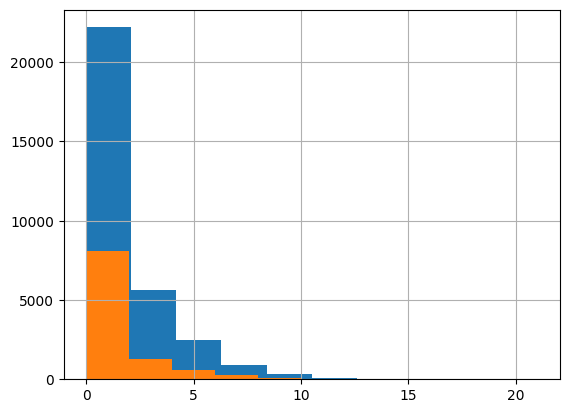

In [3141]:
df_object[df_object["type"].isin(['Многоквартирный дом'])]["count_nearest_postamats"].hist()
df_object[df_object["type"].isin(['Hexagon_9'])]["count_nearest_postamats"].hist()



(25117, 64)


<AxesSubplot:>

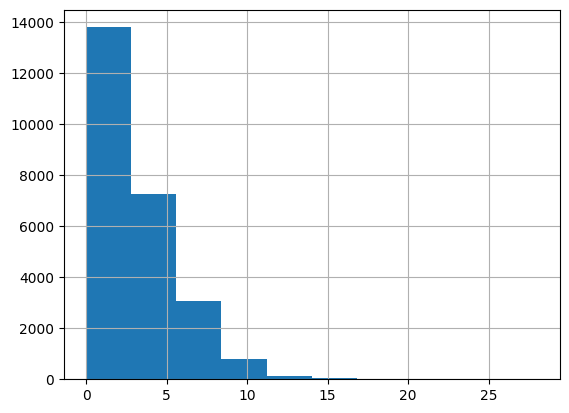

In [3142]:
print(df_object_hexagon_9[df_object_hexagon_9["population_house_living_square"]>3000].shape)
df_object_hexagon_9[df_object_hexagon_9["population_house_living_square"]>3000]["count_nearest_postamats"].hist()

In [3143]:
df_object.type.unique()

array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
       'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Библиотека',
       'Hexagon_7', 'Hexagon_8', 'Hexagon_9', 'Многоквартирный дом'],
      dtype=object)

In [3144]:
# df_object[df_object["type"].isin(['Hexagon_9'])]["count_nearest_postamats"].hist()

In [3145]:
# df_object[df_object["type"].isin(['Hexagon_8'])]["count_nearest_postamats"].hist()

In [3146]:
# df_object.groupby("type")["K_distance"].mean()

In [3147]:
df_object[df_object["K_distance"] == 0.1949]["type"].unique(), df_object[df_object["K_distance"] != 0.1949]["type"].unique()
df_object[df_object["K_distance"] == 0.1949]["type"].unique(), df_object[df_object["K_distance"] != 0.1949]["type"].unique()
# (array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
#         'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Библиотека',
#         'Hexagon_9', 'Многоквартирный дом'], dtype=object),
#  array(['Hexagon_7', 'Hexagon_8'], dtype=object))

(array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
        'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Библиотека',
        'Hexagon_9', 'Многоквартирный дом'], dtype=object),
 array(['Hexagon_7', 'Hexagon_8'], dtype=object))

In [3148]:
df_object.columns

Index(['index', 'type', 'name', 'geometry_name', 'lon', 'lat', 'geometry',
       'K_distance', 'distance_to_center', 'normalize_name', 'okato',
       'prc_children_1_6', 'region_average_age', 'prc_people_higher_education',
       'count_nearest_postamats', 'count_nearest_postamats_x2',
       'count_nearest_pvz', 'count_nearest_pvz_x2', 'count_nearest_pvz_shop',
       'count_nearest_pvz_shop_x2', 'count_competitor_pvz_postamat',
       'count_competitor_pvz_postamat_x2', 'food_delivery', 'food_delivery_x2',
       'velo_parking', 'velo_parking_x2', 'digitalization',
       'digitalization_without_postamat_normal',
       'digitalization_without_postamat', 'covering_postamats',
       'count_nearest_metro', 'count_nearest_metro_x2', 'count_nearest_ngpt',
       'count_nearest_ngpt_x2', 'count_nearest_auto_parking',
       'count_nearest_auto_parking_x2', 'transportization_norm',
       'transportization', 'level_working_region', 'level_sleeping_region',
       'level_sleep_work_regio

In [3149]:
# "prc_children_1_6", "region_average_age" - были добавлены ранее
df_object_region = pd.merge(df_object, boundaries.drop(columns=["NAME", "OSM_ID", "oktmo", "geometry", "normalize_name", "prc_children_1_6", "region_average_age", "prc_people_higher_education"]), on=["okato"])

df_Hexagon_7 = df_object_region[df_object_region["type"] == "Hexagon_7"]
df_Hexagon_8 = df_object_region[df_object_region["type"] == "Hexagon_8"]
df_Hexagon_9 = df_object_region[df_object_region["type"] == "Hexagon_9"]
df_object_hexagon_9 = df_object_region[~df_object_region["type"].isin(["Hexagon_7", "Hexagon_8"])]

## Формирование негативных примеров данных\
для использования в модели машинного обучения

<AxesSubplot:>

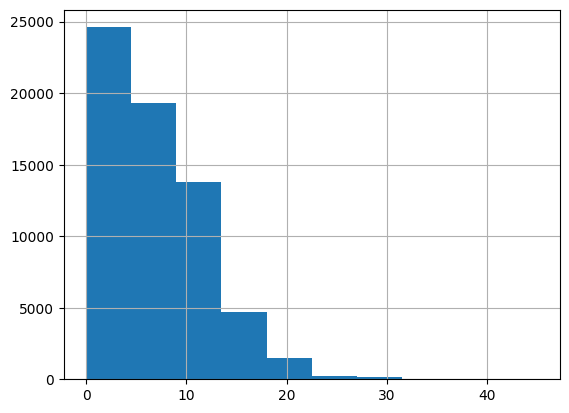

In [3150]:
test3 = df_object_hexagon_9.copy()
# pre_df_pozitive = df_object_hexagon_9[(df_object_hexagon_9["count_nearest_postamats"]>=5)]
# pre_df_negative = df_object_hexagon_9[(df_object_hexagon_9["count_nearest_postamats"]<=0)]
# pre_df_pozitive.shape, pre_df_negative.shape
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler((0,0.2))
scaler = StandardScaler()

# test3 = test3[(test3["count_nearest_postamats_x2"]>=2)]
test3["test3"] = scaler.fit_transform(test3["count_nearest_postamats_x2"].values.reshape(-1, 1))
test3["count_nearest_postamats_x2"].hist()
# scaler = MinMaxScaler((0,0.2))
# df_object_hexagon_9[(df_object_hexagon_9["count_nearest_postamats_x2"]>=2)]["count_nearest_postamats_x2"].hist()

In [3151]:
# df_object_hexagon_9[df_object_hexagon_9["population_house_living_square"]>3000]
pre_df_pozitive = df_object_hexagon_9[(df_object_hexagon_9["population_house_living_square"]>3000)&(df_object_hexagon_9["count_nearest_postamats_x2"]>=14)]
pre_df_negative = df_object_hexagon_9[(df_object_hexagon_9["population_house_living_square"]>3000)&(df_object_hexagon_9["count_nearest_postamats_x2"]<=3)]
pre_df_pozitive.loc[:,"target"] = 1
pre_df_negative.loc[:,"target"] = 0
pre_df_pozitive.shape, pre_df_negative.shape

D:\_Work\_Projects\_Conda\School\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


((4091, 75), (3645, 75))

In [3152]:
# # df_object_hexagon_9[df_object_hexagon_9["population_house_living_square"]>3000]
# pre_df_pozitive = df_object_hexagon_9[(df_object_hexagon_9["population_house_living_square"]>2000)&(df_object_hexagon_9["count_nearest_postamats_x2"]>=14)]
# pre_df_negative = df_object_hexagon_9[(df_object_hexagon_9["population_house_living_square"]>2000)&(df_object_hexagon_9["count_nearest_postamats_x2"]<=2)]
# pre_df_pozitive.loc[:,"target"] = 1
# pre_df_negative.loc[:,"target"] = 0
# pre_df_pozitive.shape, pre_df_negative.shape

In [3153]:
# pre_df_pozitive = df_object_hexagon_9[(df_object_hexagon_9["population_house_living_square"]>1000)&(df_object_hexagon_9["count_nearest_postamats_x2"]>=14)]
# pre_df_negative = df_object_hexagon_9[(df_object_hexagon_9["population_house_living_square"]>1000)&(df_object_hexagon_9["count_nearest_postamats_x2"]<=2)]

# pre_df_pozitive.loc[:,"target"] = 1
# pre_df_negative.loc[:,"target"] = 0

# pre_df_pozitive.shape, pre_df_negative.shape

## Выгружаем данные 

In [3154]:
# Выгружаем данные для обучения модели по объектам и гексагонам
df_dataset_for_model = pd.concat([pre_df_pozitive,pre_df_negative])
df_dataset_for_model.to_csv(PATH_DATASET_RESULT + "dataset_for_model.csv", sep=";")

In [3155]:
# pre_df_pozitive = df_object_hexagon_9[(df_object_hexagon_9["count_nearest_postamats_x2"]>=12)&(df_object_hexagon_9["type"] == "Hexagon_9")]
# pre_df_negative = df_object_hexagon_9[(df_object_hexagon_9["count_nearest_postamats_x2"]<=2)&(df_object_hexagon_9["type"] == "Hexagon_9")]
# pre_df_pozitive.shape, pre_df_negative.shape

In [3156]:
# Выгружаем данные для предсказывания по объектам и гексагонам
df_object_hexagon_9.to_csv(PATH_DATASET_RESULT + "df_object_hexagon_9.csv", sep=";")

In [3157]:
# выгружаем данные по гексогонам 9ый будет использоваться в предсказаниях
df_Hexagon_7.to_csv(PATH_DATASET_RESULT + "df_Hexagon_7.csv", sep=";")
df_Hexagon_8.to_csv(PATH_DATASET_RESULT + "df_Hexagon_8.csv", sep=";")

In [3158]:
df_Hexagon_8.shape

(1481, 74)

### Выгружаем объекты (для предикта)

In [ ]:
# pre_df_pozitive = df_pozitive[(df_pozitive["count_nearest_postamats"]>=20)]
# pre_df_pozitive[["count_nearest_postamats", "count_nearest_pvz", 'food_delivery', 'digitalization',
#        'covering_postamats', 'normalize_name', 'okato', 'count_nearest_metro',
#        'count_nearest_ngpt', 'level_working_region', 'level_sleeping_region',
#        'count_house_flat', 'population_house_flat',]].describe()

In [ ]:

### выгружаем гексогоны (для предикта)
### выгружаем гексогоны (для объединения)
### выгружаем трайн/тест (для обучения)

In [ ]:

# negative_type = ['Автосервисы', 'Музей', 'Дом культуры', 'Больницы', 'Досуг', "Образование", "Строительство", "Спорт"]
# df_negative = df_object[df_object["type"].isin(negative_type)]
# df_negative = df_object[~df_object["type"].isin(['Киоск', 'МФЦ', 'Дом культуры'])]
df_negative = df_object[df_object["type"].isin(['Hexagon'])]
df_negative = df_negative[df_negative["population_house_living_square"] > 5000]
# df_negative = df_object.copy()

df_negative.columns
df_negative.shape

In [ ]:
# count_nearest_postamats_2km

df_negative["count_nearest_postamats"].shape, df_negative[df_negative["count_nearest_postamats"]<=3].shape

In [1737]:
# df_pozitive.shape, df_pozitive[(df_pozitive["count_nearest_postamats"]<=10)&(df_pozitive["population_house_living_square"]<=30000)].shape
# pre_df_pozitive = df_pozitive[(df_pozitive["count_nearest_postamats"]>=20)&(df_pozitive["population_house_living_square"]>=40000)]
pre_df_pozitive = df_pozitive[(df_pozitive["count_nearest_postamats"]>=20)]
pre_df_pozitive[["count_nearest_postamats", "count_nearest_pvz", 'food_delivery', 'digitalization',
       'covering_postamats', 'normalize_name', 'okato', 'count_nearest_metro',
       'count_nearest_ngpt', 'level_working_region', 'level_sleeping_region',
       'count_house_flat', 'population_house_flat',]].describe()


,count_nearest_postamats,count_nearest_pvz,food_delivery,digitalization,covering_postamats,okato,count_nearest_metro,count_nearest_ngpt,level_working_region,level_sleeping_region,count_house_flat,population_house_flat
count,5923.000000,5923.000000,5923.000000,5923.000000,5923.000000,5.923000e+03,5923.000000,5923.000000,5923.000000,5923.000000,5923.000000,5923.000000
mean,40.327030,15.019247,5.433564,1.315131,55.346277,4.528297e+10,1.021104,14.974337,31428.003546,26770.419720,21061.046260,67413.766166
std,13.997162,5.917276,2.804945,0.332370,17.742077,1.084509e+07,0.893366,5.480155,35190.184829,16008.105851,7636.223275,24434.021116
min,20.000000,1.000000,0.000000,0.524164,21.000000,4.526355e+10,0.000000,0.000000,72.000000,31.000000,2264.000000,7244.000000
25%,30.000000,11.000000,4.000000,1.074730,43.000000,4.527757e+10,0.000000,11.000000,10893.000000,14813.000000,15589.000000,49897.500000
50%,38.000000,14.000000,5.000000,1.292062,53.000000,4.528357e+10,1.000000,15.000000,20973.000000,24432.000000,20511.000000,65654.000000
75%,47.000000,19.000000,7.000000,1.538738,65.000000,4.529356e+10,2.000000,18.000000,37601.000000,37114.000000,26519.500000,84872.500000
max,103.000000,39.000000,19.000000,2.495400,129.000000,4.529660e+10,5.000000,42.000000,302627.000000,78872.000000,50982.000000,163167.000000


In [1738]:
# pre_df_negative = df_negative[(df_negative["count_nearest_postamats"]<=10)&(df_negative["population_house_living_square"]<=40000)]
pre_df_negative = df_negative[(df_negative["count_nearest_postamats"]<=8)]
pre_df_negative[["count_nearest_postamats", "count_nearest_pvz", 'food_delivery', 'digitalization',
       'covering_postamats', 'normalize_name', 'okato', 'count_nearest_metro',
       'count_nearest_ngpt', 'level_working_region', 'level_sleeping_region',
       'count_house_flat', 'population_house_flat',]].describe()

# df_object["count_nearest_postamats"] * w_digitalization_pastomats  + df_object["count_nearest_pvz"] * w_digitalization_pvz + df_object["food_delivery"] * w_digitalization_food_delivery

,count_nearest_postamats,count_nearest_pvz,food_delivery,digitalization,covering_postamats,okato,count_nearest_metro,count_nearest_ngpt,level_working_region,level_sleeping_region,count_house_flat,population_house_flat
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1739]:
# boundaries.drop(columns=["NAME", "OSM_ID", "oktmo", "geometry", "normalize_name", ]).info()



In [1740]:
pre_df_pozitive["target"] = 1
pre_df_negative["target"] = 0
dataset_for_model = pd.concat([pre_df_pozitive,pre_df_negative])
dataset_for_model = pd.merge(dataset_for_model, boundaries.drop(columns=["NAME", "OSM_ID", "oktmo", "geometry", "normalize_name", ]), on=["okato"])
dataset_for_model.to_csv(PATH_DATASET + "dataset_for_model.csv", sep=";")
dataset_for_model.shape

D:\_Work\_Projects\_Conda\School\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(5923, 70)

In [1741]:
predict_type = ['Киоск', 'МФЦ', 'Дом культуры', 'Библиотека', "Hexagon"]
df_dataset_for_predict = df_object[df_object["type"].isin(predict_type)]
df_dataset_for_predict = pd.merge(df_dataset_for_predict, boundaries.drop(columns=["NAME", "OSM_ID", "oktmo", "geometry", "normalize_name", ]), on=["okato"])
df_dataset_for_predict.to_csv(PATH_DATASET + "dataset_for_predict.csv", sep=";")
df_dataset_for_predict.shape

(1856, 69)

In [1802]:
predict_type = ["Hexagon"]
df_dataset_for_predict = df_object[df_object["type"].isin(predict_type)]
df_dataset_for_predict = pd.merge(df_dataset_for_predict, boundaries.drop(columns=["NAME", "OSM_ID", "oktmo", "geometry", "normalize_name", ]), on=["okato"])
df_dataset_for_predict.to_csv(PATH_DATASET + "hexagon_dataset_for_predict.csv", sep=";")
df_dataset_for_predict.shape

KeyError: 'okato'

In [1742]:
predict_type = ['Киоск', 'МФЦ', 'Дом культуры',  'Библиотека']
df_dataset_for_predict = df_object[df_object["type"].isin(predict_type)]
df_dataset_for_predict.shape

(1856, 44)

In [2765]:
# df_object

In [1743]:
# test = df_auto
# geopandas.GeoDataFrame(
#     test, geometry=geopandas.points_from_xy(test.lon, test.lat)).plot()

### Выгружаем данные в фалы

In [1744]:
all_df_object = pd.merge(df_object, boundaries, on=["okato"])
all_df_object.shape

(26001, 74)

In [1745]:
df_object.to_csv(PATH_DATASET + "objects_dataset.csv", sep=";")

In [1746]:
all_df_object["type"].unique()

array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
       'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Спорт',
       'Библиотека'], dtype=object)

In [1747]:
geo_df_objects = geopandas.GeoDataFrame(
    df_object, geometry=geopandas.points_from_xy(df_object.lon, df_object.lat))

In [1748]:
# geo_df_objects.to_json(PATH_DATASET + "objects_dataset.json")
geo_df_objects.to_file(PATH_DATASET + "objects_dataset.json", driver="GeoJSON") 

In [1749]:
# # С разбивкой по типам объектов:
# for type_obj in geo_df_objects["type"].unique():
#     print(type_obj)
#     geo_df_objects[geo_df_objects["type"] == type_obj].to_file(PATH_DATASET + f"TypeSplit__{type_obj}__objects_dataset.json", driver="GeoJSON") 

In [1750]:
boundaries.to_file(PATH_DATASET + "region.json", driver="GeoJSON")

# Feature
# MultiPolygon
# Polygon

In [ ]:

# # test2 = geopandas.read_file(PATH_DATASET + "predict_postamats.csv", encoding='utf-8')
# predict_df = pd.read_csv(PATH_DATASET + "predict_postamats.csv", encoding='utf-8', sep=";")
# # geopandas.GeoDataFrame(
# geo_predict_df = geopandas.GeoDataFrame(
#     predict_df, geometry=geopandas.points_from_xy(predict_df.lon, predict_df.lat))
# # test_df = geopandas.GeoDataFrame()
# geo_predict_df.to_file(PATH_DATASET + "predict_postamats.json", driver="GeoJSON") 


In [ ]:
# predict_df.describe()

In [ ]:
# boundaries.to_json()

In [ ]:
# test2 = geopandas.read_file(PATH_DATASET + "moscow_regions_base2.geojson", encoding='utf-8')
# test2.okato = test2.okato.astype(np.int64)

In [ ]:
# # boundaries.info(), test2.info()
# test3 = pd.merge(boundaries.drop(columns=["geometry"]),test2[["okato", "geometry"]])
# test3.info()

In [ ]:
test3.plot()

In [1558]:
# df_object["turnover_postamats"] = df_object["turnover_postamats"].replace([np.inf, -np.inf], 0, inplace=True)

In [1496]:
test_df = geopandas.GeoDataFrame(pd.read_csv(PATH_DATASET + "moscow_region_geod_stats_v3.csv", encoding='utf-8'))
test_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     120 non-null    int64  
 1   id                             120 non-null    int64  
 2   region_name                    120 non-null    object 
 3   ao_code                        120 non-null    object 
 4   okato                          120 non-null    int64  
 5   oktmo                          120 non-null    int64  
 6   area_km2_2012                  120 non-null    float64
 7   population_2022                120 non-null    int64  
 8   population_density_2022        120 non-null    float64
 9   avr_living_m2_per_person_2010  120 non-null    float64
 10  NAME_EN                        120 non-null    object 
 11  NAME_RU                        116 non-null    object 
 12  ADMIN_LVL                      120 non-nul

In [1493]:
test_df = geopandas.read_file(PATH_DATASET + "moscow_region_geod_stats_v2.csv", encoding='utf-8', geometry='multipolygon')
test_df.info()

ValueError: GeoDataFrame does not support multiple columns using the geometry column name 'geometry'.

In [1490]:
test_df = pd.read_csv(PATH_DATASET + "moscow_region_geod_stats_v2.csv", encoding='utf-8')
test_df["geometry"] = test_df["multipolygon"]
# test_df = test_df.drop(columns=["geometry"]).columns
# test_df = test_df.drop(columns=["geometry"]).columns
# test_df.okato = test_df.okato.astype(float)
test_df = geopandas.GeoDataFrame(test_df, geometry='multipolygon')
# test_df.multipolygon = test_df.multipolygon.astype(geometry)
test_df.info()

TypeError: Input must be valid geometry objects: POLYGON ((37.7076521 55.8036497, 37.7073844 55.8035774, 37.7073324 55.8035634, 37.7070705 55.8034926, 37.706941 55.8034579, 37.7067972 55.8034194, 37.7066268 55.8033728, 37.706139 55.803241, 37.705866 55.8031634, 37.7051905 55.8029849, 37.7045376 55.802812, 37.7044583 55.8027871, 37.7042736 55.8027372, 37.7039063 55.802638, 37.7035908 55.8025528, 37.7023722 55.8022237, 37.7009644 55.8018716, 37.6998637 55.8015018, 37.6995694 55.8014314, 37.699408 55.8014056, 37.6991528 55.8013749, 37.6989873 55.8013565, 37.6989178 55.8013487, 37.6988032 55.8013426, 37.6988284 55.8014593, 37.698896 55.8015985, 37.6991949 55.8022138, 37.6992306 55.802355, 37.699319 55.8024908, 37.6995052 55.8027299, 37.6996989 55.8029425, 37.6997612 55.803013, 37.6998811 55.8032001, 37.7000125 55.8034645, 37.7002334 55.8036217, 37.7004453 55.8038831, 37.7005327 55.8039845, 37.7007355 55.804196, 37.7008737 55.8044473, 37.7011603 55.8047029, 37.7013781 55.8049405, 37.7014633 55.805112, 37.7016941 55.8053359, 37.7018211 55.8055643, 37.7018891 55.8058665, 37.7019702 55.8065091, 37.7018062 55.8070202, 37.7016514 55.8073559, 37.7013864 55.8076502, 37.7010584 55.8078844, 37.7006853 55.8080509, 37.700413 55.8082823, 37.7003334 55.8084754, 37.7003393 55.8090706, 37.7002953 55.8096015, 37.7002608 55.809693, 37.7001493 55.8098352, 37.7000492 55.8099181, 37.6999368 55.8099874, 37.699669 55.8100689, 37.6993825 55.8101036, 37.6988067 55.8100902, 37.6985263 55.8101977, 37.6983263 55.8103474, 37.6978774 55.8106292, 37.6972403 55.8107891, 37.696558 55.8107911, 37.6958904 55.8107221, 37.6958151 55.810727, 37.6954947 55.8107477, 37.6950357 55.8108602, 37.6948191 55.8109421, 37.6947416 55.8110707, 37.6947862 55.8111842, 37.6949076 55.8113344, 37.6951853 55.8115835, 37.695422 55.8117756, 37.6954308 55.8119515, 37.6952865 55.8121152, 37.6949801 55.8122546, 37.694636 55.8123053, 37.6940056 55.8123263, 37.693776 55.8123339, 37.6934662 55.812399, 37.6919993 55.813202, 37.6915615 55.8134338, 37.6913329 55.813735, 37.6907908 55.8143247, 37.6894153 55.8153325, 37.6886515 55.8160476, 37.6882857 55.8165305, 37.6879497 55.8168086, 37.687575 55.8171194, 37.6874212 55.8171363, 37.6872963 55.8170847, 37.6867142 55.8168263, 37.6862588 55.8167738, 37.6854385 55.816857, 37.6843406 55.8171514, 37.683698 55.817408, 37.6825135 55.8178883, 37.6820449 55.8180332, 37.6813575 55.8181299, 37.6800048 55.8181465, 37.6794303 55.8182302, 37.6792313 55.8182938, 37.6789385 55.8184689, 37.6787422 55.8186808, 37.6784313 55.818849, 37.6778881 55.8189435, 37.6774629 55.8190546, 37.6770344 55.819268, 37.676623 55.8194635, 37.6754114 55.820279, 37.6750202 55.8204079, 37.674908 55.8204947, 37.6748358 55.8206063, 37.674792 55.8208757, 37.6746784 55.8210397, 37.6745344 55.8212515, 37.6742698 55.8213914, 37.6736487 55.8216456, 37.6727419 55.8223728, 37.6724714 55.8226193, 37.6719165 55.8235167, 37.6713202 55.8239427, 37.6709953 55.8242738, 37.6707749 55.82438, 37.6706753 55.8243959, 37.6707973 55.8248211, 37.6708388 55.8249572, 37.6710217 55.8256719, 37.6712823 55.826604, 37.6715201 55.8273626, 37.6715749 55.8290255, 37.6715397 55.8292742, 37.671432 55.8300367, 37.671274 55.8308872, 37.6710664 55.8322989, 37.6710273 55.8325648, 37.6708873 55.833602, 37.6707673 55.8345082, 37.6706272 55.8356502, 37.6705206 55.8365488, 37.6703805 55.8376758, 37.6702254 55.8386456, 37.6702104 55.8387396, 37.6712583 55.8384606, 37.673791 55.8378085, 37.6772835 55.8369298, 37.6834818 55.8353635, 37.6872376 55.8343876, 37.6899839 55.8335274, 37.6925475 55.8326711, 37.6947752 55.8319113, 37.6979361 55.8308358, 37.7012932 55.8297142, 37.7037544 55.8288781, 37.7083035 55.8273205, 37.7116618 55.8261462, 37.7123319 55.8258988, 37.7152745 55.8249256, 37.721988 55.8226231, 37.7251405 55.8215512, 37.727082 55.8209022, 37.7309828 55.8195784, 37.7331591 55.8188295, 37.7347562 55.8182222, 37.7360045 55.817666, 37.7366081 55.8173856, 37.7373361 55.8170364, 37.7385015 55.8164165, 37.7397941 55.8157421, 37.7414402 55.8148341, 37.7419366 55.8145278, 37.7428123 55.8141203, 37.7451291 55.8118195, 37.7459305 55.8103596, 37.7459289 55.80903, 37.7449547 55.8089734, 37.7424653 55.8089735, 37.7402687 55.8089737, 37.7392996 55.8089738, 37.7381682 55.808978, 37.7362821 55.8089936, 37.7356356 55.8089959, 37.7351112 55.8089979, 37.7350805 55.808998, 37.7347997 55.8089988, 37.7339343 55.8090011, 37.7336049 55.8090012, 37.7333616 55.8090021, 37.732352 55.8089993, 37.7321045 55.8089323, 37.7318752 55.808802, 37.7318335 55.8087783, 37.731732 55.8088372, 37.7313958 55.8090169, 37.7310713 55.8091802, 37.7301362 55.8096636, 37.729966 55.8097549, 37.729849 55.8098175, 37.7297405 55.8097524, 37.7292389 55.8094563, 37.7285152 55.8090271, 37.7275753 55.8084885, 37.7274675 55.8084294, 37.726705 55.807977, 37.7266715 55.8079571, 37.7266439 55.8079397, 37.7266039 55.8079159, 37.7262626 55.8077143, 37.7261005 55.8076191, 37.7250309 55.8069914, 37.7250039 55.8069755, 37.7249548 55.8069442, 37.7248105 55.8068522, 37.7247163 55.8067943, 37.7246322 55.8067512, 37.724465 55.8066656, 37.7242862 55.806587, 37.7240882 55.806516, 37.7239973 55.8064964, 37.7227637 55.806268, 37.7226677 55.8062502, 37.7225622 55.8062321, 37.7222252 55.8061741, 37.7219883 55.8061334, 37.7214936 55.8060483, 37.7212645 55.8060089, 37.72091 55.8059479, 37.7190054 55.8056243, 37.7184814 55.8055353, 37.7179509 55.8054492, 37.7178623 55.8054342, 37.7177587 55.8054179, 37.7175178 55.8053753, 37.7172935 55.8053363, 37.7167493 55.8052415, 37.7163512 55.8051741, 37.7153493 55.8050045, 37.7144859 55.8048592, 37.7143447 55.8048356, 37.7141986 55.8048098, 37.7122997 55.8044697, 37.7121034 55.8044369, 37.711934 55.8044067, 37.7116423 55.8043515, 37.7115409 55.8043127, 37.711367 55.8042233, 37.7090096 55.8030492, 37.7087687 55.8029044, 37.7087511 55.8028938, 37.7082499 55.803211, 37.7081126 55.8033258, 37.7077914 55.8035338, 37.7076755 55.803656, 37.7076521 55.8036497))

In [1482]:
# test_df = geopandas.read_file(PATH_DATASET + "moscow_region_geod_stats_v2.csv", encoding='utf-8', geometry='multipolygon')
test_df = pd.read_csv(PATH_DATASET + "moscow_region_geod_stats_v2.csv", encoding='utf-8')
test_df = test_df.drop(columns=["geometry"]).columns
test_df.okato = test_df.okato.astype(float)
test_df.multipolygon = test_df.multipolygon.astype(geometry)
# test_df = geopandas.GeoDataFrame(test_df, geometry='multipolygon')

boundaries.geometry
test_df.geometry

# boundaries[(boundaries.okato == test_df.okato)&(boundaries.geometry != test_df.geometry)]
# boundaries[(boundaries.okato == test_df.okato)]
# np.where(boundaries.okato == test_df.okato, test_df.geometry, )

# boundaries.info()

# test_df.multipolygon
# test_df[boundaries.geometry.isin(test_df.multipolygon)]
# test_df.iloc[0].multipolygon
test_boundaries = pd.merge(boundaries, test_df[["okato", "multipolygon"]], on=["okato"])
# test_boundaries[test_boundaries["multipolygon"] != test_boundaries["geometry"]]
test_boundaries.iloc[1]["multipolygon"] == test_boundaries.iloc[1]["geometry"]
test_boundaries.iloc[0]["multipolygon"], test_boundaries.iloc[0]["geometry"]
type(test_boundaries.iloc[0]["multipolygon"]), type(test_boundaries.iloc[0]["geometry"])


NameError: name 'geometry' is not defined

In [1465]:
# boundaries

In [ ]:
# 4. Оборачиваемость постаматов справочная инфа (исходя из данных которые сможем найти и экстраполировать на дургие райны используя сведения об уровне цифровизации района и уровене комфорта). Надо отдельно обсудить как считаем.

# Транспортная доступность:
# 9. кол-во парковок в радиусе
# 10. кол-во остановок и станций метро/МЦК в радиусе (по отдельности считать)

# Негативные факторы:
# 11. близкое расположение с местами сбора отходов
# Доп, если получится достать такие данные:
# 12. кол-во многоквартирых домов в радиусе (желательно считать в кол-ве квартир опять же таки если найдем)
# 13. для уровня цифровизации средний возраст жителей района
#  еще что-то?

# Уровень благосостояния района
# budget_revenues[0,1] + 1-budget_expenditures[0,1]
# budget_revenues + budget_expenditures
# Негативные случаи
# Необходимо для тренировки модели

# Рекомендательные характеристики:
# 14. Уровень рекомендации от модели МО (рассчитанная на основе всех признаков, тренировка на существующих, а для новых уже прогноз модели)
# 15. Агрегированный рейтинг привлекательности для размещения (также рассчитывается для существующих постаматов и ПВЗ. Т.е. по сути мы даем рейтинг на сколько  эффективно размещены текущие постаматы) именно этот параметр надо уметь интерпретировать исходя из набора данных

In [733]:
### Перевод в геопандас

In [ ]:
src_df_object = df_object.copy()
src_df_object.shape
geo_df_objects = geopandas.GeoDataFrame(
    df_object, geometry=geopandas.points_from_xy(df_object.lon, df_object.lat))

In [144]:
gdf_pastomats = geopandas.GeoDataFrame(
    df_pastomats, geometry=geopandas.points_from_xy(df_pastomats.lon, df_pastomats.lat))
gdf_pastomats

,name,city_name,geometry_name,lon,lat,geometry
0,"Утконос, продуктомат",Москва,"Поляны, 50",37.525072,55.553506,POINT (37.52507 55.55351)
1,"OZON Box, сеть автоматизированных пунктов выдачи",д. Хоругвино,"деревня Хоругвино, 32/3",37.211382,56.126976,POINT (37.21138 56.12698)
2,OZON,Москва,"Большая Дорогомиловская, 5",37.561515,55.745825,POINT (37.56151 55.74583)
3,"5post, сеть постаматов",Москва,"Саларьевская, 14 к3",37.410114,55.618236,POINT (37.41011 55.61824)
4,"Почта России, почтомат",Москва,"Покровская, 17 к3",37.932549,55.700202,POINT (37.93255 55.70020)
...,...,...,...,...,...,...
7895,"Cainiao, постамат",Москва,"Декабристов, 10 к2",37.598508,55.865793,POINT (37.59851 55.86579)
7896,"Cainiao, постамат",Москва,"Ярославское шоссе, 144",37.723572,55.879602,POINT (37.72357 55.87960)
7897,"Cainiao, постамат",Москва,"Маршала Баграмяна, 8",37.790432,55.669504,POINT (37.79043 55.66950)
7898,"Cainiao, постамат",Москва,"Паустовского, 5 к1",37.540830,55.599936,POINT (37.54083 55.59994)


In [731]:
# Расставляем рйаоны в которых располагается объект
# currentobj = df_object.iloc[2]
# # # print(boundaries["geometry"].iloc[0])
# p = Point(currentobj.lon, currentobj.lat)

# find_include_region = boundaries.contains(p)
# boundaries[find_include_region].normalize_name

# def get_region_by_point(df, point):
#     find_region = df[df.contains(point)]
#     if find_region.shape[0] == 0:
#         normalize_name = ""
#     else:
#         normalize_name = find_region.normalize_name.values[0]
#     return normalize_name

geo_df_objects["normalize_name"] = geo_df_objects.apply(lambda x: str(get_region_by_point(boundaries, Point(x.lon, x.lat))), axis=1)
# Исключаем объекты, которые не попали в районы города
geo_df_objects["normalize_name"] = geo_df_objects["normalize_name"].replace("", np.nan)
# df_object = df_object.dropna(subset=["normalize_name"])
# df_object.shape
geo_df_objects[geo_df_objects["normalize_name"].isna()]


,type,name,geometry_name,lon,lat,count_nearest_postamats,count_nearest_pvz,food_delivery,digitalization,covering_postamats,geometry,noramlize_name
5422,ПВЗ,OZON,"Суворова, 1/16",37.856287,55.918965,22,34,0,33.10,56,POINT (37.85629 55.91897),NaN
6620,ПВЗ,OZON,"Никитина, 11 к5",37.374725,55.601231,11,16,0,15.90,27,POINT (37.37472 55.60123),NaN
5701,Постамат,"Халва, сеть почтоматов","Мичуринский 2-й тупик, 1",37.301095,55.946794,15,15,0,17.25,30,POINT (37.30109 55.94679),NaN
2945,ПВЗ,"Wildberries, интернет-магазин","Нахимова, 14а",38.032014,55.958222,3,7,0,6.05,10,POINT (38.03201 55.95822),NaN
504,ПВЗ,"Ситилинк, Пункт выдачи товара","Ленина, 19",37.901634,55.577573,15,10,0,14.00,25,POINT (37.90163 55.57757),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6155,Постамат,"OZON Box, сеть автоматизированных пунктов выдачи","Парковая, 1/18",37.867711,55.695439,35,45,0,46.75,80,POINT (37.86771 55.69544),NaN
5091,ПВЗ,"Grastin, курьерская служба","проспект Мельникова, 10",37.404993,55.902303,26,42,0,40.30,68,POINT (37.40499 55.90230),NaN
1905,Постамат,"5post, сеть постаматов","Урицкого, 52",38.968412,55.811267,21,21,0,24.15,42,POINT (38.96841 55.81127),NaN
5346,ПВЗ,"Boxberry, Офис","Красноармейская, 23а",38.240465,55.572881,15,21,0,21.15,36,POINT (38.24047 55.57288),NaN


,index,type,name,geometry_name,lon,lat,geometry,distance_to_center,normalize_name,okato,...,population_house_living_square,count_house_flat_400,population_house_flat_400,population_house_square_400,population_house_living_square_400,count_house_flat_200,population_house_flat_200,population_house_square_200,population_house_living_square_200,turnover_postamats
1513,7,Hexagon,8a11aa68895ffff,NaN,37.922457,55.730255,"POLYGON ((37.92132443345273 55.73019098505022,...",19.144555,косино-ухтомский,45263573000,...,0,0,0,0,0,0,0,0,0,None
1525,913,Hexagon,8a11aa688177fff,NaN,37.931377,55.726566,"POLYGON ((37.93024430037032 55.72650249160172,...",19.760079,косино-ухтомский,45263573000,...,0,0,0,0,0,0,0,0,0,None
1550,1953,Hexagon,8a11aa6888d7fff,NaN,37.927980,55.726375,"POLYGON ((37.92684734920157 55.72631159475313,...",19.552732,косино-ухтомский,45263573000,...,0,0,0,0,0,0,0,0,0,None
1578,4199,Hexagon,8a11aa688817fff,NaN,37.922823,55.726684,POLYGON ((37.921691060464184 55.72662021623722...,19.227436,косино-ухтомский,45263573000,...,0,0,0,0,0,0,0,0,0,None
1585,5028,Hexagon,8a11aa68899ffff,NaN,37.921308,55.724803,POLYGON ((37.92017606389205 55.724739275912434...,19.168532,косино-ухтомский,45263573000,...,0,0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98717,72201,Hexagon,8a11aa0d5c8ffff,NaN,37.388283,55.941029,POLYGON ((37.387150810697264 55.94095952933087...,25.390113,молжаниновский,45277584000,...,0,0,0,0,0,0,0,0,0,None
98719,72411,Hexagon,8a11aa0d52effff,NaN,37.412462,55.953859,"POLYGON ((37.41132873131952 55.95378963178774,...",25.774048,молжаниновский,45277584000,...,0,0,0,0,0,0,0,0,0,None
98720,72452,Hexagon,8a11aa0d5c27fff,NaN,37.382843,55.943682,POLYGON ((37.38171084753842 55.943612617328476...,25.827419,молжаниновский,45277584000,...,0,0,0,0,0,0,0,0,0,None
98722,72602,Hexagon,8a11aa0d4a1ffff,NaN,37.374973,55.937823,POLYGON ((37.37384056406185 55.937753430504735...,25.591232,молжаниновский,45277584000,...,0,0,0,0,0,0,0,0,0,None


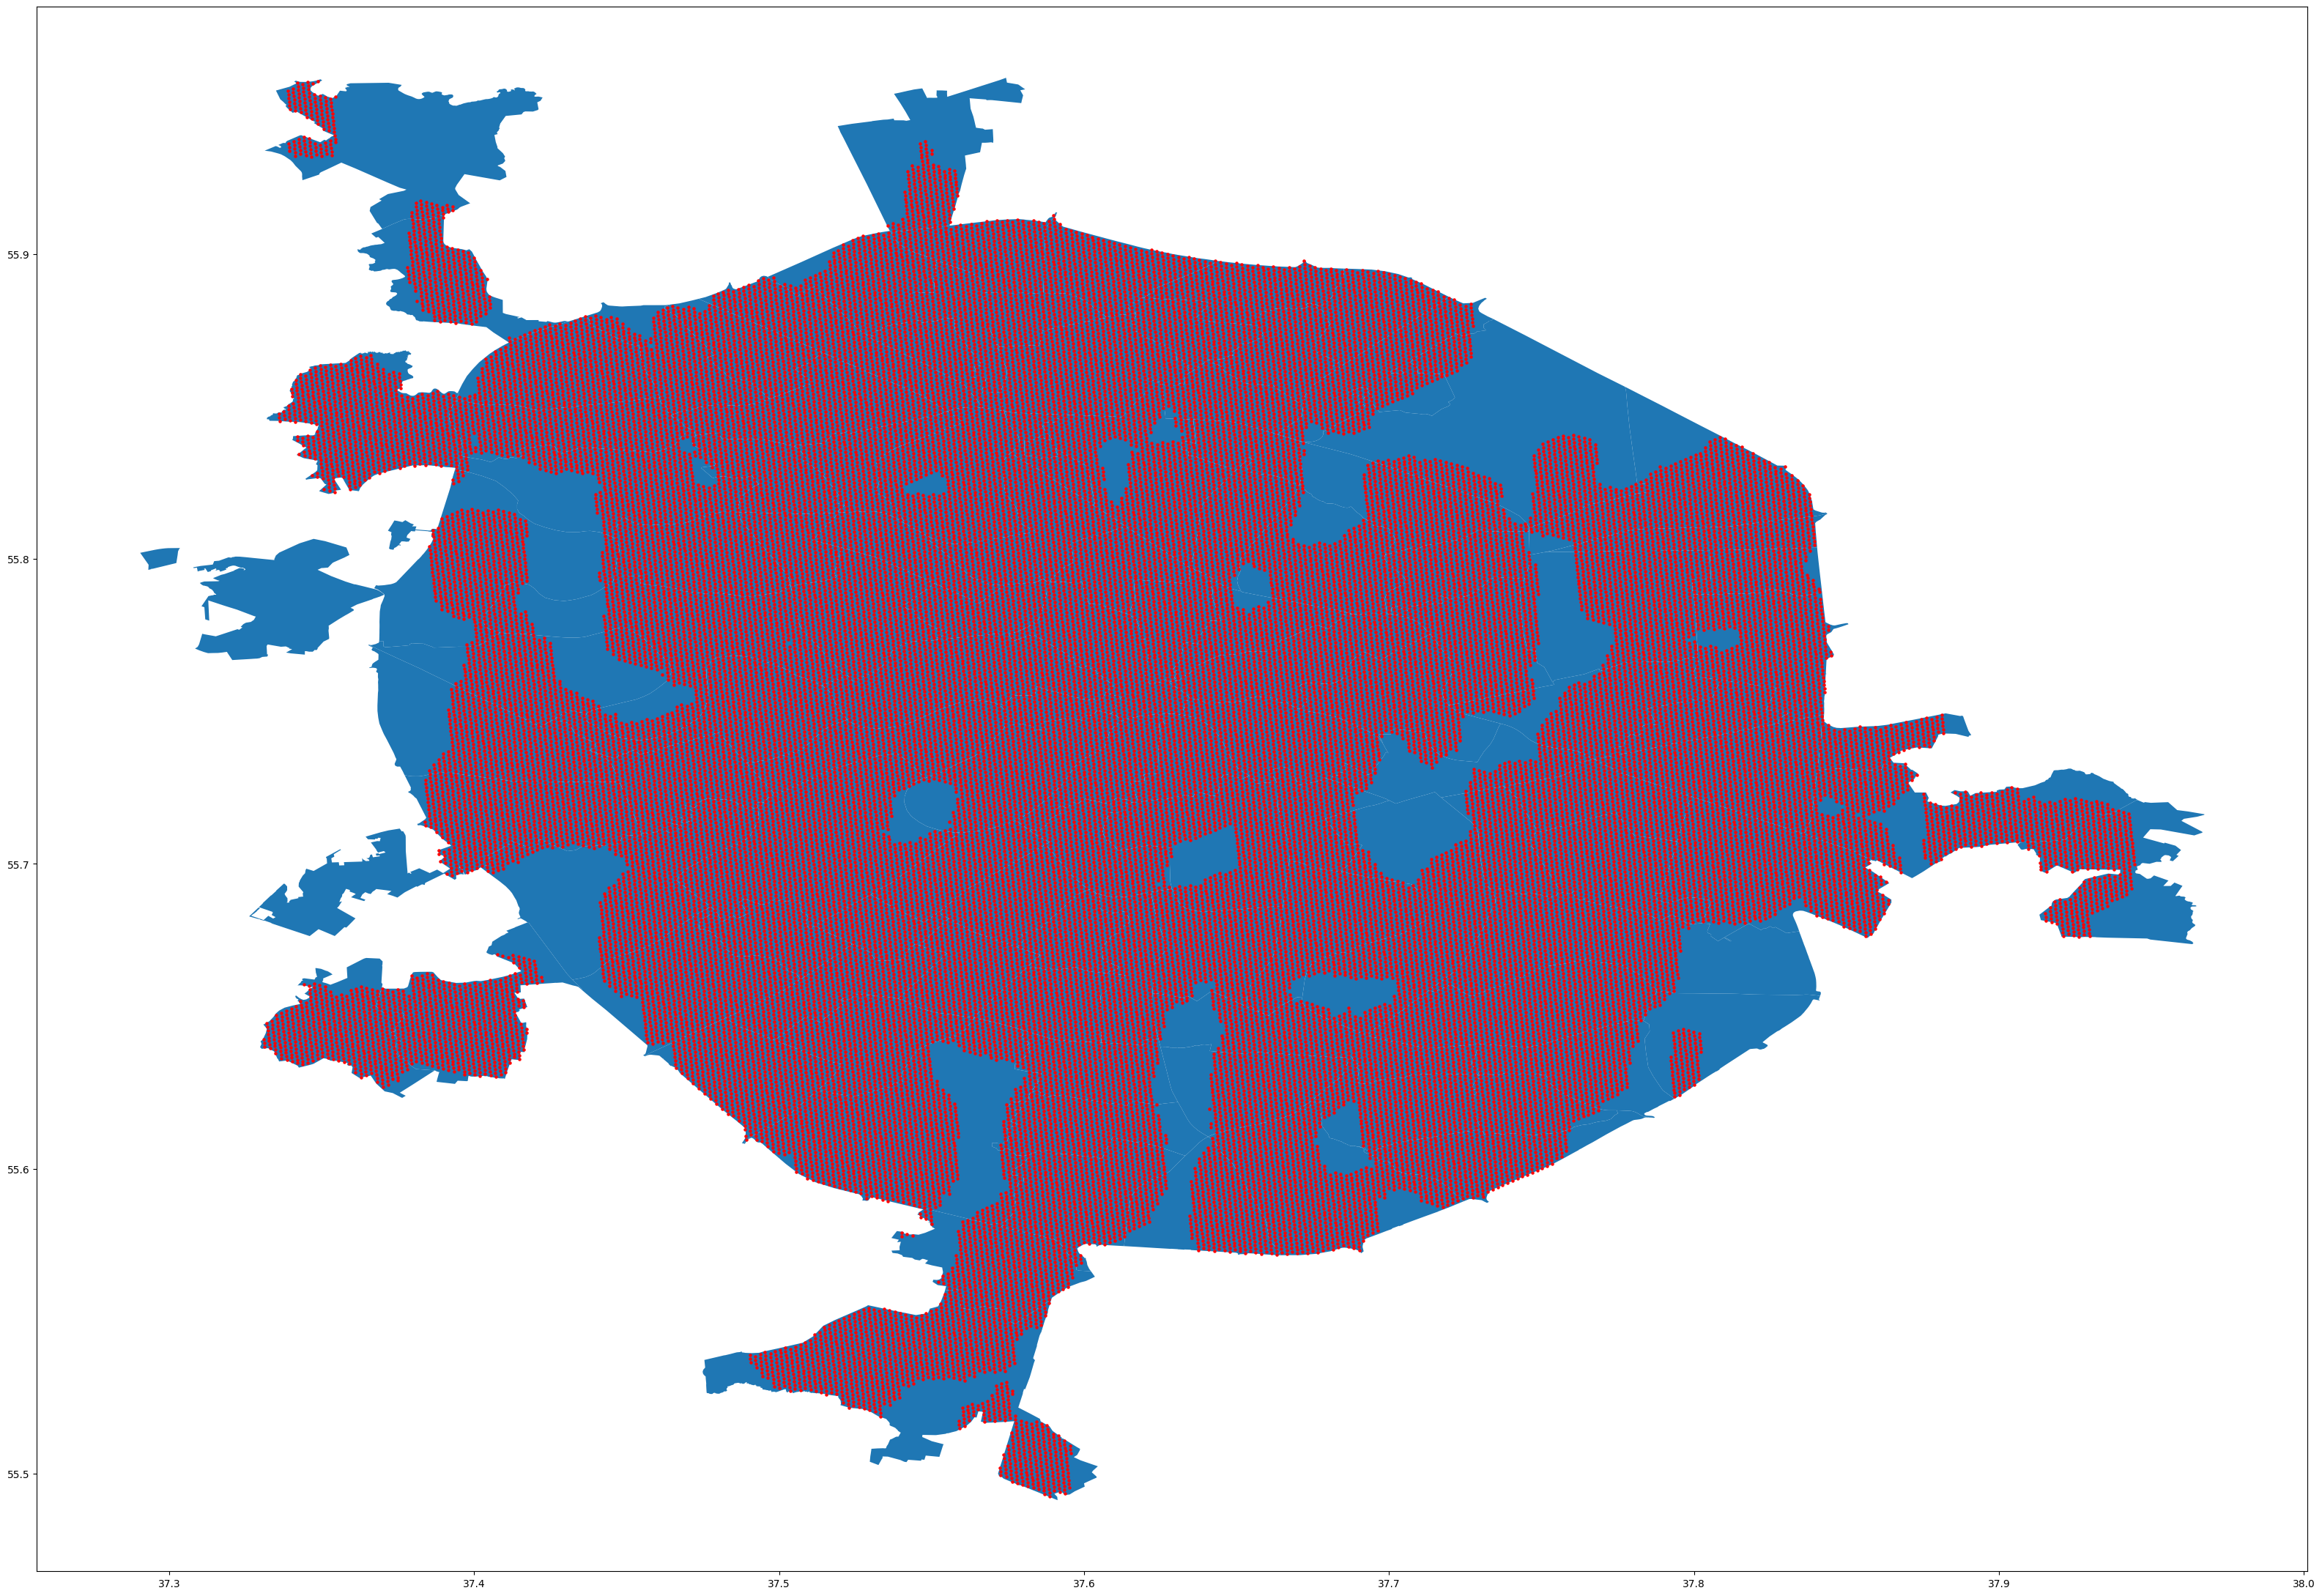

In [1557]:
test = df_object[df_object["type"].isin(['Hexagon'])]
test = test[test["population_house_living_square"] > 10000]
base = boundaries.plot(figsize=(40,40))
geo_df_test = geopandas.GeoDataFrame(
    test, geometry=geopandas.points_from_xy(test.lon, test.lat))
geo_df_test.plot(ax=base, marker='o', color='red', markersize=5);

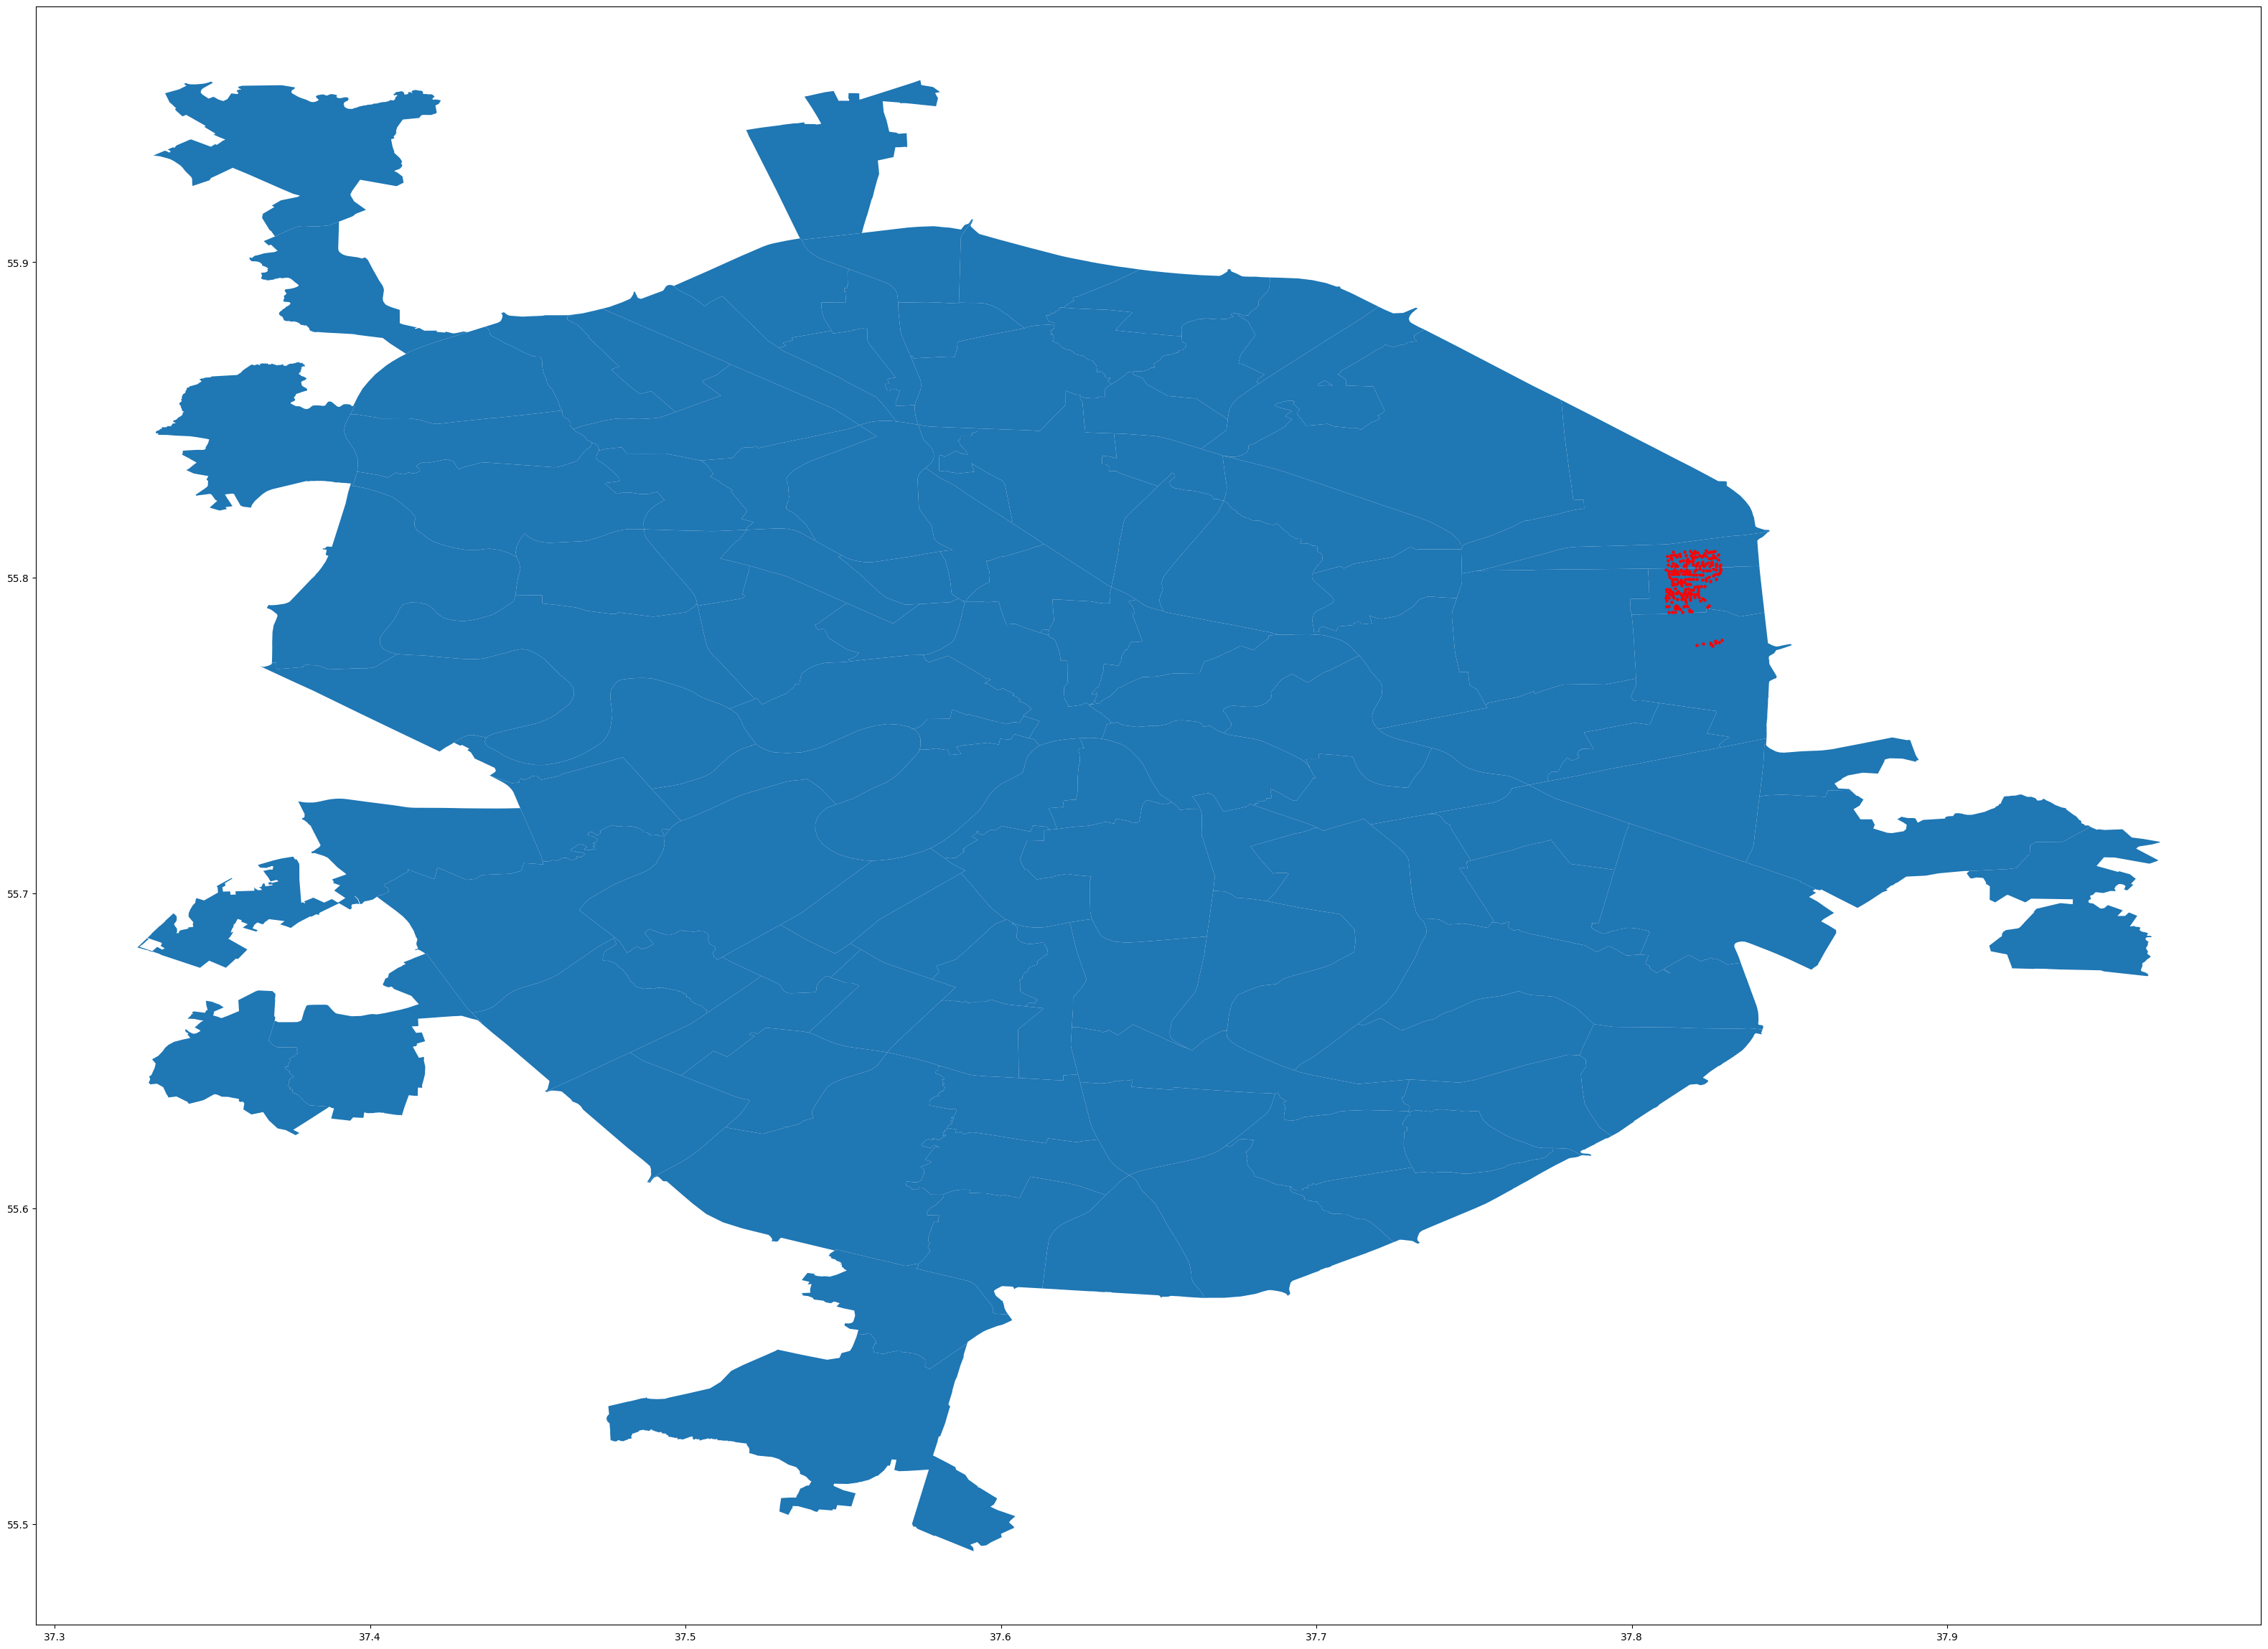

In [991]:
base = boundaries.plot(figsize=(40,40))
geo_df_objects = geopandas.GeoDataFrame(
    global_test_house, geometry=geopandas.points_from_xy(global_test_house.lon, global_test_house.lat))
# geo_df_objects[geo_df_objects["normalize_name"].isna()].plot(ax=base, marker='o', color='red', markersize=5);
geo_df_objects.plot(ax=base, marker='o', color='red', markersize=5);

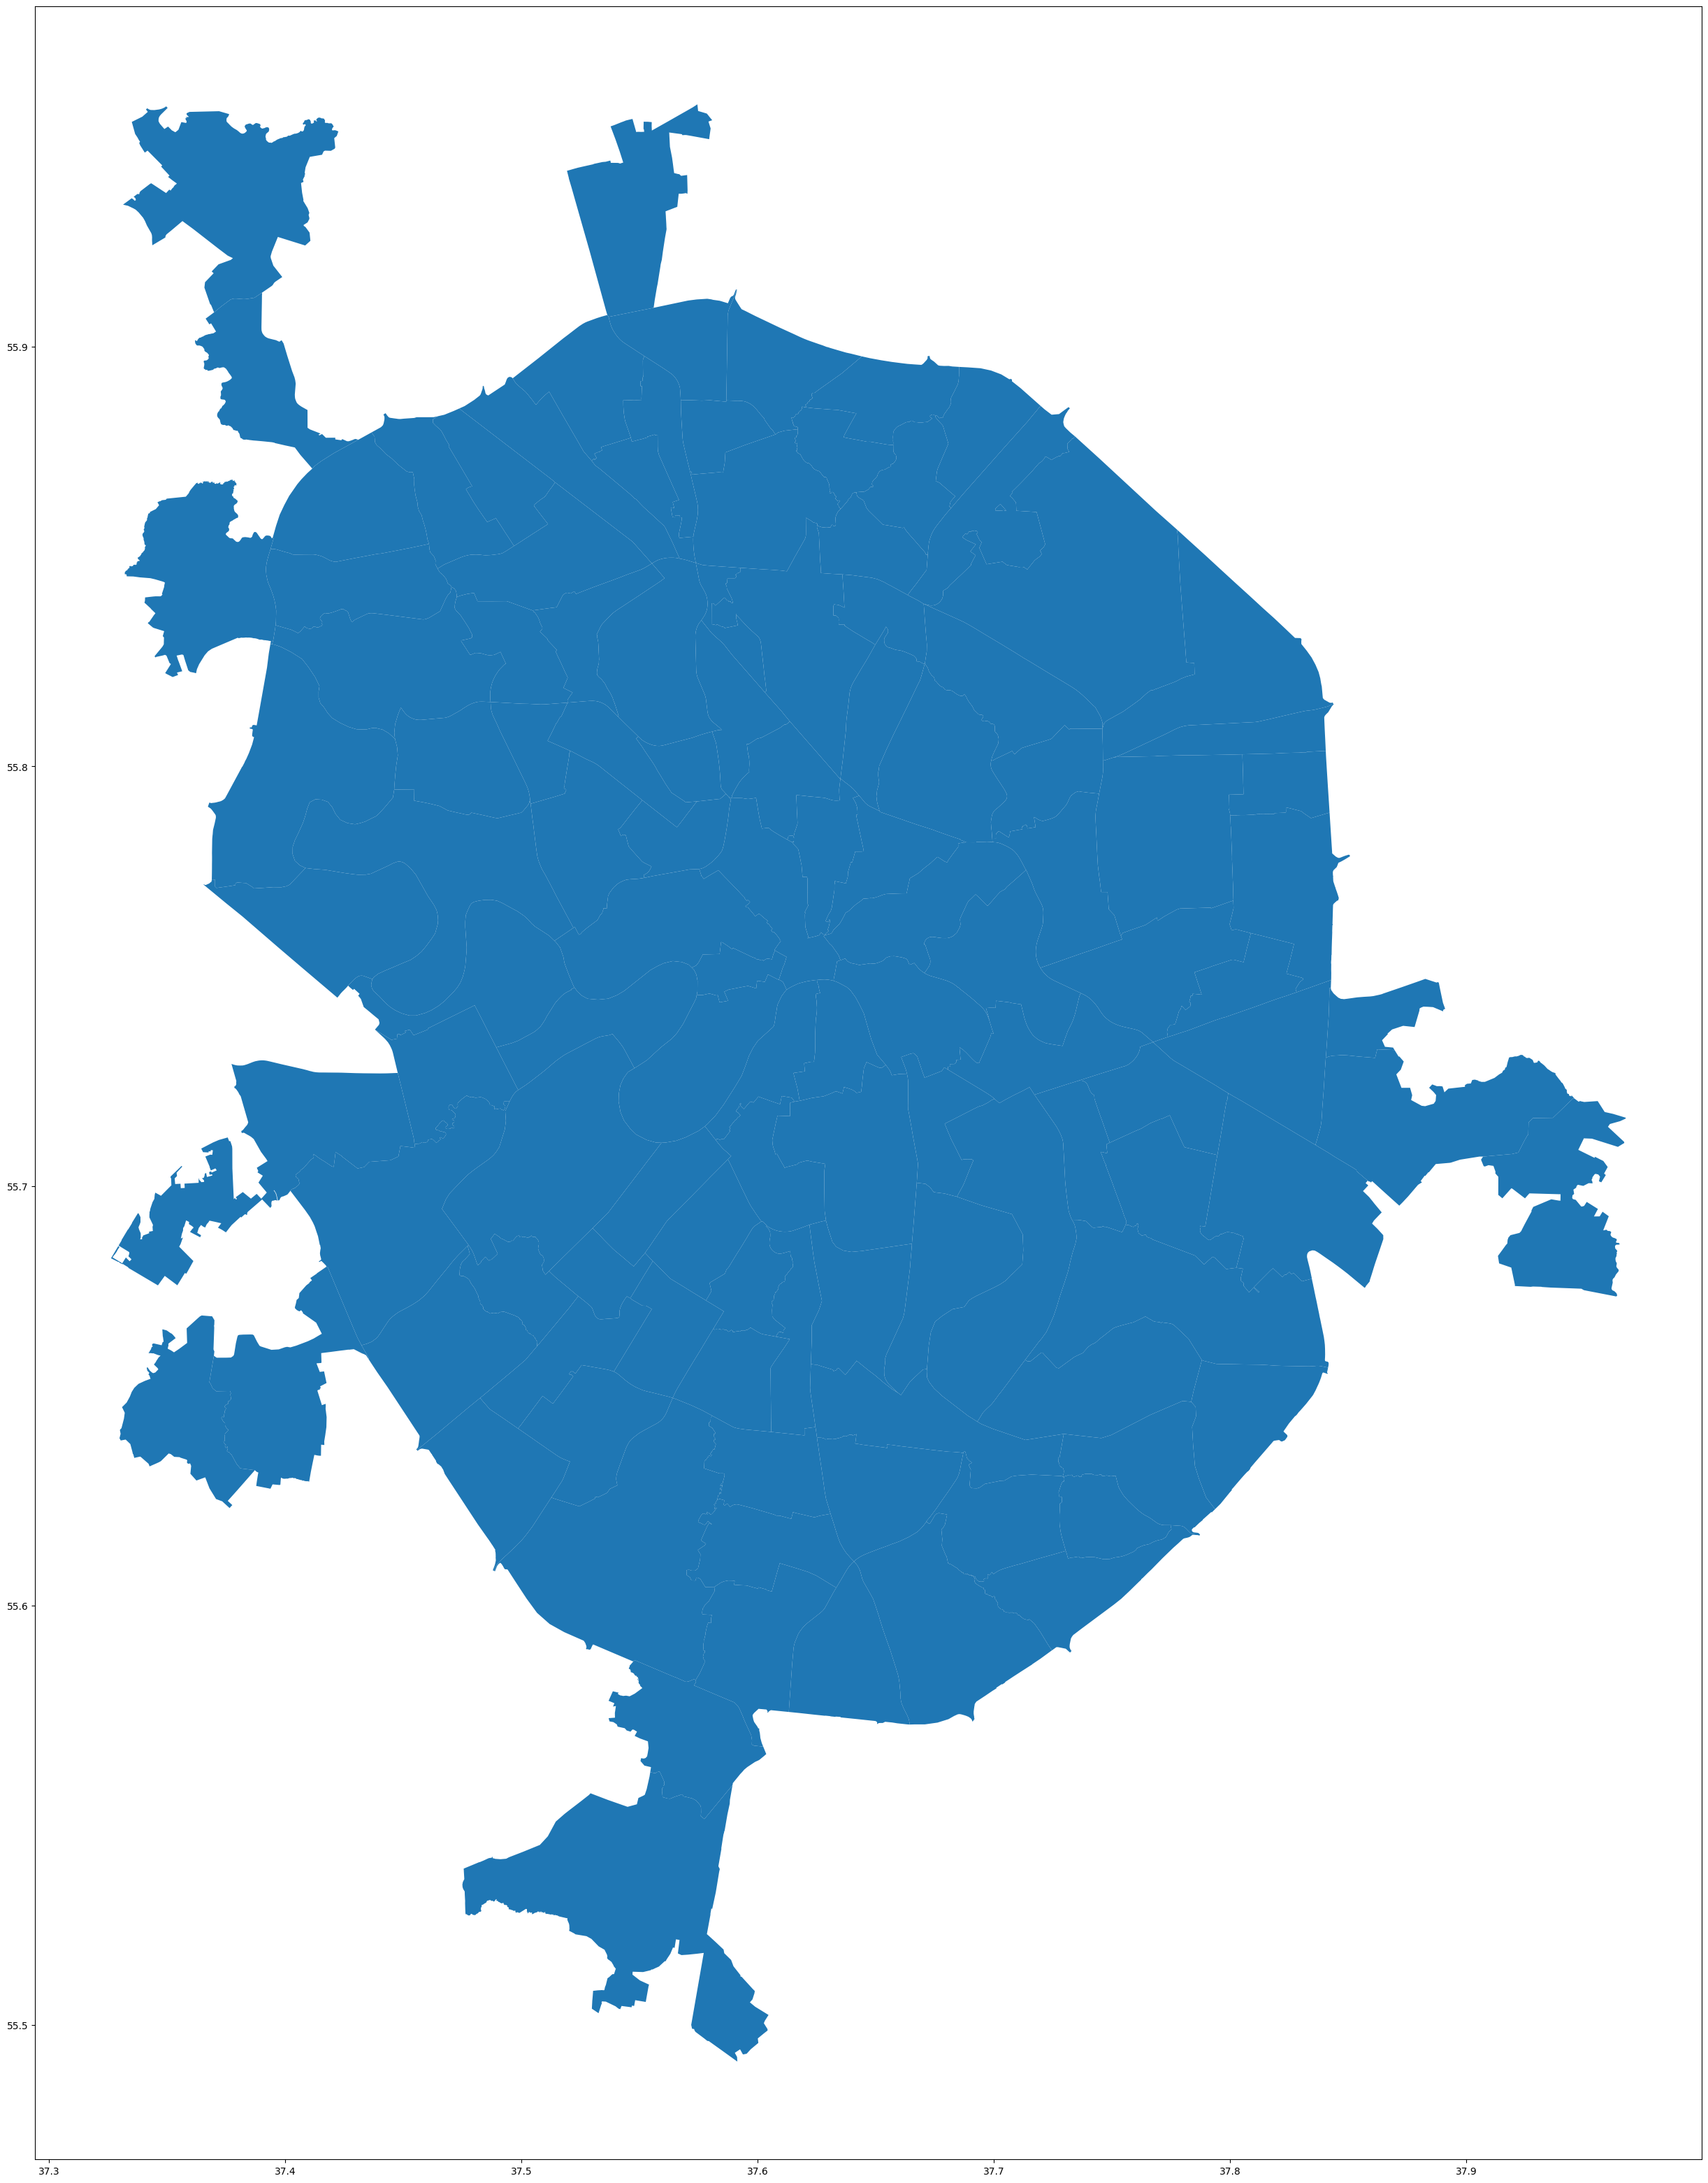

In [1309]:

base = boundaries.plot(figsize=(40,40))
# geo_df_objects[geo_df_objects["normalize_name"].isna()].plot(ax=base, marker='o', color='red', markersize=5);



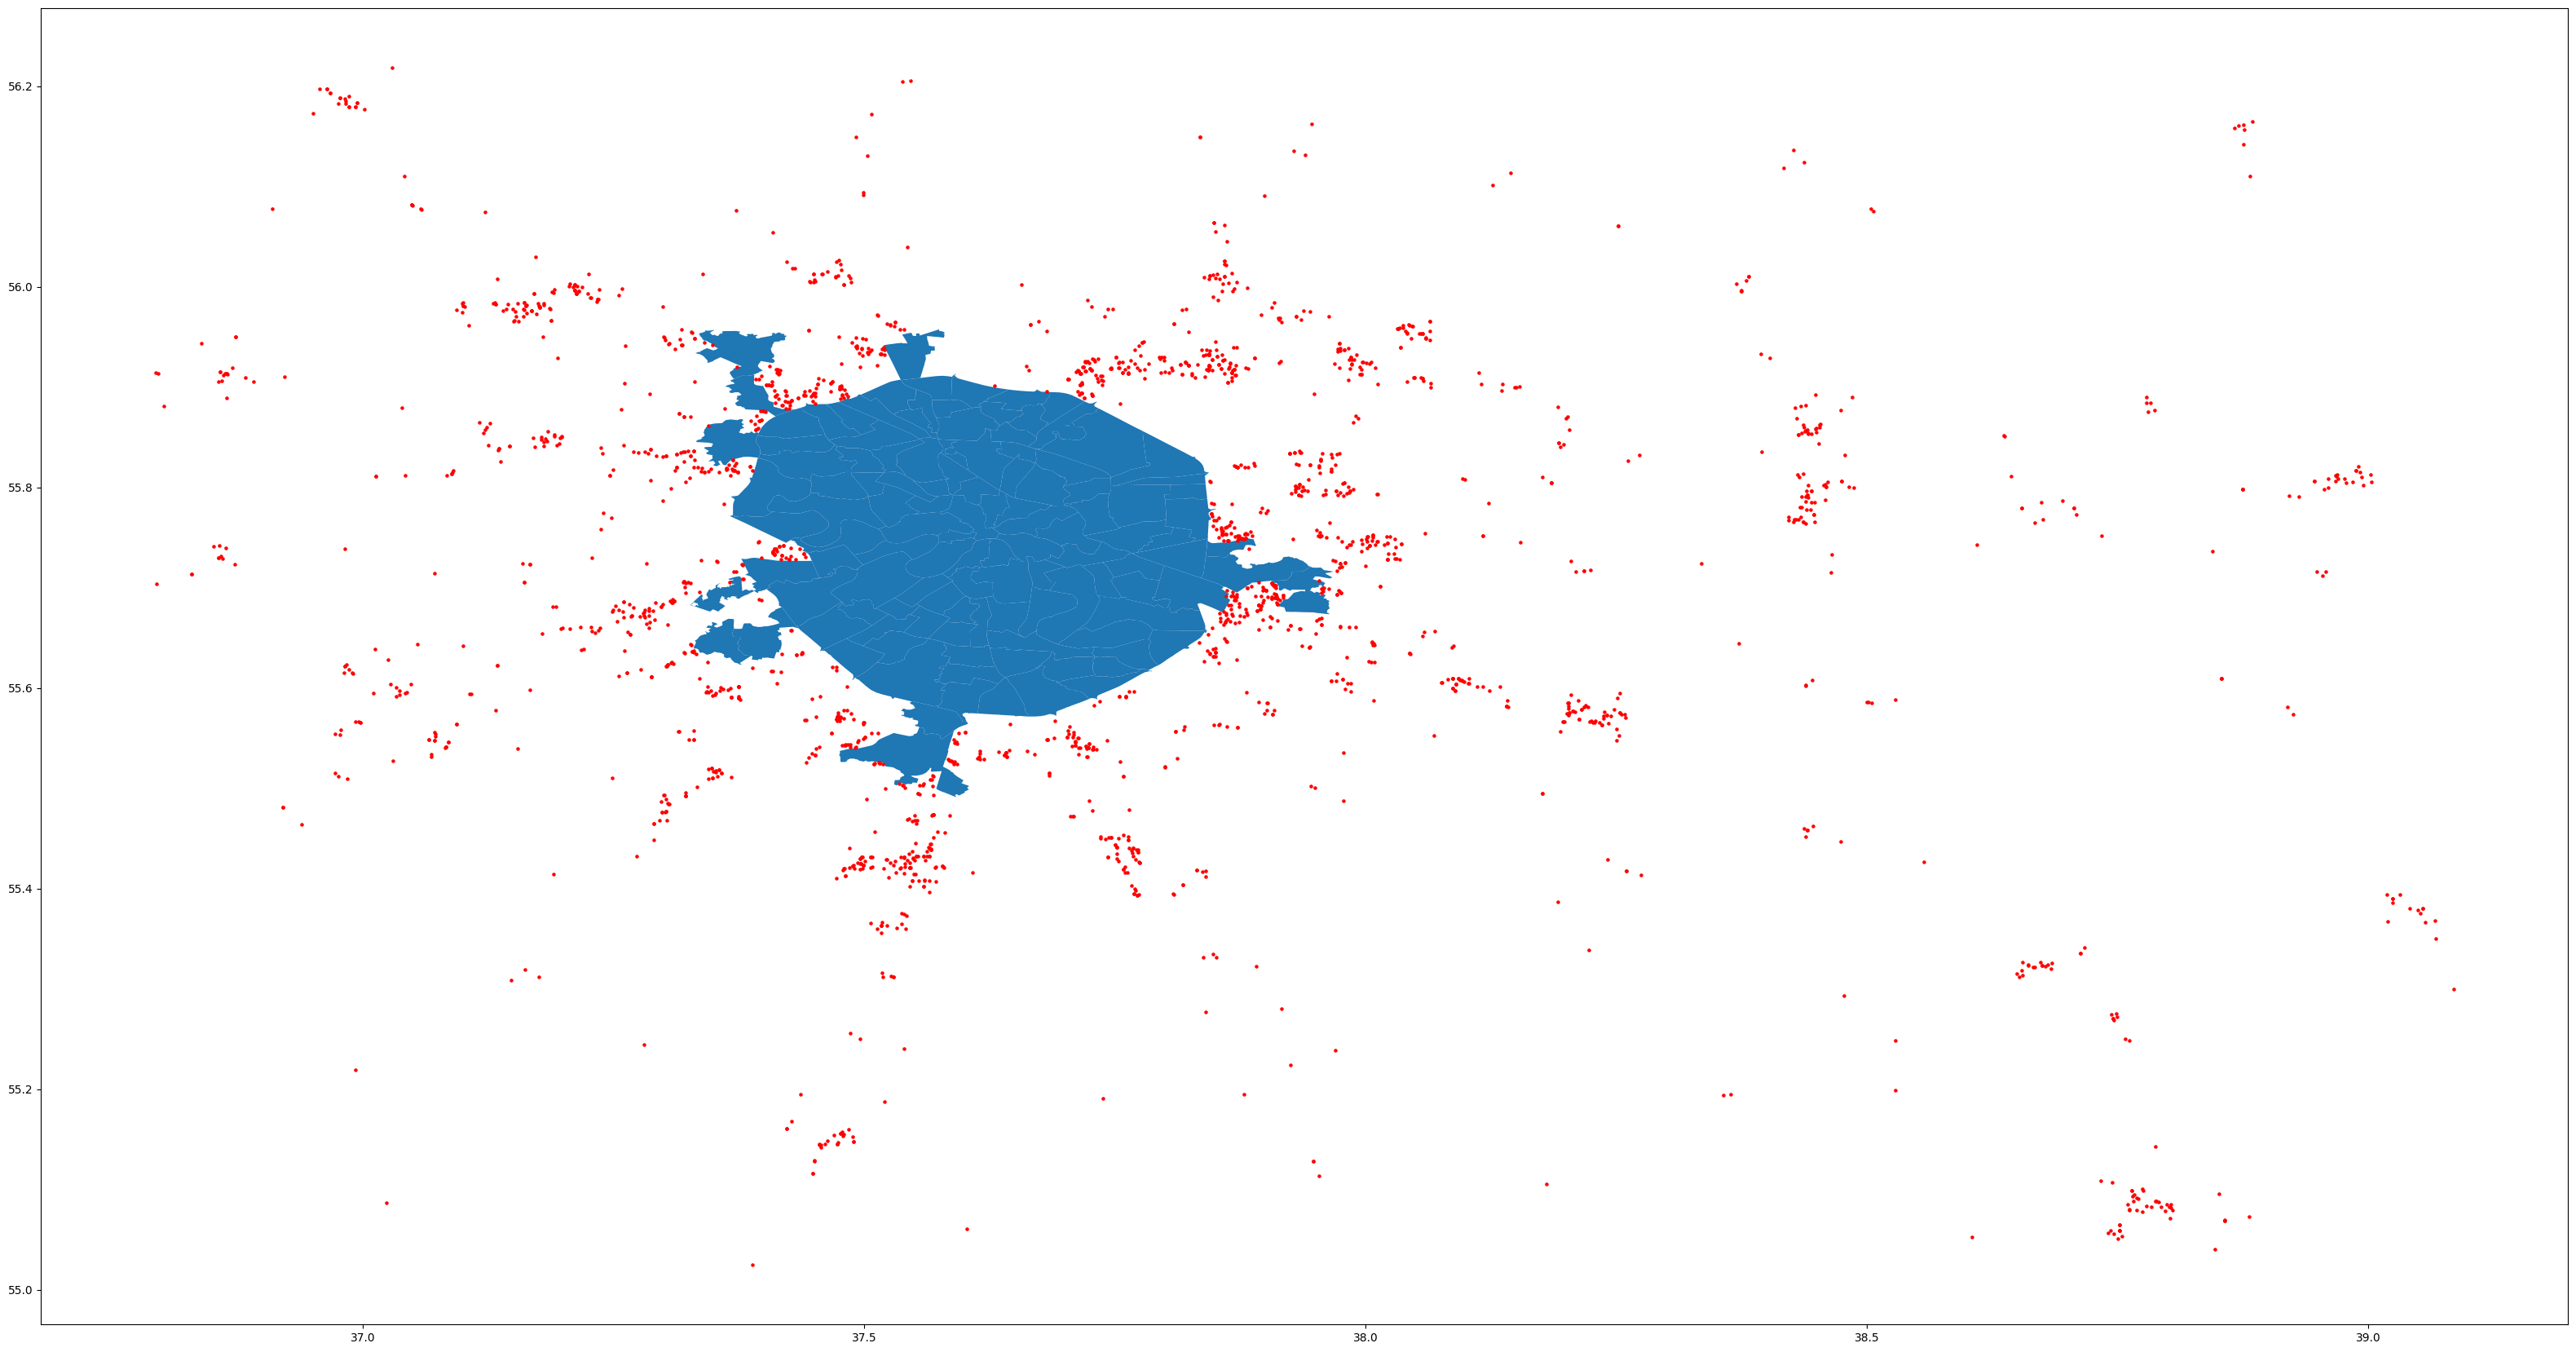

In [732]:

base = boundaries.plot(figsize=(40,40))
geo_df_objects[geo_df_objects["normalize_name"].isna()].plot(ax=base, marker='o', color='red', markersize=5);





In [297]:
boundaries

,NAME,NAME_EN,NAME_RU,ADMIN_LVL,OSM_TYPE,OSM_ID,ADMIN_L1D,ADMIN_L1,ADMIN_L2D,ADMIN_L2,...,ADMIN_L7,ADMIN_L8D,ADMIN_L8,ADMIN_L9D,ADMIN_L9,ADMIN_L10D,ADMIN_L10,oktmo,okato,geometry
13,район Метрогородок,Metrogorodok District,район Метрогородок,8,relation,1319078,None,None,None,None,...,None,None,None,None,None,None,None,45311000,45263581000,"MULTIPOLYGON (((37.67021 55.83874, 37.67072 55..."
15,район Ивановское,Ivanovskoye District,район Ивановское,8,relation,1319263,None,None,None,None,...,None,None,None,None,None,None,None,45306000,45263567000,"POLYGON ((37.83848 55.78838, 37.84088 55.78879..."
16,район Измайлово,Izmaylovo District,район Измайлово,8,relation,1319245,None,None,None,None,...,None,None,None,None,None,None,None,45307000,45263570000,"POLYGON ((37.74535 55.77005, 37.74523 55.77051..."
21,район Зюзино,Zyuzino District,район Зюзино,8,relation,1292286,None,None,None,None,...,None,None,None,None,None,None,None,45901000,45293562000,"POLYGON ((37.59380 55.66556, 37.59410 55.66558..."
22,район Перово,Perovo District,район Перово,8,relation,1299013,None,None,None,None,...,None,None,None,None,None,None,None,45312000,45263583000,"POLYGON ((37.77454 55.73841, 37.77441 55.73819..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,Дмитровский район,Dmitrovsky District,Дмитровский район,8,relation,445278,None,None,None,None,...,None,None,None,None,None,None,None,45339000,45277574000,"POLYGON ((37.50722 55.89730, 37.51765 55.90199..."
140,район Щукино,Shchukino District,район Щукино,8,relation,431464,None,None,None,None,...,None,None,None,None,None,None,None,45372000,45283587000,"POLYGON ((37.49891 55.78884, 37.49843 55.78878..."
142,район Бибирево,Bibirevo District,район Бибирево,8,relation,446085,None,None,None,None,...,None,None,None,None,None,None,None,45352000,45280558000,"POLYGON ((37.59039 55.91153, 37.59050 55.91129..."
144,район Северный,Severny District,район Северный,8,relation,445284,None,None,None,None,...,None,None,None,None,None,None,None,45363000,45280585000,"POLYGON ((37.51923 55.94194, 37.52020 55.94208..."


In [161]:
gdf_pastomats.sindex.nearest(Point(1, 1))

ImportError: Spatial indexes require either `rtree` or `pygeos`. See installation instructions at https://geopandas.org/install.html

In [ ]:
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()